# IPA27 - Procesamiento del Índice de Prosperidad Andaluz (Multiregional v1)

Este notebook tiene como objetivo realizar el procesamiento avanzado, normalización y cálculo del **IPA27** extendiendo el análisis a las 17 Comunidades Autónomas más el total de España.

### Objetivos: 
1. **Carga y Limpieza**: Importar todos los indicadores desde el archivo consolidado `ipa27_raw_YYYYMMDD.xlsx`.
2. **Tratamiento de Series**: Aplicar desestacionalización, interpolación y tratamiento de outliers siguiendo la metodología del proyecto original.
3. **Normalización**: Estandarizar las series para permitir su agregación.
4. **Cálculo de Pilares y Dominios**: Implementar la metodología de agregación del **Legatum Prosperity Index**.
5. **Análisis Comparativo**: Generar resultados que permitan comparar la evolución de Andalucía frente al resto de regiones españolas.

In [1]:
import os
import glob
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy.interpolate import CubicSpline
from datetime import datetime

warnings.filterwarnings('ignore')

# Asegurar que trabajamos desde la raíz del proyecto
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
    print(f"🏠 Directorio de trabajo: {os.getcwd()}")

# Configuración visual
pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 9

# === REGIONES (17 CCAA + ESPAÑA) ===
REGIONES = ['ESP', 'AND', 'ARA', 'AST', 'BAL', 'CAN', 'CANT', 'CYL', 'CLM', 'CAT', 'VAL', 'EXT', 'GAL', 'MAD', 'MUR', 'NAV', 'PV', 'RIO']

# === RUTAS ===
def get_latest_vintage():
    files = glob.glob('results/data/ipa27_raw_*.xlsx')
    if not files:
        fallback = 'results/data/ipa27_raw.xlsx'
        return fallback if os.path.exists(fallback) else None
    return sorted(files)[-1]

FILEPATH = get_latest_vintage()
if FILEPATH:
    print(f"📂 Utilizando vintage: {FILEPATH}")
else:
    print("❌ No se encontró ningún archivo ipa27_raw_*.xlsx en results/data/")

# === OBJETIVO TEMPORAL ===
Q_OBJETIVO = pd.Period('2025Q4', freq='Q')

# === INDICADORES A DESESTACIONALIZAR ===
DESEST_MENSUAL = ['EMP_SOC', 'INF_TRA', 'INV_HIP', 'SOC_ASO', 'CON_OCI']
DESEST_TRIMESTRAL = ['ECO_COL_sal','LIB_SEX', 'SEG_BAL', 'SEG_CRI', 'VID_PAR']

# === NORMALIZACIÓN PER CÁPITA ===
PER_CAPITA_CONFIG = {
    'SEG_BAL': 'POB',
    'SEG_CRI': 'POB',
    'LIB_SEX': 'POB',
    'LIB_ODI': 'POB',
    'EDU_SUP': 'POB',
    'EMP_SOC': 'POB',
    'EMP_NAT': 'POB',
    'INV_HIP': 'POB',
    'INF_TRA': 'POB',
    'SOC_ASO': 'POB',
    'CON_OCI': 'POB',   # ← CAMBIADO: Afiliados = personas, dividir por población
    'INV_IED': 'PIB',   # Mantener, pero arreglar la lógica abajo
}

# === CHOW-LIN: INDICADORES RELACIONADOS ===
CHOWLIN_CONFIG = {
    'CON_IDI': {'rel': 'ECO_RBHpc', 'tipo': 'stock'},      # % PIB → media
    'EDU_ABA': {'rel': 'EDU_SUP', 'tipo': 'stock'},      # % abandono → media
    'EMP_NAT': {'rel': 'INF_TRA', 'tipo': 'flujo'},      # nacimientos → suma
    'INF_BAN': {'rel': 'EDU_SUP', 'tipo': 'stock'},      # % bancarización → media
    'LIB_ODI': {'rel': 'SEG_CRI', 'tipo': 'flujo'},      # delitos → suma
    'SAL_ESP': {'rel': 'ECO_RBHpc', 'tipo': 'stock'},      # años vida → media
    'SOC_PAR_enlazado': {'rel': 'EMP_SOC', 'tipo': 'stock'},  # % participación → media
    'VID_ARO': {'rel': 'EDU_SUP', 'tipo': 'stock'},      # % AROPE → media
}

# === INDICADORES A INVERTIR (menor es mejor) ===
INVERTIR = ['SEG_BAL', 'SEG_CRI', 'LIB_ODI', 'LIB_SEX', 'VID_ARO', 'VID_PAR']

# === ESTRUCTURA JERÁRQUICA ===
# Corrección: Usamos GOB_EFF en lugar de GOB_TRA
ESTRUCTURA = {
    'Sociedades Inclusivas': {
        '1. Seguridad': ['SEG_BAL', 'SEG_CRI'],
        '2. Libertad': ['LIB_ODI', 'LIB_SEX'],
        '3. Gobernanza': ['GOB_DES', 'GOB_EFF'],
        '4. Capital Social': ['SOC_ASO', 'SOC_PAR_enlazado'],
    },
    'Economías Abiertas': {
        '5. Inversión': ['INV_HIP', 'INV_IED'],
        '6. Empresas': ['EMP_NAT', 'EMP_SOC'],
        '7. Infraestructura': ['INF_BAN', 'INF_TRA'],
        '8. Calidad Económica': ['ECO_RBHpc', 'ECO_COL_sal'], 
    },
    'Personas Empoderadas': {
        '9. Vida': ['VID_ARO', 'VID_PAR'],
        '10. Salud': ['SAL_ESP', 'SAL_SAT_enlazado'],
        '11. Educación': ['EDU_ABA', 'EDU_SUP'],
        '12. Conocimiento': ['CON_IDI', 'CON_OCI'],
    }
}

print("✓ Configuración cargada")


c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


🏠 Directorio de trabajo: g:\Mi unidad\Proyectos\IPA27_project
📂 Utilizando vintage: results/data\ipa27_raw_20260225.xlsx
✓ Configuración cargada


## 1. Carga de Datos

Cargamos las hojas del Excel consolidado, que ahora incluyen datos para las 18 regiones (17 CC.AA. + España).
Debido a que algunas hojas pueden contener periodos con diferentes frecuencias (ej. Trimestral y Anual), aplicamos un filtro por formato de periodo para separar los datos correctamente.

In [2]:
# %% CELDA 2: CARGA DE DATOS
print("=" * 60)
print("CARGA DE DATOS (Multiregional)")
print("=" * 60)

xlsx = pd.ExcelFile(FILEPATH)
sheets = [s for s in xlsx.sheet_names if s != 'LEER']
print(f"Hojas encontradas (indicadores): {len(sheets)}")

mensual_list = []
trimestral_list = []
anual_list = []

for sheet in sheets:
    df_ind = pd.read_excel(xlsx, sheet_name=sheet)
    if df_ind.empty: continue
    
    # Limpiar espacios en los nombres de las columnas
    df_ind.columns = [c.strip() for c in df_ind.columns]
    
    # Renombrar regiones a INDICADOR_REGION
    prefix = sheet + "_"
    rename_cols = {c: prefix + c for c in df_ind.columns if c != 'Periodo'}
    df_ind = df_ind.rename(columns=rename_cols)
    
    # Asegurar que Periodo es string para el filtrado
    df_ind['Periodo'] = df_ind['Periodo'].astype(str)
    
    # --- MENSUAL ---
    mask_m = df_ind['Periodo'].str.contains('-M', na=False)
    if mask_m.any():
        m_part = df_ind[mask_m].copy()
        m_part['Periodo'] = pd.to_datetime(m_part['Periodo'].str.replace('-M', '-'), format='%Y-%m')
        mensual_list.append(m_part.set_index('Periodo'))

    # --- TRIMESTRAL ---
    mask_q = df_ind['Periodo'].str.contains('-Q', na=False)
    if mask_q.any():
        q_part = df_ind[mask_q].copy()
        q_part['Periodo'] = q_part['Periodo'].apply(
            lambda p: pd.Period(year=int(p.split('-Q')[0]), quarter=int(p.split('-Q')[1]), freq='Q')
        )
        trimestral_list.append(q_part.set_index('Periodo'))

    # --- ANUAL ---
    mask_a = df_ind['Periodo'].str.contains('-ANUAL', na=False)
    if mask_a.any():
        a_part = df_ind[mask_a].copy()
        a_part['Periodo'] = a_part['Periodo'].str.replace('-ANUAL', '').astype(int)
        anual_list.append(a_part.set_index('Periodo'))

# Consolidar en DataFrames por frecuencia
def consolidar(lista_dfs):
    if not lista_dfs: return pd.DataFrame()
    df_final = pd.concat(lista_dfs, axis=1)
    if df_final.columns.duplicated().any():
        df_final = df_final.groupby(level=0, axis=1).first()
    return df_final.sort_index()

mensual = consolidar(mensual_list)
trimestral = consolidar(trimestral_list)
anual = consolidar(anual_list)

# --- Resumen ---
def get_clean_cols(df):
    return [c for c in df.columns if not c.startswith('AUX_')]

if not mensual.empty:
    print(f"\n📊 MENSUAL")
    print(f"   Shape: {mensual.shape}")
    print(f"   Rango: {mensual.index.min():%Y-%m} → {mensual.index.max():%Y-%m}")
    inds = sorted(list(set([c.split('_')[0] for c in get_clean_cols(mensual)])))
    print(f"   Indicadores ({len(inds)}): {inds[:10]}...")

if not trimestral.empty:
    print(f"\n📊 TRIMESTRAL")
    print(f"   Shape: {trimestral.shape}")
    print(f"   Rango: {trimestral.index.min()} → {trimestral.index.max()}")
    inds = sorted(list(set([c.split('_')[0] for c in get_clean_cols(trimestral)])))
    print(f"   Indicadores ({len(inds)}): {inds[:10]}...")

if not anual.empty:
    print(f"\n📊 ANUAL")
    print(f"   Shape: {anual.shape}")
    print(f"   Rango: {anual.index.min()} → {anual.index.max()}")
    inds = sorted(list(set([c.split('_')[0] for c in get_clean_cols(anual)])))
    print(f"   Indicadores ({len(inds)}): {inds[:10]}...")


# === TRANSFORMACIÓN EXCEPCIONAL EDU_ABA ===
# Convertimos 'Tasa de Abandono' en '% Población que completa estudios' (100 - x)
if not anual.empty:
    cols_edu = [c for c in anual.columns if c.startswith('EDU_ABA_')]
    for col in cols_edu:
        anual[col] = 100 - anual[col]
    if cols_edu: print(f"\n✓ EDU_ABA transformado a 'Positivo' (100 - x) para {len(cols_edu)} regiones.")

print("\n✓ Datos multiregionales cargados y consolidados")

CARGA DE DATOS (Multiregional)
Hojas encontradas (indicadores): 34

📊 MENSUAL
   Shape: (204, 126)
   Rango: 2009-01 → 2025-12
   Indicadores (6): ['CON', 'EMP', 'GOB', 'INF', 'INV', 'SOC']...

📊 TRIMESTRAL
   Shape: (125, 236)
   Rango: 1995Q1 → 2026Q1
   Indicadores (8): ['ECO', 'EDU', 'GOB', 'INV', 'LIB', 'SAL', 'SEG', 'VID']...

📊 ANUAL
   Shape: (51, 164)
   Rango: 1975 → 2025
   Indicadores (9): ['CON', 'ECO', 'EDU', 'EMP', 'INF', 'LIB', 'SAL', 'SOC', 'VID']...

✓ EDU_ABA transformado a 'Positivo' (100 - x) para 18 regiones.

✓ Datos multiregionales cargados y consolidados


In [3]:
# %% CELDA 2B: REGISTRO DE TRAZABILIDAD (Mapa de Origen de cada indicador)
# Construimos un diccionario que "fotografía" el estado bruto de cada indicador
# y documenta qué transformaciones le tocan. Esto alimentará la auditoría final.

# Extraer la lista de los 25 indicadores finales del IPA27
indicadores_ipa27 = []
for pilar, dominios in ESTRUCTURA.items():
    for dominio, inds in dominios.items():
        indicadores_ipa27 += inds

print(f"Indicadores IPA27 a auditar: {len(indicadores_ipa27)}")

# Construir el registro
AUDIT_REGISTRY = {}

for ind in indicadores_ipa27:
    ficha = {
        'indicador': ind,
        'pilar': None,
        'dominio': None,
        'fuente_frecuencia': None,    # 'ANUAL', 'TRIMESTRAL', 'MENSUAL'
        'n_regiones_raw': 0,
        'n_obs_raw': 0,
        'rango_raw': None,
        'chowlin': ind in CHOWLIN_CONFIG,
        'chowlin_ref': CHOWLIN_CONFIG.get(ind, {}).get('rel', None),
        'chowlin_tipo': CHOWLIN_CONFIG.get(ind, {}).get('tipo', None),
        'per_capita': ind in PER_CAPITA_CONFIG,
        'per_capita_divisor': PER_CAPITA_CONFIG.get(ind, None),
        'invertido': ind in INVERTIR,
        'desestacionalizar': ind in DESEST_MENSUAL or ind in DESEST_TRIMESTRAL,
        'deflactado': ind == 'ECO_COL_sal',  # Solo este se deflacta por IPC
        'snapshot_raw': None,  # Guardaremos una copia del dato bruto para AND y ESP
    }
    
    # Identificar pilar y dominio
    for pilar, dominios in ESTRUCTURA.items():
        for dominio, inds in dominios.items():
            if ind in inds:
                ficha['pilar'] = pilar
                ficha['dominio'] = dominio
    
    # Buscar en qué DataFrame bruto vive el indicador
    # Probamos con el prefijo exacto y también sin sufijos especiales (ej: ECO_RBHpc -> ECO_RBH)
    prefijos_buscar = [ind]
    # Algunos indicadores finales tienen sufijos que no existen en el raw
    if ind.endswith('pc'):
        prefijos_buscar.append(ind[:-2])  # ECO_RBHpc -> ECO_RBH
    if '_enlazado' in ind:
        prefijos_buscar.append(ind.replace('_enlazado', ''))  # SOC_PAR_enlazado -> SOC_PAR
    
    for prefijo in prefijos_buscar:
        for freq_name, df_raw in [('ANUAL', anual), ('TRIMESTRAL', trimestral), ('MENSUAL', mensual)]:
            cols = [c for c in df_raw.columns if c.startswith(f"{prefijo}_") and not c.startswith('AUX_')]
            if cols:
                ficha['fuente_frecuencia'] = freq_name
                ficha['n_regiones_raw'] = len(cols)
                data_slice = df_raw[cols].dropna(how='all')
                ficha['n_obs_raw'] = len(data_slice)
                ficha['rango_raw'] = f"{data_slice.index.min()} → {data_slice.index.max()}"
                
                # Snapshot: guardar series AND y ESP para el audit
                col_and = [c for c in cols if c.endswith('_AND')]
                col_esp = [c for c in cols if c.endswith('_ESP')]
                ficha['snapshot_raw'] = {
                    'AND': df_raw[col_and[0]].dropna().copy() if col_and else None,
                    'ESP': df_raw[col_esp[0]].dropna().copy() if col_esp else None,
                }
                break
        if ficha['fuente_frecuencia']:
            break
    
    AUDIT_REGISTRY[ind] = ficha

# --- RESUMEN ---
print(f"\n{'Indicador':<22} {'Pilar':<24} {'Fuente':<12} {'Obs':<6} {'Regs':<6} {'ChowLin':<8} {'PerCap':<7} {'Inv':<5}")
print("-" * 95)
for ind, f in AUDIT_REGISTRY.items():
    print(f"{ind:<22} {(f['pilar'] or '?')[:22]:<24} {f['fuente_frecuencia'] or '???':<12} "
          f"{f['n_obs_raw']:<6} {f['n_regiones_raw']:<6} "
          f"{'Sí' if f['chowlin'] else '—':<8} "
          f"{'Sí' if f['per_capita'] else '—':<7} "
          f"{'↓' if f['invertido'] else '↑':<5}")

print(f"\n✓ Registro de trazabilidad creado para {len(AUDIT_REGISTRY)} indicadores.")


Indicadores IPA27 a auditar: 24

Indicador              Pilar                    Fuente       Obs    Regs   ChowLin  PerCap  Inv  
-----------------------------------------------------------------------------------------------
SEG_BAL                Sociedades Inclusivas    TRIMESTRAL   39     18     —        Sí      ↓    
SEG_CRI                Sociedades Inclusivas    TRIMESTRAL   35     18     —        Sí      ↓    
LIB_ODI                Sociedades Inclusivas    ANUAL        11     18     Sí       Sí      ↓    
LIB_SEX                Sociedades Inclusivas    TRIMESTRAL   35     18     —        Sí      ↓    
GOB_DES                Sociedades Inclusivas    MENSUAL      101    18     —        —       ↑    
GOB_EFF                Sociedades Inclusivas    TRIMESTRAL   39     17     —        —       ↑    
SOC_ASO                Sociedades Inclusivas    MENSUAL      204    18     —        Sí      ↑    
SOC_PAR_enlazado       Sociedades Inclusivas    ANUAL        8      18     Sí       —  

In [4]:
# %% CELDA 2C: TRIMESTRALIZACIÓN RENTA HOGARES (CHOW-LIN AR1)
# Objetivo: Trimestralizar ECO_RBH (Renta anual) usando PIB trimestral como indicador
# - Extrapolación ROBUSTA: Usa el crecimiento del PIB para proyectar la Renta,
#   asegurando continuidad perfecta sin caídas artificiales en 2024.
# - DEFLACTACIÓN INTEGRADA: Deflacta la Renta Nominal con el IPC antes de trimestralizar.
print('=' * 60)
print('TRIMESTRALIZACIÓN RENTA HOGARES: DEFLACTADO + CHOW-LIN AR(1)')
print('=' * 60)

import numpy as np
from scipy import linalg
import pandas as pd

# --- 1. DEFINICIÓN FUNCIÓN CHOW-LIN AR(1) MEJORADA ---
def chow_lin_ar1(ts_anual, ts_indicador_trim):
    """
    Implementación de Chow-Lin con residuos AR(1).
    Extrapolación robusta: Proyecta usando tasas de variación del indicador 
    a partir del último punto estimado para evitar desajustes de nivel.
    """
    # 1. Alineación de Fechas
    common_start = max(ts_anual.index.min(), ts_indicador_trim.index[0].year)
    start_q = pd.Period(f'{common_start}Q1', freq='Q')
    
    X_full = ts_indicador_trim[ts_indicador_trim.index >= start_q].copy()
    X_years = X_full.resample('A-DEC').mean().index.year
    Y = ts_anual[ts_anual.index.isin(X_years)]
    
    if len(Y) < 3: return None
    
    N = len(Y)
    n_est = N * 4
    n_full = len(X_full)
    
    X_est = X_full.iloc[:n_est]
    C = np.zeros((N, n_est))
    for i in range(N):
        C[i, i*4 : (i+1)*4] = 1
    
    y_vec = Y.values.reshape(-1, 1)
    x_est_vec = X_est.values.reshape(-1, 1)
    Ct = C.T
    
    # 2. Estimación de Rho (Grid Search)
    best_rho = 0
    best_ssr = np.inf
    for rho in np.linspace(0.5, 0.99, 20): # Forzamos rho alto para persistencia
        rows = np.arange(n_est)
        V = linalg.toeplitz(rho ** rows)
        Va = C @ V @ Ct
        try:
            Va_inv = np.linalg.inv(Va)
        except:
            continue
        X_agg = C @ x_est_vec
        beta = np.linalg.solve(X_agg.T @ Va_inv @ X_agg, X_agg.T @ Va_inv @ y_vec)
        u_a = y_vec - X_agg @ beta
        ssr = u_a.T @ Va_inv @ u_a
        if ssr < best_ssr:
            best_ssr = ssr
            best_rho = rho

    # 3. Cálculo Período Histórico
    rho = best_rho
    V = linalg.toeplitz(rho ** np.arange(n_est))
    Va = C @ V @ Ct
    Va_inv = np.linalg.inv(Va)
    X_agg = C @ x_est_vec
    beta = np.linalg.solve(X_agg.T @ Va_inv @ X_agg, X_agg.T @ Va_inv @ y_vec)
    
    u_a = y_vec - X_agg @ beta
    L = V @ Ct @ Va_inv
    residuos_trim_est = L @ u_a
    y_estimado_est = (x_est_vec @ beta + residuos_trim_est).flatten()
    
    # 4. Proyección Dinámica (Tasas)
    n_extra = n_full - n_est
    if n_extra > 0:
        y_full = list(y_estimado_est)
        for h in range(n_extra):
            idx_actual = n_est + h
            tasa_crecimiento = X_full.iloc[idx_actual] / X_full.iloc[idx_actual - 1]
            y_next = y_full[-1] * tasa_crecimiento
            y_full.append(y_next)
        y_final = np.array(y_full)
    else:
        y_final = y_estimado_est
    
    return pd.Series(y_final, index=X_full.index)

# --- 2. PREPARACIÓN IPC (DEFLACTOR) ---
# Primero obtenemos el IPC anual para deflactar la Renta Anual
print('\n   📊 Preparando deflactores (AUX_IPC)...')
cols_ipc = [c for c in mensual.columns if 'AUX_IPC' in c]
ipc_anual_dict = {}

for c_ipc in cols_ipc:
    reg = c_ipc.replace('AUX_IPC_', '')
    serie_mensual = mensual[c_ipc]
    
    # Rebasar IPC a 2019=100
    avg_2019 = serie_mensual[serie_mensual.index.year == 2019].mean()
    if pd.isna(avg_2019): 
        avg_2019 = serie_mensual.mean()
        
    serie_rebasada = (serie_mensual / avg_2019) * 100
    
    # Agregar a nivel anual
    serie_anual_ipc = serie_rebasada.resample('A-DEC').mean()
    serie_anual_ipc.index = serie_anual_ipc.index.year
    ipc_anual_dict[reg] = serie_anual_ipc

# --- 3. EJECUCIÓN (DEFLACTAR + CHOW-LIN) ---
ref_esp = trimestral['ECO_PIT_ESP'].dropna().sort_index() if 'ECO_PIT_ESP' in trimestral.columns else None
ref_and = trimestral['ECO_PIT_AND'].dropna().sort_index() if 'ECO_PIT_AND' in trimestral.columns else None

cols_rbh_anual = [c for c in anual.columns if 'ECO_RBH' in c]

if ref_esp is not None and cols_rbh_anual:
    print(f'\n   📊 Deflactando y Proyectando {len(cols_rbh_anual)} series...')
    count_ok = 0
    count_fallback = 0
    
    for col in cols_rbh_anual:
        region = col.replace('ECO_RBH_', '')
        serie_anual = anual[col].dropna()
        if len(serie_anual) < 3: continue
        
        # 3.1. Deflactar Renta Anual
        # Obtener IPC de la región o usar el nacional (ESP)
        ipc_reg = ipc_anual_dict.get(region)
        if ipc_reg is None:
            ipc_reg = ipc_anual_dict.get('ESP')
            count_fallback += 1
            
        if ipc_reg is not None:
            # Alinear índices
            serie_anual.index = serie_anual.index.year if hasattr(serie_anual.index, 'year') else serie_anual.index
            common_idx = serie_anual.index.intersection(ipc_reg.index)
            serie_anual = (serie_anual.loc[common_idx] / ipc_reg.loc[common_idx]) * 100
            serie_anual = serie_anual.dropna()
            common_idx = serie_anual.index
            # Volver a poner el index como era originamente (datetime o period) si es necesario
            # En nuestro df anual, los indices suelen ser Period('A-DEC') o timestamp de fin de año
            # Generaremos años de nuevo
            # Mantenemos el índice numérico anual que necesita la función Chow-Lin
            serie_anual.index = common_idx
            
        # 3.2. Chow-Lin
        indicador_ref = ref_and if (region == 'AND' and ref_and is not None) else ref_esp
        
        try:
            res_series = chow_lin_ar1(serie_anual, indicador_ref)
            if res_series is not None:
                col_trim = f'ECO_RBH_{region}'
                trimestral[col_trim] = res_series
                count_ok += 1
        except Exception as e:
            print(f'    ❌ Error {col}: {e}')
    
    trimestral = trimestral.sort_index()
    print(f'\n   ✅ {count_ok} regiones trimestralizadas en TÉRMINOS REALES.')
    if count_fallback > 0:
        print(f'   ℹ️ {count_fallback} regiones usaron el IPC nacional como fallback.')
else:
    print('❌ FALTAN DATOS.')

print('\n✓ Proceso completado.')


TRIMESTRALIZACIÓN RENTA HOGARES: DEFLACTADO + CHOW-LIN AR(1)

   📊 Preparando deflactores (AUX_IPC)...

   📊 Deflactando y Proyectando 18 series...

   ✅ 18 regiones trimestralizadas en TÉRMINOS REALES.

✓ Proceso completado.


In [5]:
# %% CELDA: CONVERSIÓN DE COSTES SALARIALES A EUROS REALES (Deflactado Regional)
print("=" * 60)
print("DEFLACTADO DE COSTE SALARIAL (ECO_COL_sal) - Nivel Regional")
print("=" * 60)

# Buscamos todas las columnas de salarios y de IPC
cols_sal = [c for c in trimestral.columns if 'ECO_COL_sal' in c]
cols_ipc = [c for c in mensual.columns if 'AUX_IPC' in c]

if not cols_ipc:
    print("⚠️ No se encontraron series de IPC (AUX_IPC) en el DataFrame 'mensual'.")
else:
    # 1. Preparamos los IPCs trimestrales por región rebasados a 2019=100
    ipc_trim_dict = {}
    
    for c_ipc in cols_ipc:
        reg = c_ipc.replace('AUX_IPC_', '')
        serie_mensual = mensual[c_ipc]
        
        # Calcular base 2019 para esta región
        avg_2019 = serie_mensual[serie_mensual.index.year == 2019].mean()
        if pd.isna(avg_2019) or avg_2019 == 0: 
            avg_2019 = serie_mensual.mean() # Fallback si no hay 2019
            
        serie_trim = (serie_mensual / avg_2019 * 100).resample('Q').mean()
        serie_trim.index = serie_trim.index.to_period('Q')
        ipc_trim_dict[reg] = serie_trim

    # 2. Deflactamos cada serie salarial con su IPC correspondiente
    print(f"Deflactando {len(cols_sal)} series territoriales...")
    count_ok = 0
    count_fallback = 0
    
    for col in cols_sal:
        reg = col.replace('ECO_COL_sal_', '')
        
        # Seleccionar deflactor: regional o nacional (fallback)
        if reg in ipc_trim_dict:
            deflactor = ipc_trim_dict[reg]
        else:
            deflactor = ipc_trim_dict.get('ESP')
            count_fallback += 1
            
        if deflactor is not None:
            common_idx = trimestral[col].dropna().index.intersection(deflactor.index)
            if not common_idx.empty:
                trimestral.loc[common_idx, col] = (trimestral.loc[common_idx, col] / deflactor.loc[common_idx]) * 100
                count_ok += 1
                
    print(f"✓ {count_ok} series de coste salarial convertidas a euros reales.")
    if count_fallback > 0:
        print(f"ℹ️ {count_fallback} regiones usaron el IPC nacional como fallback.")

    # Verificación: Mostrar valor de Andalucía en un periodo reciente
    if 'ECO_COL_sal_AND' in trimestral.columns:
        val = trimestral.loc[trimestral.index.max(), 'ECO_COL_sal_AND']
        print(f"\nValor final (Real) AND {trimestral.index.max()}: {val:.2f}")

DEFLACTADO DE COSTE SALARIAL (ECO_COL_sal) - Nivel Regional
Deflactando 18 series territoriales...
✓ 18 series de coste salarial convertidas a euros reales.

Valor final (Real) AND 2026Q1: nan


## 2B. Inventario de Indicadores

Tabla resumen de todos los indicadores del IPA27 ordenados por la estructura jerárquica. 
A diferencia del notebook original, aquí validamos la existencia de datos para las **18 regiones**.

In [6]:
# %% CELDA 2B: IMPUTACIÓN AUTOMÁTICA DE HUECOS REGIONALES
# Estrategia: Si falta una serie regional, imputar con el dato nacional (ESP) como proxy.
# Esto asegura que siempre tengamos 18 regiones para todos los indicadores.

print("=" * 60)
print("RED DE SEGURIDAD: IMPUTACIÓN DE HUECOS CON DATO NACIONAL (ESP)")
print("=" * 60)

def imputar_con_esp(df, nombre_df):
    if df is None or df.empty: return
    
    # Identificar indicadores base (los que tienen _ESP)
    # Asumimos formato NOMBRE_INDICADOR_REGION
    cols = df.columns
    indicadores_base = set([c.rsplit('_', 1)[0] for c in cols if c.endswith('_ESP')])
    
    imputados = 0
    
    for ind in indicadores_base:
        col_esp = f"{ind}_ESP"
        series_esp = df[col_esp]
        
        # Si ESP está vacía, no podemos hacer mucho
        if series_esp.dropna().empty:
            continue
            
        # Revisar resto de regiones
        for reg in REGIONES:
            if reg == 'ESP': continue
            
            col_reg = f"{ind}_{reg}"
            
            # Caso 1: La columna no existe
            if col_reg not in df.columns:
                df[col_reg] = series_esp
                print(f"  🔧 {nombre_df}: Creando {col_reg} usando copia de {col_esp}")
                imputados += 1
            
            # Caso 2: La columna existe pero es todo NaNs
            elif df[col_reg].dropna().empty:
                df[col_reg] = df[col_reg].fillna(series_esp)
                print(f"  🔧 {nombre_df}: Rellenando vacíos en {col_reg} con datos de {col_esp}")
                imputados += 1
    
    if imputados > 0:
        print(f"  -> Total imputados en {nombre_df}: {imputados}")
    else:
        print(f"  -> {nombre_df}: Todo completo (o sin referencia ESP).")

print("Revisando Anuales...")
imputar_con_esp(anual, 'ANUAL')

print("\nRevisando Trimestrales...")
imputar_con_esp(trimestral, 'TRIMESTRAL')

print("\nRevisando Mensuales...")
imputar_con_esp(mensual, 'MENSUAL')

print("\n✓ Verificación de integridad completada.")


RED DE SEGURIDAD: IMPUTACIÓN DE HUECOS CON DATO NACIONAL (ESP)
Revisando Anuales...


  🔧 ANUAL: Creando SOC_PAR_ARA usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_AST usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_BAL usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_CAN usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_CANT usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_CYL usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_CLM usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_CAT usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_VAL usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_EXT usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_GAL usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_MAD usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_MUR usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_NAV usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_PV usando copia de SOC_PAR_ESP
  🔧 ANUAL: Creando SOC_PAR_RIO usando copia de SOC_PAR_ESP
  -> Total imputados en ANUAL: 16

Revisando Trimestrale

In [7]:
# %% CELDA 2D: LIMPIEZA ZOMBIS Y CÁLCULO RENTA PER CÁPITA (ECO_RBHpc)
# Objetivo: Eliminar series no usadas y generar la variable definitiva de Calidad Económica.

print("=" * 60)
print("LIMPIEZA Y CÁLCULO RENTA PER CÁPITA")
print("=" * 60)

#INTERPOLACIÓN DE POBLACIÓN
print("=" * 60)
print("INTERPOLACIÓN DE SERIES DE POBLACIÓN")
print("=" * 60)

cols_pob = [c for c in trimestral.columns if 'AUX_POB' in c]
n_interpoladas = 0

for col in cols_pob:
    antes_na = trimestral[col].isna().sum()
    # Interpolar linealmente
    trimestral[col] = trimestral[col].interpolate(method='linear')
    # Forward/backward fill para los extremos
    trimestral[col] = trimestral[col].ffill().bfill()
    despues_na = trimestral[col].isna().sum()
    
    if antes_na > despues_na:
        n_interpoladas += 1

print(f"✓ Interpoladas {n_interpoladas} series de población")

# Verificación
s = trimestral['AUX_POB_AND'].dropna()
print(f"  AUX_POB_AND nuevo patrón: {s.index.quarter.value_counts().sort_index().to_dict()}")

# 2. ELIMINAR ZOMBIS (Series que no se usan en el IPA27 final)
# Añadido SOC_PAR porque usamos SOC_PAR_enlazado
zombis = ['GOB_COR', 'GOB_TRA', 'SAL_SAT', 'SOC_PAR'] 

count_del = 0
for df_name, df_obj in [('ANUAL', anual), ('TRIMESTRAL', trimestral), ('MENSUAL', mensual)]:
    if df_obj is None or df_obj.empty: continue
    
    cols_to_drop = []
    for col in df_obj.columns:
        base_indicador = col.rsplit('_', 1)[0]
        if base_indicador in zombis:
            cols_to_drop.append(col)
            
    if cols_to_drop:
        df_obj.drop(columns=cols_to_drop, inplace=True)
        count_del += len(cols_to_drop)

print(f"✓ Eliminadas {count_del} columnas 'Zombis' (inc. SOC_PAR) del sistema.")

# 3. ELIMINAR ECO_PIT DE TRIMESTRAL (ya solo era auxiliar para trimestralización)
cols_pit_trim = [c for c in trimestral.columns if 'ECO_PIT' in c]
if cols_pit_trim:
    trimestral.drop(columns=cols_pit_trim, inplace=True)
    print(f"✓ ECO_PIT eliminado de TRIMESTRAL ({len(cols_pit_trim)} cols). Ya cumplió su función auxiliar.")

# 4. ELIMINAR ECO_RBH DE ANUAL (ya trimestralizado en paso anterior)
cols_rbh_anual = [c for c in anual.columns if 'ECO_RBH' in c]
if cols_rbh_anual:
    anual.drop(columns=cols_rbh_anual, inplace=True)
    print(f"✓ ECO_RBH eliminado de ANUAL (ya está trimestralizado en TRIMESTRAL).")

# 5. CÁLCULO ECO_RBHpc (Renta per cápita = Renta / Población)
print("\nCalculando ECO_RBHpc (Renta Trimestral / Población)...")
cols_rbh_trim = [c for c in trimestral.columns if 'ECO_RBH' in c and 'pc' not in c]

created_pc = 0
for col_rbh in cols_rbh_trim:
    region = col_rbh.replace('ECO_RBH_', '')
    col_pob = f"AUX_POB_{region}"
    if col_pob not in trimestral.columns:
        col_pob = f"AUX_POB_enlazado_{region}"
    
    if col_pob in trimestral.columns:
        col_pc = f"ECO_RBHpc_{region}"
        # Renta / Población (miles de euros per cápita)
        trimestral[col_pc] = (trimestral[col_rbh] * 1000) / trimestral[col_pob]
        created_pc += 1
    else:
        print(f"  ⚠️ No se encuentra población para {region}.")

if created_pc > 0:
    print(f"✓ Generadas {created_pc} series de ECO_RBHpc.")
    # Eliminar ECO_RBH crudo (ya tenemos el per cápita)
    trimestral.drop(columns=cols_rbh_trim, inplace=True)
    print("✓ ECO_RBH crudo eliminado de TRIMESTRAL (sustituido por ECO_RBHpc).")
else:
    print("❌ No se pudo calcular ninguna Renta per cápita.")




LIMPIEZA Y CÁLCULO RENTA PER CÁPITA
INTERPOLACIÓN DE SERIES DE POBLACIÓN
✓ Interpoladas 18 series de población
  AUX_POB_AND nuevo patrón: {1: 32, 2: 31, 3: 31, 4: 31}
✓ Eliminadas 72 columnas 'Zombis' (inc. SOC_PAR) del sistema.
✓ ECO_PIT eliminado de TRIMESTRAL (18 cols). Ya cumplió su función auxiliar.
✓ ECO_RBH eliminado de ANUAL (ya está trimestralizado en TRIMESTRAL).

Calculando ECO_RBHpc (Renta Trimestral / Población)...
✓ Generadas 18 series de ECO_RBHpc.
✓ ECO_RBH crudo eliminado de TRIMESTRAL (sustituido por ECO_RBHpc).


In [8]:
# %% CELDA 2E: INVENTARIO DE INDICADORES
print("=" * 60)
print("INVENTARIO DE INDICADORES (Multiregional)")
print("=" * 60)

def detectar_frecuencia_y_rango(indicador):
    """Detecta en qué DataFrame está el indicador y su rango temporal usando Andalucía como referencia."""
    col_ref = f"{indicador}_AND"
    
    if col_ref in mensual.columns:
        serie = mensual[col_ref].dropna()
        if len(serie) > 0:
            return 'M', serie.index.min(), serie.index.max()
    
    if col_ref in trimestral.columns:
        serie = trimestral[col_ref].dropna()
        if len(serie) > 0:
            return 'T', serie.index.min(), serie.index.max()
    
    if col_ref in anual.columns:
        serie = anual[col_ref].dropna()
        if len(serie) > 0:
            return 'A', serie.index.min(), serie.index.max()
    
    return None, None, None

inventario = []
for dominio, pilares in ESTRUCTURA.items():
    for pilar, indicadores in pilares.items():
        for ind in indicadores:
            freq, inicio, fin = detectar_frecuencia_y_rango(ind)
            
            # Contar en cuántas regiones está presente el indicador
            n_regiones = 0
            df_search = mensual if freq == 'M' else (trimestral if freq == 'T' else anual)
            if freq:
                for r in REGIONES:
                    if f"{ind}_{r}" in df_search.columns and not df_search[f"{ind}_{r}"].dropna().empty:
                        n_regiones += 1

            inventario.append({
                'Dominio': dominio,
                'Pilar': pilar,
                'Indicador': ind,
                'Freq': freq if freq else '?',
                'Inicio': str(inicio) if freq != 'M' else f"{inicio:%Y-%m}" if inicio else "—",
                'Fin': str(fin) if freq != 'M' else f"{fin:%Y-%m}" if fin else "—",
                'Regiones': n_regiones
            })

df_inv = pd.DataFrame(inventario)

print(f"\n{'Dominio':<24} {'Pilar':<20} {'Indicador':<20} {'Freq':^6} {'Reg':^5} {'Fin':>10}")
print(f"{'─' * 95}")

for _, row in df_inv.iterrows():
    alerta = " ⚠️" if row['Regiones'] < 18 else ""
    print(f"{row['Dominio'][:15]:<24} {row['Pilar']:<20} {row['Indicador']:<20} {row['Freq']:^6} {row['Regiones']:^5} {row['Fin']:>10}{alerta}")

print(f"\n✓ Inventario completado: {len(df_inv)} indicadores")


INVENTARIO DE INDICADORES (Multiregional)

Dominio                  Pilar                Indicador             Freq   Reg         Fin
───────────────────────────────────────────────────────────────────────────────────────────────
Sociedades Incl          1. Seguridad         SEG_BAL                T     18       2025Q3
Sociedades Incl          1. Seguridad         SEG_CRI                T     18       2025Q3
Sociedades Incl          2. Libertad          LIB_ODI                A     18         2024
Sociedades Incl          2. Libertad          LIB_SEX                T     18       2025Q3
Sociedades Incl          3. Gobernanza        GOB_DES                M     18      2025-12
Sociedades Incl          3. Gobernanza        GOB_EFF                T     18       2025Q3
Sociedades Incl          4. Capital Social    SOC_ASO                M     18      2025-12
Sociedades Incl          4. Capital Social    SOC_PAR_enlazado       A     18         2023
Economías Abier          5. Inversión     

ANÁLISIS DE DISPONIBILIDAD BASADO EN INVENTARIO


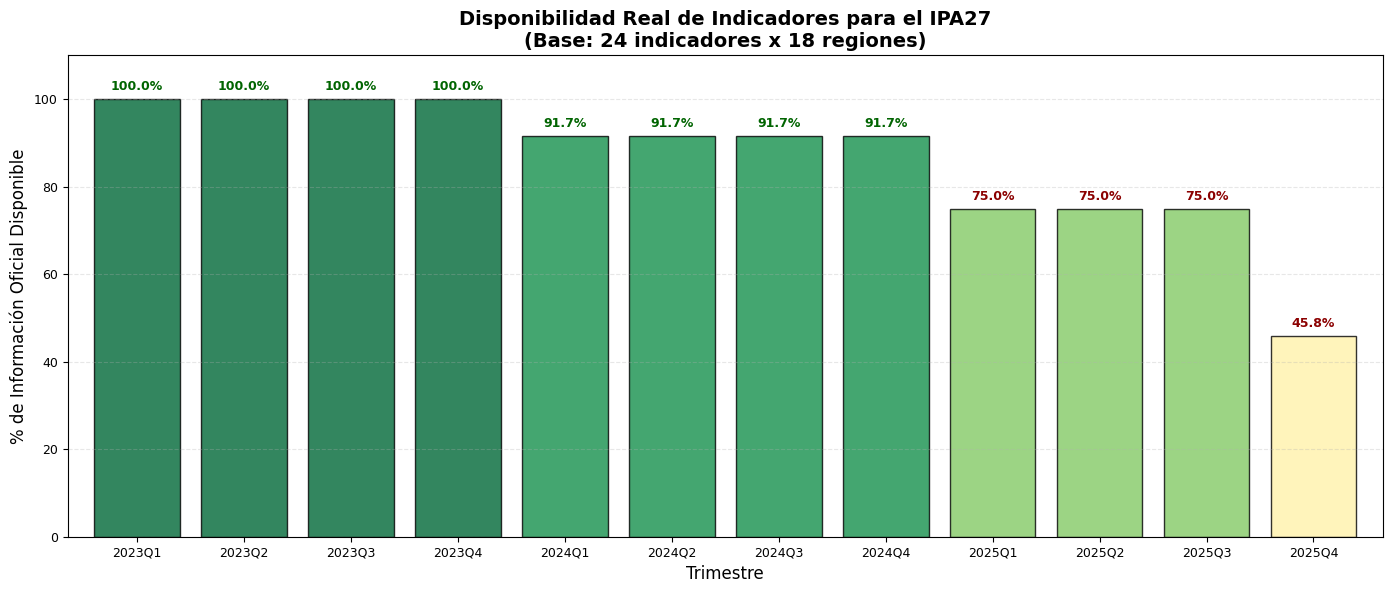

📊 Descenso de disponibilidad: De 100.0% en 2023Q1 a 45.8% en 2025Q4
👉 Este gráfico confirma que solo tenemos cubierto el 45.8% del objetivo mediante datos oficiales.


In [9]:
# %% CELDA: GRÁFICO DE DISPONIBILIDAD (Basado en Inventario Real)
import matplotlib.pyplot as plt
import pandas as pd

print("=" * 60)
print("ANÁLISIS DE DISPONIBILIDAD BASADO EN INVENTARIO")
print("=" * 60)

# 1. Obtener la fecha final de cada indicador (Lógica idéntica a tu Celda 10)
indicadores_fin = {}
for dominio, pilares in ESTRUCTURA.items():
    for pilar, indicadores in pilares.items():
        for ind in indicadores:
            freq, inicio, fin = detectar_frecuencia_y_rango(ind)
            if not fin: continue
            
            # Convertimos cualquier frecuencia al último MES en el que tiene datos
            if freq == 'M': # Mensual
                last_month = pd.Period(year=fin.year, month=fin.month, freq='M')
            elif freq == 'T': # Trimestral (ej: 2025Q3 -> 2025-09)
                last_month = fin.to_timestamp(how='end').to_period('M')
            elif freq == 'A': # Anual (ej: 2024 -> 2024-12)
                last_month = pd.Period(year=int(fin), month=12, freq='M')
            
            indicadores_fin[ind] = last_month

# 2. Crear línea de tiempo mensual (36 meses = 12 trimestres)
# El objetivo es el final del trimestre Q_OBJETIVO
target_month = Q_OBJETIVO.to_timestamp(how='end').to_period('M')
meses_plot = pd.period_range(end=target_month, periods=36, freq='M')

# 3. Calcular disponibilidad por mes
disponibilidad_mensual = []
total_teorico = len(ESTRUCTURA_FLAT := [i for d in ESTRUCTURA.values() for p in d.values() for i in p])

for mes in meses_plot:
    # Contamos cuántos indicadores siguen "vivos" en este mes
    vivos = sum(1 for ind, fin in indicadores_fin.items() if mes <= fin)
    disponibilidad_mensual.append((vivos / total_teorico) * 100)

df_dispo = pd.Series(disponibilidad_mensual, index=meses_plot)

# 4. Agrupar por trimestre para el gráfico (como pediste)
df_trimestral = df_dispo.resample('Q').mean()

# 5. Visualización
plt.figure(figsize=(14, 6))
# Degradado de color según disponibilidad
colors = plt.cm.RdYlGn(df_trimestral.values / 100)

ax = df_trimestral.plot(kind='bar', color=colors, edgecolor='black', alpha=0.8, width=0.8)

plt.title(f"Disponibilidad Real de Indicadores para el IPA27\n(Base: {total_teorico} indicadores x 18 regiones)", 
          fontsize=14, fontweight='bold')
plt.ylabel("% de Información Oficial Disponible", fontsize=12)
plt.xlabel("Trimestre", fontsize=12)
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Etiquetas de valor sobre las barras
for i, v in enumerate(df_trimestral):
    ax.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold', color='darkred' if v < 80 else 'darkgreen')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"📊 Descenso de disponibilidad: De {df_trimestral.iloc[0]:.1f}% en {df_trimestral.index[0]} a {df_trimestral.iloc[-1]:.1f}% en {df_trimestral.index[-1]}")
print(f"👉 Este gráfico confirma que solo tenemos cubierto el {df_trimestral.iloc[-1]:.1f}% del objetivo mediante datos oficiales.")

## 2. Diagnóstico de Cobertura Temporal

Analizamos el estado real de cada serie para determinar qué acciones son necesarias:
- **OK**: La serie llega hasta 2025-Q3
- **EXTENDER**: Necesita nowcasting (ARIMA)
- **TRIMESTRALIZAR**: Serie anual que necesita Chow-Lin/Denton
- **TRIM+EXTENDER**: Anual que además necesita extensión

Este diagnóstico guía el procesamiento posterior.

In [10]:
# %% CELDA 2: DIAGNÓSTICO
print("=" * 60)
print("DIAGNÓSTICO DE COBERTURA TEMPORAL")
print("=" * 60)
print(f"Objetivo: {Q_OBJETIVO}\n")

diagnostico = []

# Función auxiliar para extraer indicador base del nombre de columna
def get_indicador_base(col):
    """Extrae el indicador base de una columna como 'SEG_BAL_AND' → 'SEG_BAL'"""
    parts = col.rsplit('_', 1)
    if len(parts) == 2 and parts[1] in REGIONES:
        return parts[0]
    return None

# Obtener indicadores únicos por frecuencia (usando AND como referencia)
def get_indicadores_unicos(df):
    inds = set()
    for col in df.columns:
        if col.startswith('AUX_'): continue
        if col.endswith('_AND'):
            ind_base = get_indicador_base(col)
            if ind_base:
                inds.add(ind_base)
    return sorted(inds)

# --- MENSUALES ---
print("📊 MENSUALES")
print("-" * 50)
for ind in get_indicadores_unicos(mensual):
    col = f"{ind}_AND"
    if col not in mensual.columns: continue
    
    serie = mensual[col].dropna()
    if len(serie) > 0:
        fin = serie.index.max()
        fin_q = pd.Period(year=fin.year, quarter=(fin.month - 1) // 3 + 1, freq='Q')
        estado = 'OK' if fin_q >= Q_OBJETIVO else 'EXTENDER'
        
        print(f"  {ind:<20} {fin:%Y-%m} (→ {fin_q}) {'✓' if estado == 'OK' else '⚠️'}")
        diagnostico.append({
            'Indicador': ind, 
            'Freq': 'M', 
            'Fin': str(fin_q),
            'Accion': estado
        })

# --- TRIMESTRALES ---
print(f"\n📊 TRIMESTRALES")
print("-" * 50)
for ind in get_indicadores_unicos(trimestral):
    col = f"{ind}_AND"
    if col not in trimestral.columns: continue
    
    serie = trimestral[col].dropna()
    if len(serie) > 0:
        fin = serie.index.max()
        estado = 'OK' if fin >= Q_OBJETIVO else 'EXTENDER'
        
        print(f"  {ind:<20} {fin} {'✓' if estado == 'OK' else '⚠️'}")
        diagnostico.append({
            'Indicador': ind, 
            'Freq': 'T', 
            'Fin': str(fin),
            'Accion': estado
        })

# --- ANUALES ---
print(f"\n📊 ANUALES")
print("-" * 50)
for ind in get_indicadores_unicos(anual):
    col = f"{ind}_AND"
    if col not in anual.columns: continue
    
    serie = anual[col].dropna()
    if len(serie) > 0:
        fin = serie.index.max()
        # Si el año es 2025, solo trimestralizar. Si es anterior, también extender.
        if fin >= 2025:
            estado = 'TRIMESTRALIZAR'
        else:
            estado = 'TRIM+EXTENDER'
        
        metodo = CHOWLIN_CONFIG.get(ind, None)
        metodo_str = f"(Chow-Lin: {metodo})" if metodo else "(Denton)"
        
        print(f"  {ind:<20} {fin} → {estado} {metodo_str}")
        diagnostico.append({
            'Indicador': ind, 
            'Freq': 'A', 
            'Fin': str(fin),
            'Accion': estado
        })

# --- RESUMEN ---
df_diag = pd.DataFrame(diagnostico)

print(f"\n" + "=" * 60)
print("RESUMEN")
print("=" * 60)
for accion in ['OK', 'EXTENDER', 'TRIMESTRALIZAR', 'TRIM+EXTENDER']:
    n = len(df_diag[df_diag['Accion'] == accion])
    if n > 0:
        indicadores = df_diag[df_diag['Accion'] == accion]['Indicador'].tolist()
        print(f"  {accion:<16}: {n} → {indicadores}")

print(f"\n✓ Diagnóstico completado")


DIAGNÓSTICO DE COBERTURA TEMPORAL
Objetivo: 2025Q4

📊 MENSUALES
--------------------------------------------------
  CON_OCI              2025-12 (→ 2025Q4) ✓
  EMP_SOC              2025-12 (→ 2025Q4) ✓
  GOB_DES              2025-12 (→ 2025Q4) ✓
  INF_TRA              2025-12 (→ 2025Q4) ✓
  INV_HIP              2025-12 (→ 2025Q4) ✓
  SOC_ASO              2025-12 (→ 2025Q4) ✓

📊 TRIMESTRALES
--------------------------------------------------
  ECO_COL_sal          2025Q3 ⚠️
  ECO_PIBpc            2025Q3 ⚠️
  ECO_RBHpc            2025Q4 ✓
  EDU_SUP              2025Q4 ✓
  GOB_EFF              2025Q3 ⚠️
  INV_IED              2025Q3 ⚠️
  LIB_SEX              2025Q3 ⚠️
  SAL_SAT_enlazado     2025Q3 ⚠️
  SEG_BAL              2025Q3 ⚠️
  SEG_CRI              2025Q3 ⚠️
  VID_PAR              2025Q4 ✓

📊 ANUALES
--------------------------------------------------
  CON_IDI              2024 → TRIM+EXTENDER (Chow-Lin: {'rel': 'ECO_RBHpc', 'tipo': 'stock'})
  EDU_ABA              2024 → TRIM+EXT

## 4. Funciones Auxiliares

Definimos las funciones principales del pipeline:

| Función | Propósito |
|---------|-----------|
| `desestacionalizar()` | STL + detección de outliers |
| `chowlin()` | Trimestralización con indicador relacionado |
| `denton_spline()` | Trimestralización sin indicador (fallback) |
| `extender_arima()` | Nowcasting con ARIMA automático |

In [11]:
# %% CELDA 5: FUNCIONES AUXILIARES
print("=" * 60)
print("DEFINICIÓN DE FUNCIONES")
print("=" * 60)

# =============================================================================
# DESESTACIONALIZACIÓN
# =============================================================================
def desestacionalizar(serie, periodo=12, umbral_outlier=3.0, corregir_outliers=False):
    """
    Desestacionaliza con STL.
    
    Parámetros:
    -----------
    corregir_outliers : bool
        Si True, reemplaza outliers por tendencia.
        Si False, solo los detecta pero mantiene valores originales.
    """
    serie = serie.dropna()
    if len(serie) < periodo * 2:
        return serie, {'outliers': [], 'cv_estacional': 0}
    
    # STL
    stl = STL(serie, period=periodo, robust=True)
    res = stl.fit()
    
    # Detectar outliers en residuo
    residuo = res.resid
    mu, sigma = residuo.mean(), residuo.std()
    mask_outlier = np.abs(residuo - mu) > umbral_outlier * sigma
    outliers = residuo[mask_outlier].index.tolist()
    
    # Serie desestacionalizada = tendencia + residuo
    sa = res.trend + res.resid
    
    # Reemplazar outliers por tendencia SOLO si se pide
    if corregir_outliers and len(outliers) > 0:
        sa.loc[outliers] = res.trend.loc[outliers]
    
    # Coeficiente de variación estacional
    cv = (res.seasonal.std() / serie.mean() * 100) if serie.mean() != 0 else 0
    
    info = {
        'outliers': outliers,
        'cv_estacional': cv,
        'tendencia': res.trend,
        'estacional': res.seasonal
    }
    
    return sa, info

# =============================================================================
# CHOW-LIN
# =============================================================================
def chowlin_con_betas(y_anual, x_trimestral, rho=0.5, tipo='flujo'):
    """
    Chow-Lin que soporta flujos (suma) y stocks (media).
    
    tipo='flujo': suma de 4 trimestres = valor anual
    tipo='stock': media de 4 trimestres = valor anual
    """
    y_anual = y_anual.dropna()
    años = list(y_anual.index)
    n_años = len(años)
    n_trim = n_años * 4
    
    # Matriz de agregación C
    C = np.zeros((n_años, n_trim))
    for i in range(n_años):
        if tipo == 'stock':
            C[i, i*4:(i+1)*4] = 0.25  # Media
        else:
            C[i, i*4:(i+1)*4] = 1     # Suma
    
    x_trim_arr = []
    for año in años:
        for q in [1, 2, 3, 4]:
            per = pd.Period(year=año, quarter=q, freq='Q')
            if per in x_trimestral.index:
                x_trim_arr.append(float(x_trimestral.loc[per]))
            else:
                x_trim_arr.append(np.nan)
    
    x_trim_arr = np.array(x_trim_arr)
    if np.isnan(x_trim_arr).any():
        x_s = pd.Series(x_trim_arr).interpolate().ffill().bfill()
        x_trim_arr = x_s.values
    
    X = np.column_stack([np.ones(n_trim), x_trim_arr])
    y = y_anual.values.astype(float)
    
    V = np.array([[rho**abs(i-j) for j in range(n_trim)] for i in range(n_trim)])
    
    CVC = C @ V @ C.T
    CVC_inv = linalg.inv(CVC)
    X_anual = C @ X
    beta = linalg.inv(X_anual.T @ CVC_inv @ X_anual) @ X_anual.T @ CVC_inv @ y
    
    u_anual = y - X_anual @ beta
    L = V @ C.T @ CVC_inv
    u_trim = L @ u_anual
    y_trim = X @ beta + u_trim
    
    periodos = [pd.Period(year=año, quarter=q, freq='Q') for año in años for q in [1,2,3,4]]
    
    return pd.Series(y_trim, index=pd.PeriodIndex(periodos)), beta

# =============================================================================
# DENTON (FALLBACK)
# =============================================================================
def denton_spline(y_anual):
    """
    Desagregación Denton con spline cúbico.
    
    Usa interpolación suave cuando no hay indicador relacionado.
    Ajusta para que la media anual coincida con el valor original.
    
    Parámetros:
    -----------
    y_anual : pd.Series
        Serie anual (índice = años como int)
    
    Retorna:
    --------
    pd.Series con índice PeriodIndex trimestral
    """
    y_anual = y_anual.dropna()
    años = list(y_anual.index)
    valores = y_anual.values.astype(float)
    
    if len(años) < 2:
        # Solo 1 año: distribuir uniforme
        periodos = [pd.Period(year=años[0], quarter=q, freq='Q') for q in [1,2,3,4]]
        return pd.Series([valores[0]]*4, index=pd.PeriodIndex(periodos))
    
    # Puntos de anclaje: centro del año
    x_anclaje = [año + 0.5 for año in años]
    cs = CubicSpline(x_anclaje, valores, bc_type='natural')
    
    # Evaluar en cada trimestre
    periodos, vals = [], []
    for año in años:
        for q in [1, 2, 3, 4]:
            t = año + (q - 0.5) / 4
            periodos.append(pd.Period(year=año, quarter=q, freq='Q'))
            vals.append(cs(t))
    
    serie = pd.Series(vals, index=pd.PeriodIndex(periodos))
    
    # Ajustar para que media anual = valor original
    for i, año in enumerate(años):
        mask = serie.index.year == año
        media = serie[mask].mean()
        if media != 0:
            serie.loc[mask] *= valores[i] / media
    
    return serie

# =============================================================================
# EXTENSIÓN ARIMA
# =============================================================================
def extender_arima(serie, hasta, max_intentos=3):
    """
    Extiende una serie hasta un periodo objetivo usando ARIMA.
    
    Parámetros:
    -----------
    serie : pd.Series
        Serie con índice PeriodIndex
    hasta : pd.Period
        Periodo objetivo (ej: Period('2025Q3'))
    max_intentos : int
        Intentos con diferentes configuraciones si falla
    
    Retorna:
    --------
    pd.Series extendida
    """
    from pmdarima import auto_arima
    
    serie = serie.dropna()
    if len(serie) == 0:
        return serie
    
    ultimo = serie.index[-1]
    
    if ultimo >= hasta:
        return serie
    
    # Calcular periodos a pronosticar
    n = int((hasta.year - ultimo.year) * 4 + (hasta.quarter - ultimo.quarter))
    if n <= 0:
        return serie
    
    # Intentar ARIMA
    try:
        modelo = auto_arima(
            serie.values, 
            seasonal=False, 
            stepwise=True,
            suppress_warnings=True, 
            error_action='ignore',
            max_p=3, max_q=3, max_d=2
        )
        forecast = modelo.predict(n_periods=n)
    except:
        # Fallback: último valor (LOCF)
        forecast = [serie.iloc[-1]] * n
    
    # Crear índice para extensión
    nuevos_idx = pd.period_range(start=ultimo + 1, periods=n, freq='Q')
    
    return pd.concat([serie, pd.Series(forecast, index=nuevos_idx)])

print("  ✓ desestacionalizar(serie, periodo, umbral)")
print("  ✓ chowlin_con_betas(y_anual, x_trimestral, rho, tipo)")
print("  ✓ denton_spline(y_anual)")
print("  ✓ extender_arima(serie, hasta)")
print("\n✓ Funciones definidas")


DEFINICIÓN DE FUNCIONES
  ✓ desestacionalizar(serie, periodo, umbral)
  ✓ chowlin_con_betas(y_anual, x_trimestral, rho, tipo)
  ✓ denton_spline(y_anual)
  ✓ extender_arima(serie, hasta)

✓ Funciones definidas


## 5. Desestacionalización

Aplicamos STL (Seasonal-Trend decomposition using LOESS) a las series con patrón estacional:

**Mensuales** (periodo=12): EMP_SOC, INF_TRA, INV_HIP

**Trimestrales** (periodo=4): INV_IED, LIB_SEX, SEG_BAL, SEG_CRI

El proceso:
1. Descompone en tendencia + estacionalidad + residuo
2. Detecta outliers (residuos > 3σ)
3. Reemplaza outliers por tendencia
4. Retorna serie ajustada = tendencia + residuo

In [12]:
# %% CELDA 6: DESESTACIONALIZACIÓN
print("=" * 60)
print("DESESTACIONALIZACIÓN (18 Regiones)")
print("=" * 60)

# Guardar originales para comparación
mensual_orig = mensual.copy()
trimestral_orig = trimestral.copy()

# Añadir INV_IED a trimestrales si no está
DESEST_TRIMESTRAL_FULL = list(set(DESEST_TRIMESTRAL + ['INV_IED']))

info_desest = {}
n_series_procesadas = 0

# --- SERIES MENSUALES ---
print("\n📊 MENSUALES (periodo=12)")
print("-" * 40)

for ind in DESEST_MENSUAL:
    for terr in REGIONES:
        col = f"{ind}_{terr}"
        if col not in mensual.columns:
            continue
        
        serie_orig = mensual[col]
        if serie_orig.dropna().empty:
            continue
            
        sa, info = desestacionalizar(serie_orig, periodo=12)
        
        # Guardar serie ajustada
        mensual[col] = sa.reindex(mensual.index)
        info_desest[col] = info
        n_series_procesadas += 1
        
        # Solo mostrar detalle para AND y ESP
        if terr in ['AND', 'ESP']:
            n_out = len(info['outliers'])
            cv = info['cv_estacional']
            print(f"  {col}: CV={cv:.1f}%, outliers={n_out}", end="")
            if n_out > 0:
                fechas_out = [str(o.date()) for o in info['outliers'][:3]]
                print(f" → {fechas_out}")
            else:
                print()

# Resumen por indicador mensual
for ind in DESEST_MENSUAL:
    n_reg = sum(1 for r in REGIONES if f"{ind}_{r}" in info_desest)
    print(f"  → {ind}: {n_reg} regiones procesadas")

# --- SERIES TRIMESTRALES ---
print("\n📊 TRIMESTRALES (periodo=4)")
print("-" * 40)

for ind in DESEST_TRIMESTRAL_FULL:
    for terr in REGIONES:
        col = f"{ind}_{terr}"
        if col not in trimestral.columns:
            continue
        
        serie_orig = trimestral[col]
        if serie_orig.dropna().empty:
            continue
        
        # Convertir Period a Timestamp para STL
        serie_ts = serie_orig.copy()
        serie_ts.index = serie_ts.index.to_timestamp()
        
        sa, info = desestacionalizar(serie_ts, periodo=4)
        
        # Reconvertir a Period
        sa.index = sa.index.to_period('Q')
        trimestral[col] = sa.reindex(trimestral.index)
        info_desest[col] = info
        n_series_procesadas += 1
        
        # Solo mostrar detalle para AND y ESP
        if terr in ['AND', 'ESP']:
            n_out = len(info['outliers'])
            cv = info['cv_estacional']
            print(f"  {col}: CV={cv:.1f}%, outliers={n_out}", end="")
            if n_out > 0:
                fechas_out = [str(o.date()) for o in info['outliers'][:3]]
                print(f" → {fechas_out}")
            else:
                print()

# Resumen por indicador trimestral
for ind in DESEST_TRIMESTRAL_FULL:
    n_reg = sum(1 for r in REGIONES if f"{ind}_{r}" in info_desest)
    if n_reg > 0:
        print(f"  → {ind}: {n_reg} regiones procesadas")

print(f"\n✓ Desestacionalización completada ({n_series_procesadas} series en {len(info_desest)} columnas)")


DESESTACIONALIZACIÓN (18 Regiones)

📊 MENSUALES (periodo=12)
----------------------------------------
  EMP_SOC_ESP: CV=14.8%, outliers=4 → ['2020-03-01', '2020-04-01', '2020-05-01']
  EMP_SOC_AND: CV=15.5%, outliers=5 → ['2020-03-01', '2020-04-01', '2020-05-01']
  INF_TRA_ESP: CV=9.7%, outliers=4 → ['2020-02-01', '2020-03-01', '2020-04-01']
  INF_TRA_AND: CV=10.0%, outliers=3 → ['2020-03-01', '2020-04-01', '2020-05-01']
  INV_HIP_ESP: CV=8.7%, outliers=6 → ['2011-02-01', '2019-09-01', '2019-12-01']
  INV_HIP_AND: CV=9.0%, outliers=3 → ['2011-03-01', '2018-08-01', '2019-09-01']
  SOC_ASO_ESP: CV=0.7%, outliers=5 → ['2020-04-01', '2020-05-01', '2020-06-01']
  SOC_ASO_AND: CV=1.0%, outliers=6 → ['2020-02-01', '2020-06-01', '2021-03-01']
  CON_OCI_ESP: CV=0.5%, outliers=5 → ['2020-01-01', '2020-02-01', '2020-04-01']
  CON_OCI_AND: CV=0.5%, outliers=6 → ['2020-04-01', '2020-05-01', '2020-06-01']
  → EMP_SOC: 18 regiones procesadas
  → INF_TRA: 18 regiones procesadas
  → INV_HIP: 18 regione

## 5B. Visualización: Original vs Desestacionalizado

Comparamos las series antes y después de aplicar STL:
- **Gris**: Serie original
- **Color**: Serie desestacionalizada
- **Puntos rojos**: Outliers detectados y corregidos

VISUALIZACIÓN: ORIGINAL vs DESESTACIONALIZADO (ESP y AND)

✓ Gráfico guardado: results/figures/analysis/ipa27_desestacionalizacion_esp_and.png


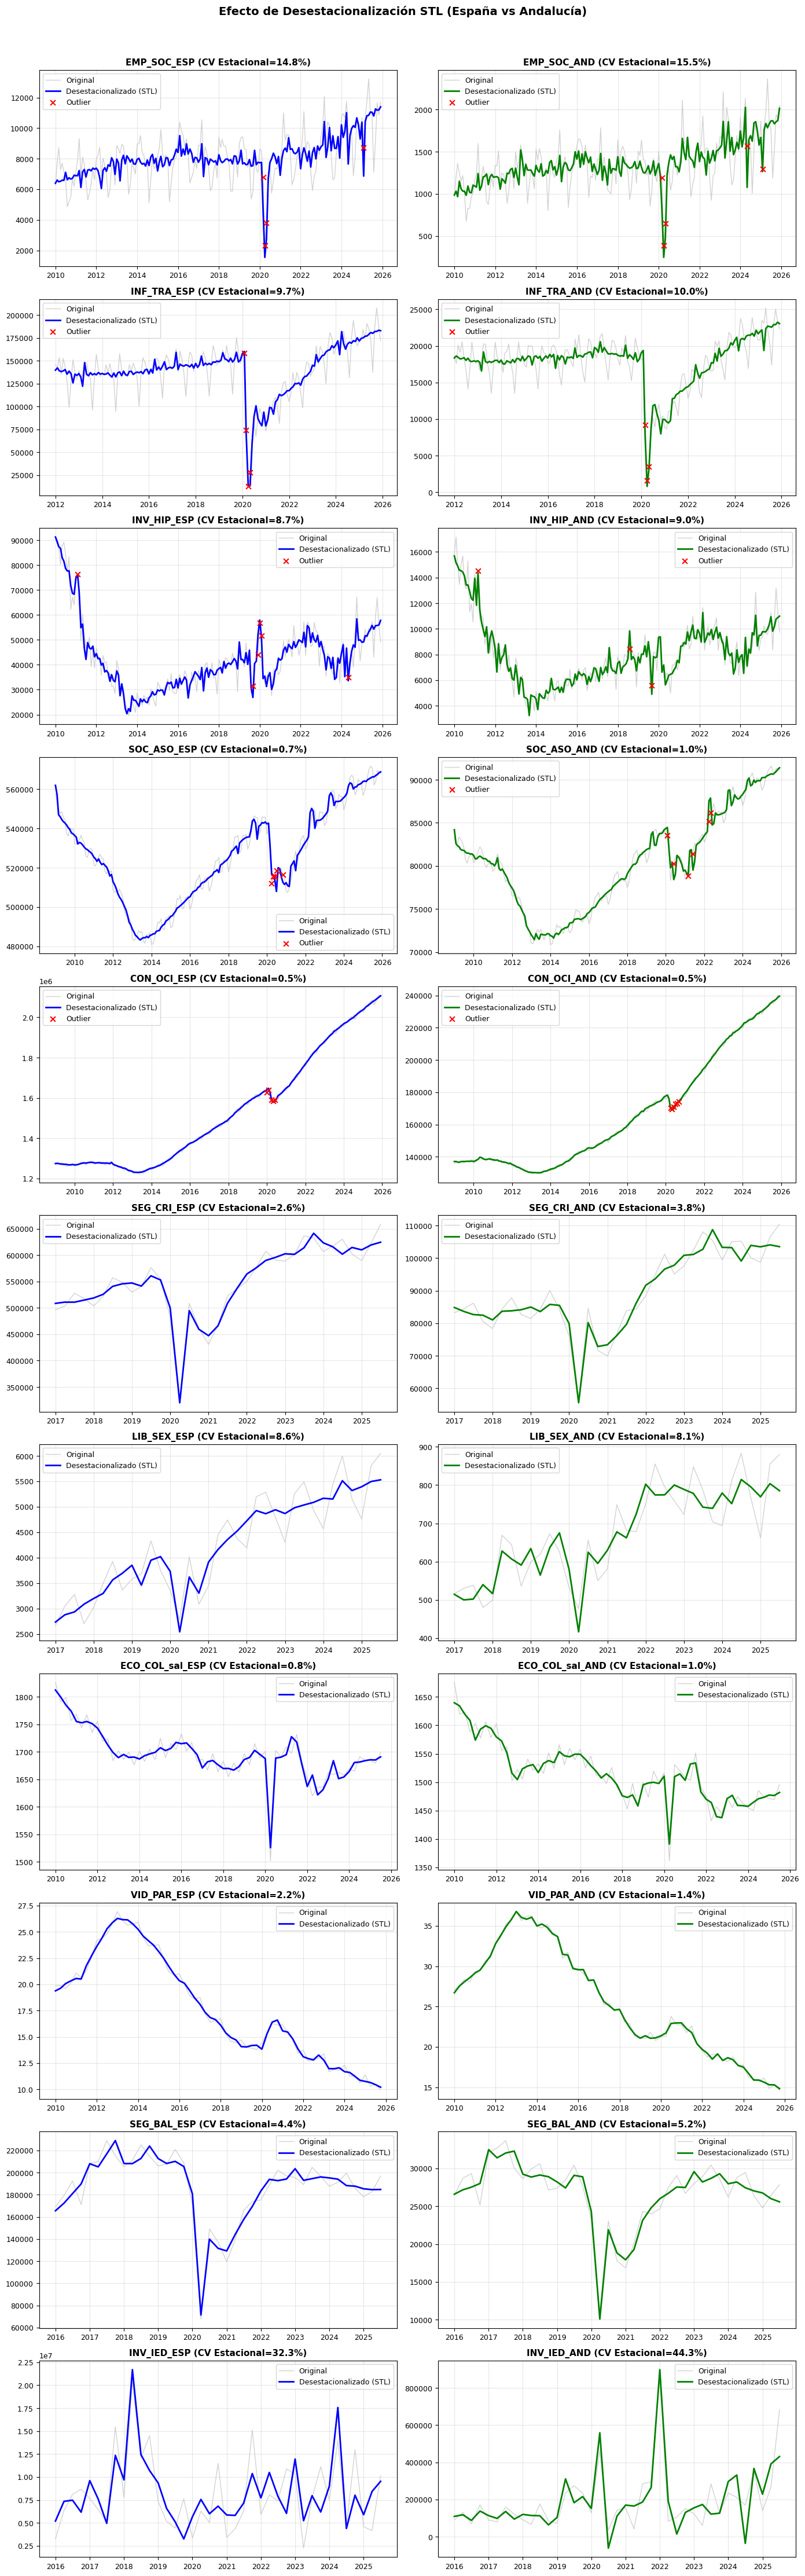

In [13]:
# %% CELDA 6B: VISUALIZACIÓN DESESTACIONALIZACIÓN (SOLO ESP Y AND)
import matplotlib.pyplot as plt
import numpy as np

print("=" * 60)
print("VISUALIZACIÓN: ORIGINAL vs DESESTACIONALIZADO (ESP y AND)")
print("=" * 60)

# Filtrar solo series de ESP y AND
series_desest = [k for k in info_desest.keys() if k.endswith('_ESP') or k.endswith('_AND')]
n_series = len(series_desest)

if n_series == 0:
    print("⚠️ No hay series desestacionalizadas para visualizar.")
else:
    # Configuración de subplots (2 columnas)
    n_cols = 2
    n_rows = int(np.ceil(n_series / n_cols))
    
    # Ajustar altura para que no quede comprimido
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(series_desest):
        ax = axes[i]
        
        # Determinar si es mensual o trimestral
        if col in mensual.columns:
            orig = mensual_orig[col].dropna()
            desest = mensual[col].dropna()
            freq = 'M'
        else:
            orig = trimestral_orig[col].dropna()
            desest = trimestral[col].dropna()
            freq = 'T'
        
        # Convertir índice para plotear (Timestamp para matplotlib)
        if freq == 'T':
            x_orig = orig.index.to_timestamp()
            x_desest = desest.index.to_timestamp()
        else:
            x_orig = orig.index
            x_desest = desest.index
        
        # Plot Original (Gris tenue con marcadores para ver los datos reales)
        ax.plot(x_orig, orig.values, color='silver', alpha=0.7, linewidth=1, label='Original')
        
        # Plot Desestacionalizado (Color fuerte)
        color = 'green' if col.endswith('_AND') else 'blue'  # Verde Andalucía, Azul España
        ax.plot(x_desest, desest.values, color=color, linewidth=2, label='Desestacionalizado (STL)')
        
        # Marcar outliers detectados (si los hay)
        if 'outliers' in info_desest[col]:
            outliers = info_desest[col]['outliers']
            if len(outliers) > 0:
                # Filtrar outliers que estén en el índice
                idx_outliers = []
                val_outliers = []
                for o in outliers:
                    ot = o if freq == 'M' else o # En este contexto simple
                    # STL devuelve timestamps generalmente
                    # Buscamos correspondencia aproximada o exacta
                    try:
                        if ot in orig.index:
                            idx_outliers.append(ot.to_timestamp() if freq=='T' else ot)
                            val_outliers.append(orig.loc[ot])
                    except: pass
                
                if idx_outliers:
                    ax.scatter(idx_outliers, val_outliers, color='red', s=40, zorder=5, marker='x', label='Outlier')
        
        # Títulos y Leyenda
        cv = info_desest[col]['cv_estacional']
        ax.set_title(f"{col} (CV Estacional={cv:.1f}%)", fontsize=11, fontweight='bold')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
        
    # Ocultar ejes vacíos si sobran cuadros
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle('Efecto de Desestacionalización STL (España vs Andalucía)', 
                 fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    
    # Guardar
    import os
    os.makedirs('results/figures/analysis', exist_ok=True)
    plt.savefig('results/figures/analysis/ipa27_desestacionalizacion_esp_and.png', dpi=150, bbox_inches='tight', facecolor='white')
    print("\n✓ Gráfico guardado: results/figures/analysis/ipa27_desestacionalizacion_esp_and.png")
    plt.show()


VISUALIZACIÓN DOBLE EJE: ESP (Azul) vs AND (Rojo)


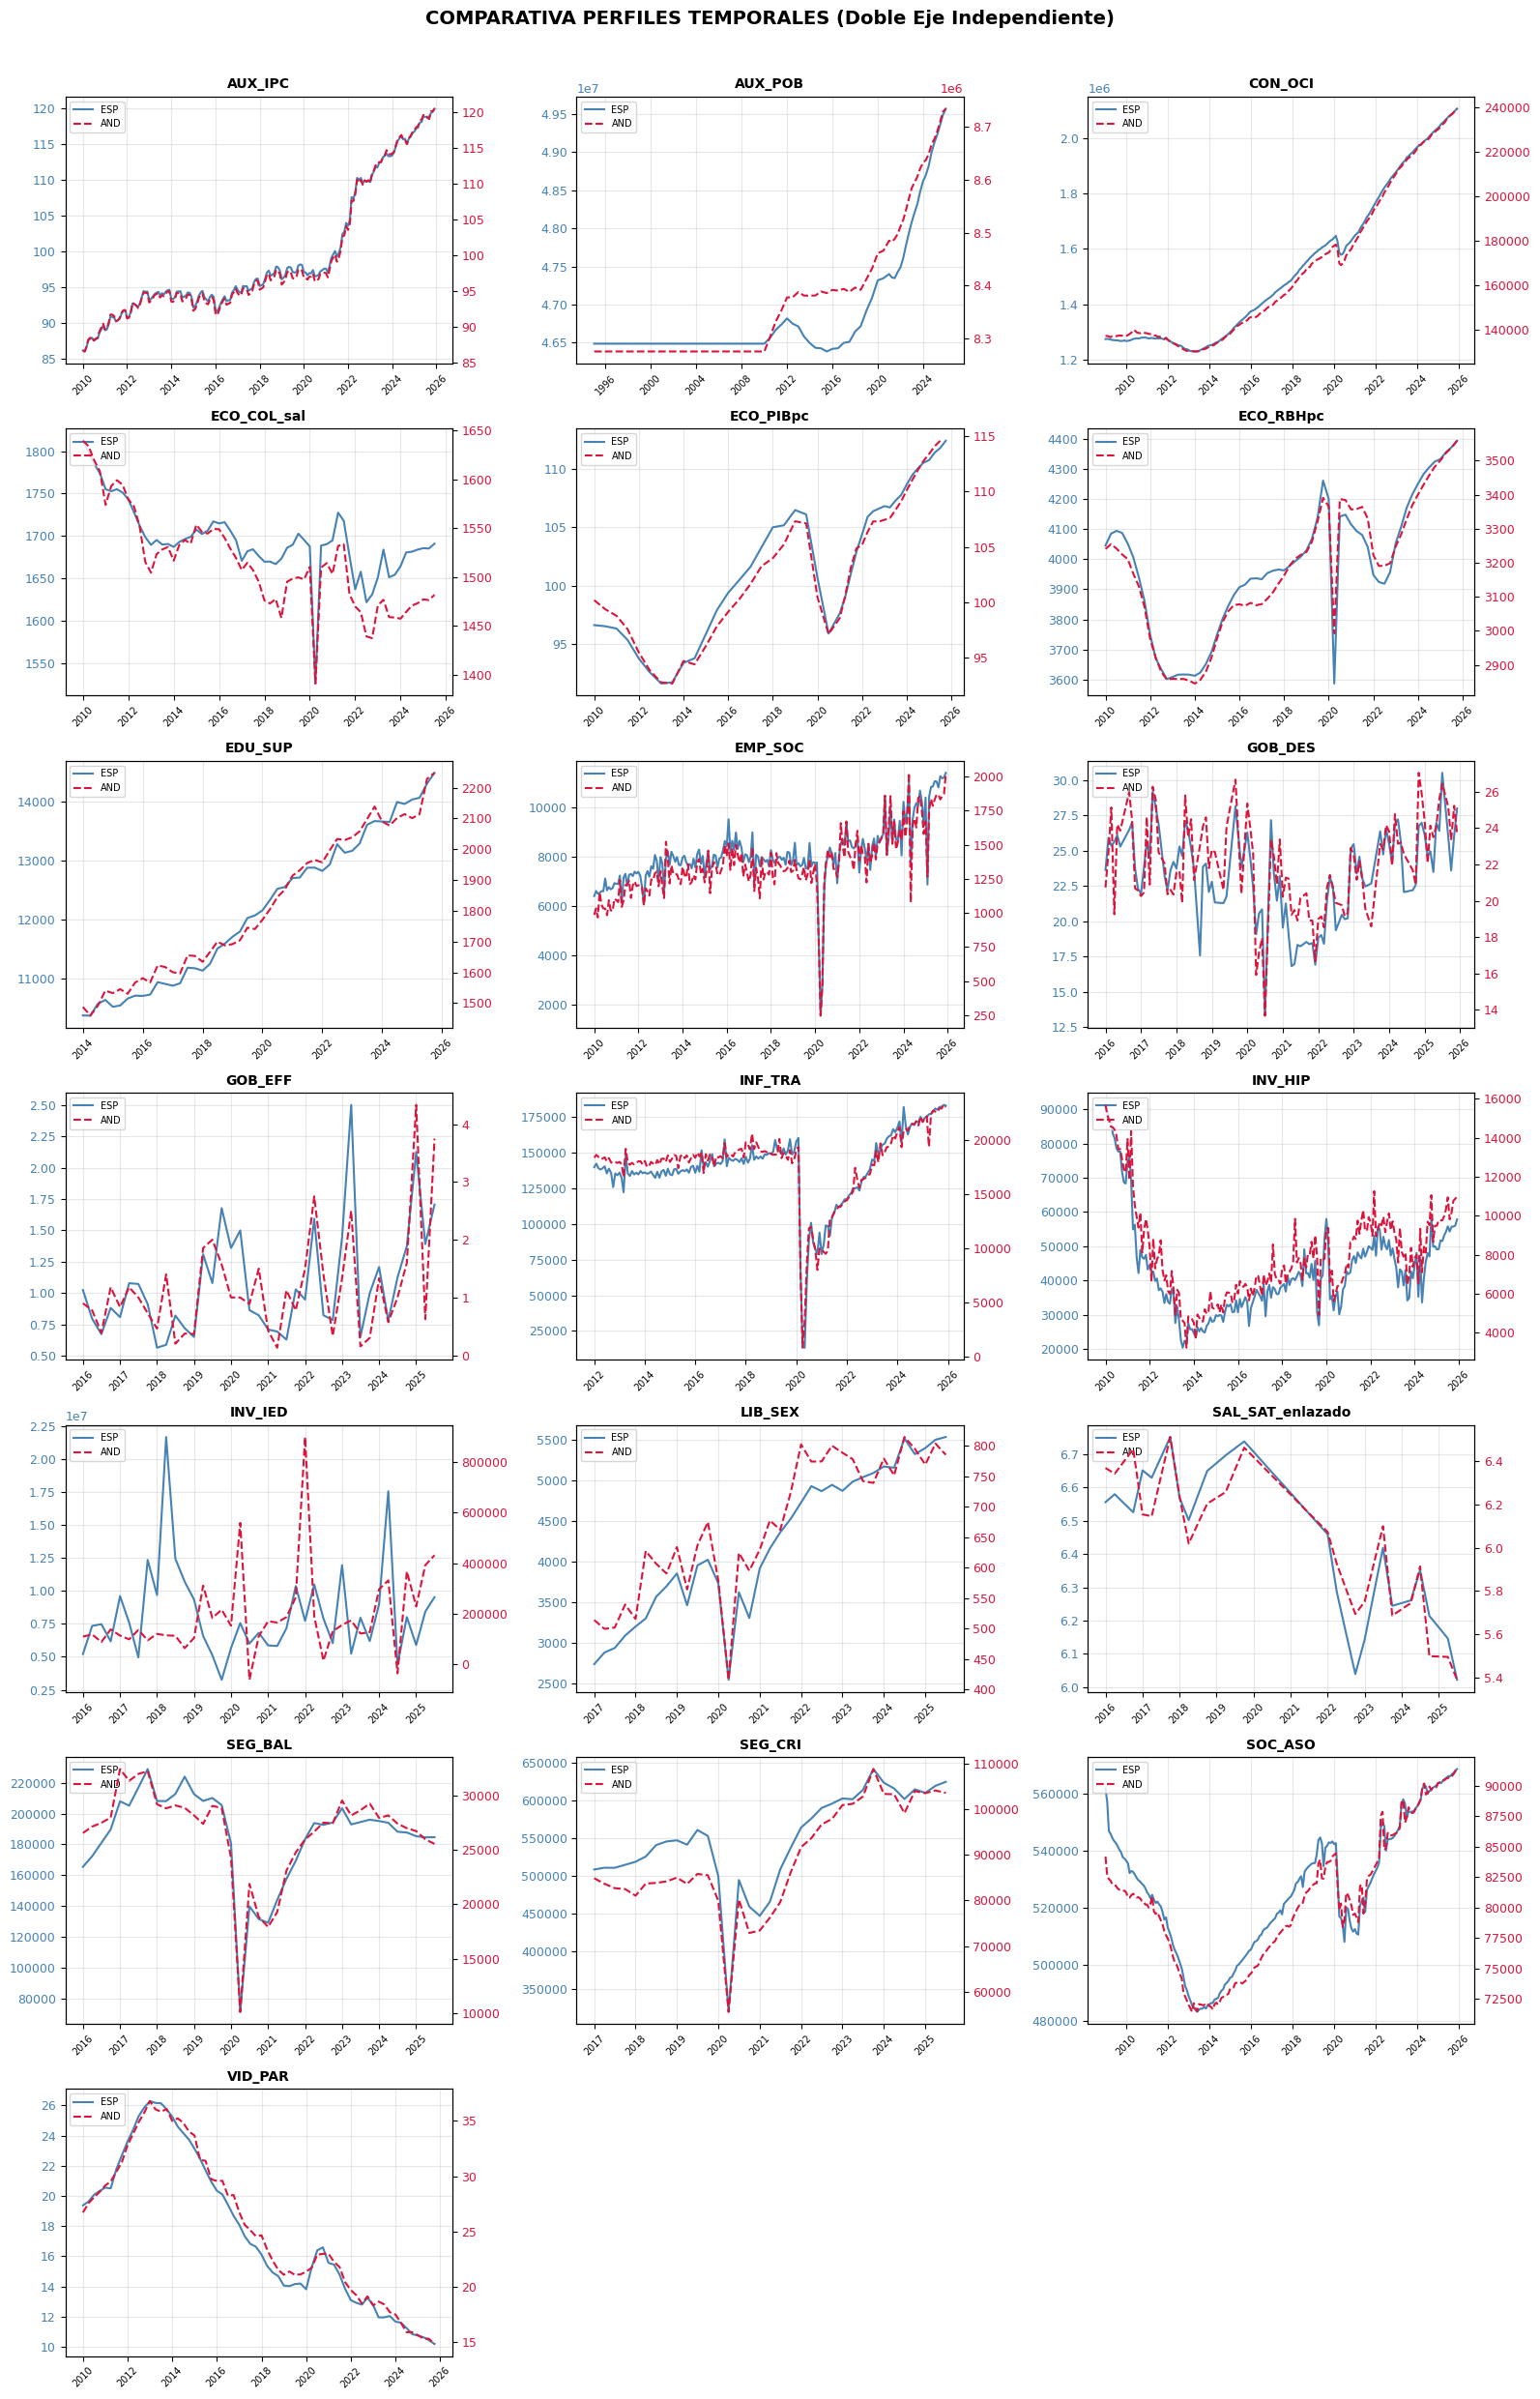

In [14]:
# %% CELDA 6B MODIFICADA: DOBLE EJE Y (ESP vs AND)
import matplotlib.pyplot as plt
import numpy as np

print("=" * 60)
print("VISUALIZACIÓN DOBLE EJE: ESP (Azul) vs AND (Rojo)")
print("=" * 60)

cols_mensuales = [c for c in mensual.columns if c.endswith('_ESP') or c.endswith('_AND')]
cols_trimestrales = [c for c in trimestral.columns if c.endswith('_ESP') or c.endswith('_AND') if c not in cols_mensuales]
todas_cols = cols_mensuales + cols_trimestrales
indicadores_unicos = sorted(list(set([c.rsplit('_', 1)[0] for c in todas_cols])))

n_cols = 3
n_rows = int(np.ceil(len(indicadores_unicos) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
axes = axes.flatten()

for i, ind in enumerate(indicadores_unicos):
    ax1 = axes[i]
    col_esp = f"{ind}_ESP"
    col_and = f"{ind}_AND"
    
    # Eje Izquierdo (ESP) - Azul
    has_esp = False
    if col_esp in mensual.columns:
        s = mensual[col_esp].dropna()
        if not s.empty:
            ax1.plot(s.index, s.values, color='steelblue', label='ESP', linewidth=1.5)
            has_esp = True
    elif col_esp in trimestral.columns:
        s = trimestral[col_esp].dropna()
        if not s.empty:
            idx = s.index.to_timestamp() if hasattr(s.index, 'to_timestamp') else s.index
            ax1.plot(idx, s.values, color='steelblue', label='ESP', linewidth=1.5)
            has_esp = True
            
    # Eje Derecho (AND) - Rojo
    ax2 = ax1.twinx()
    has_and = False
    if col_and in mensual.columns:
        s = mensual[col_and].dropna()
        if not s.empty:
            ax2.plot(s.index, s.values, color='crimson', label='AND', linewidth=1.5, linestyle='--')
            has_and = True
    elif col_and in trimestral.columns:
        s = trimestral[col_and].dropna()
        if not s.empty:
            idx = s.index.to_timestamp() if hasattr(s.index, 'to_timestamp') else s.index
            ax2.plot(idx, s.values, color='crimson', label='AND', linewidth=1.5, linestyle='--')
            has_and = True
    
    # Estética
    ax1.set_title(ind, fontsize=10, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45, labelsize=7)
    ax1.grid(True, alpha=0.3)
    
    # Colorear ejes para saber cual es cual
    ax1.tick_params(axis='y', labelcolor='steelblue')
    if has_and:
        ax2.tick_params(axis='y', labelcolor='crimson')
    else:
        ax2.set_visible(False) # Ocultar eje derecho si no hay Andalucía

    # Leyenda unificada (truco para twinx)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    if lines1 or lines2:
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=7)

# Ocultar vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"COMPARATIVA PERFILES TEMPORALES (Doble Eje Independiente)", 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 6. Trimestralización

Convertimos todas las series a frecuencia trimestral:

### Mensuales → Trimestrales
- **Método**: Media de los 3 meses del trimestre
- **Resultado**: Series hasta 2025-Q3 (Q4 incompleto se descarta)

### Anuales → Trimestrales
- **Método principal**: Chow-Lin con indicador relacionado
- **Fallback**: Denton (spline cúbico) si no hay indicador

| Anual | Relacionado | Correlación |
|-------|-------------|-------------|
| CON_IDI | ECO_PIT | +0.64 |
| EDU_ABA | EDU_SUP | -0.96 |
| EMP_NAT | INF_TRA | +0.71 |
| INF_BAN | EDU_SUP | +0.94 |
| LIB_ODI | SEG_CRI | +0.77 |
| SAL_ESP | ECO_PIT | +0.88 |
| SOC_PAR_enlazado | EMP_SOC | -0.74 |
| VID_ARO | EDU_SUP | -0.71 |

In [15]:
# %% CELDA 7: TRIMESTRALIZACIÓN (ADAPTADA V2)
print("=" * 60)
print("TRIMESTRALIZACIÓN (V2 - Adaptada a estructura RBHpc)")
print("=" * 60)

# =============================================================================
# PASO 1: MENSUALES -> TRIMESTRALES
# =============================================================================
print("\n📊 PASO 1: Mensuales -> Trimestrales (agregación)")
print("-" * 50)

# Resample y filtrado
# Separar variables mensuales en flujo (suma) y stock (media)
mensuales_flujo = ['INV_HIP', 'EMP_SOC', 'INF_TRA']
mensuales_stock = ['GOB_DES', 'SOC_ASO', 'CON_OCI']

cols_flujo = [c for c in mensual.columns if any(c.startswith(ind) for ind in mensuales_flujo)]
cols_stock = [c for c in mensual.columns if any(c.startswith(ind) for ind in mensuales_stock)]
cols_resto = [c for c in mensual.columns if c not in cols_flujo and c not in cols_stock]

df_trims = []
if cols_flujo: df_trims.append(mensual[cols_flujo].resample('Q').sum())
if cols_stock: df_trims.append(mensual[cols_stock].resample('Q').mean())
if cols_resto: df_trims.append(mensual[cols_resto].resample('Q').mean())

if df_trims:
    mensual_trim = __import__('pandas').concat(df_trims, axis=1)
else:
    mensual_trim = mensual.resample('Q').mean()
mensual_trim.index = mensual_trim.index.to_period('Q')
mensual_trim = mensual_trim[mensual_trim.index <= Q_OBJETIVO]

print(f"  {len(mensual)} meses -> {len(mensual_trim)} trimestres")
print(f"  Rango: {mensual_trim.index.min()} -> {mensual_trim.index.max()}")

# =============================================================================
# PASO 2: ANUALES -> TRIMESTRALES (Chow-Lin / Denton)
# =============================================================================
print("\n📊 PASO 2: Anuales -> Trimestrales (Chow-Lin / Denton)")
print("-" * 50)
print("  Nota: ECO_RBHpc ya fue procesado en fase de Carga (Celda 2B)")

anuales_trim = {}
chowlin_betas = {}

# Lista de indicadores anuales a procesar
cols_anuales = [c for c in anual.columns if not c.startswith('AUX_')]
indicadores_anuales = sorted(list(set([c.rsplit('_', 1)[0] for c in cols_anuales])))

for ind in indicadores_anuales:
    # Saltar ECO_PIT o ECO_RBHpc si aparecieran en anual (ya tratados)
    if 'ECO_RBH' in ind or 'ECO_PIT' in ind:
        continue
    
    for terr in REGIONES:
        col = f"{ind}_{terr}"
        
        # Si ya existe en trimestral y está completa, saltar
        if col in trimestral.columns and not trimestral[col].dropna().empty:
            continue
            
        if col not in anual.columns:
            continue
            
        y_anual = anual[col].dropna()
        if len(y_anual) < 2:
            continue
            
        # Buscar configuración Chow-Lin
        config = CHOWLIN_CONFIG.get(ind, None)
        serie_trim = None
        
        if config:
            ind_rel = config['rel']
            # Mapeo de seguridad: Si la config pide ECO_PIT, le damos ECO_RBHpc
            if ind_rel == 'ECO_PIT': ind_rel = 'ECO_RBHpc'
            
            tipo = config.get('tipo', 'flujo')
            col_rel = f"{ind_rel}_{terr}"
            
            # Buscar indicador relacionado (benchmark)
            x_trim = None
            if col_rel in trimestral.columns:
                x_trim = trimestral[col_rel].dropna()
            elif col_rel in mensual_trim.columns:
                x_trim = mensual_trim[col_rel].dropna()
                
            if x_trim is not None and len(x_trim) >= 4:
                try:
                    # Usamos la función robusta (si está definida) o la simple
                    # Preferible usar chowlin_con_betas si existe (Celda 6)
                    if 'chowlin_con_betas' in globals():
                        serie_trim, beta = chowlin_con_betas(y_anual, x_trim, rho=0.5, tipo=tipo)
                        info_beta = beta[1]
                    elif 'chow_lin_ar1' in globals():
                        serie_trim = chow_lin_ar1(y_anual, x_trim)
                        info_beta = 0 # No devuelve beta esta versión
                    
                    if serie_trim is not None:
                        anuales_trim[col] = serie_trim
                        chowlin_betas[col] = {'ind_rel': ind_rel, 'tipo': tipo}
                        if terr in ['AND', 'ESP']:
                            print(f"  ✓ {col}: Chow-Lin {tipo} (con {ind_rel})")
                except Exception as e:
                    if terr in ['AND', 'ESP']:
                        print(f"  ⚠️ {col}: Chow-Lin falló ({e}), fallback Denton")
        
        # Fallback Denton
        if serie_trim is None:
            if 'denton_spline' in globals():
                 anuales_trim[col] = denton_spline(y_anual)
                 if terr in ['AND', 'ESP']:
                     print(f"  ✓ {col}: Denton (spline)")

print(f"\nTotal series anuales trimestralizadas: {len(anuales_trim)}")
print("✓ Trimestralización completada")



TRIMESTRALIZACIÓN (V2 - Adaptada a estructura RBHpc)

📊 PASO 1: Mensuales -> Trimestrales (agregación)
--------------------------------------------------
  204 meses -> 68 trimestres
  Rango: 2009Q1 -> 2025Q4

📊 PASO 2: Anuales -> Trimestrales (Chow-Lin / Denton)
--------------------------------------------------
  Nota: ECO_RBHpc ya fue procesado en fase de Carga (Celda 2B)
  ✓ CON_IDI_ESP: Chow-Lin stock (con ECO_RBHpc)
  ✓ CON_IDI_AND: Chow-Lin stock (con ECO_RBHpc)
  ✓ EDU_ABA_ESP: Chow-Lin stock (con EDU_SUP)
  ✓ EDU_ABA_AND: Chow-Lin stock (con EDU_SUP)
  ✓ EMP_NAT_ESP: Chow-Lin flujo (con INF_TRA)
  ✓ EMP_NAT_AND: Chow-Lin flujo (con INF_TRA)
  ✓ INF_BAN_ESP: Chow-Lin stock (con EDU_SUP)
  ✓ INF_BAN_AND: Chow-Lin stock (con EDU_SUP)
  ✓ LIB_ODI_ESP: Chow-Lin flujo (con SEG_CRI)
  ✓ LIB_ODI_AND: Chow-Lin flujo (con SEG_CRI)
  ✓ SAL_ESP_ESP: Chow-Lin stock (con ECO_RBHpc)
  ✓ SAL_ESP_AND: Chow-Lin stock (con ECO_RBHpc)
  ✓ SOC_PAR_enlazado_ESP: Chow-Lin stock (con EMP_SOC)
  ✓ SOC

## 6B. Visualización: Anual vs Trimestralizado

Comparamos las series anuales originales con el resultado de Chow-Lin/Denton:
- **Puntos grandes**: Valor anual original (centrado en julio de cada año)
- **Línea**: Serie trimestralizada
- La media de los 4 trimestres debe aproximarse al valor anual

VISUALIZACIÓN: ANUAL vs TRIMESTRALIZADO


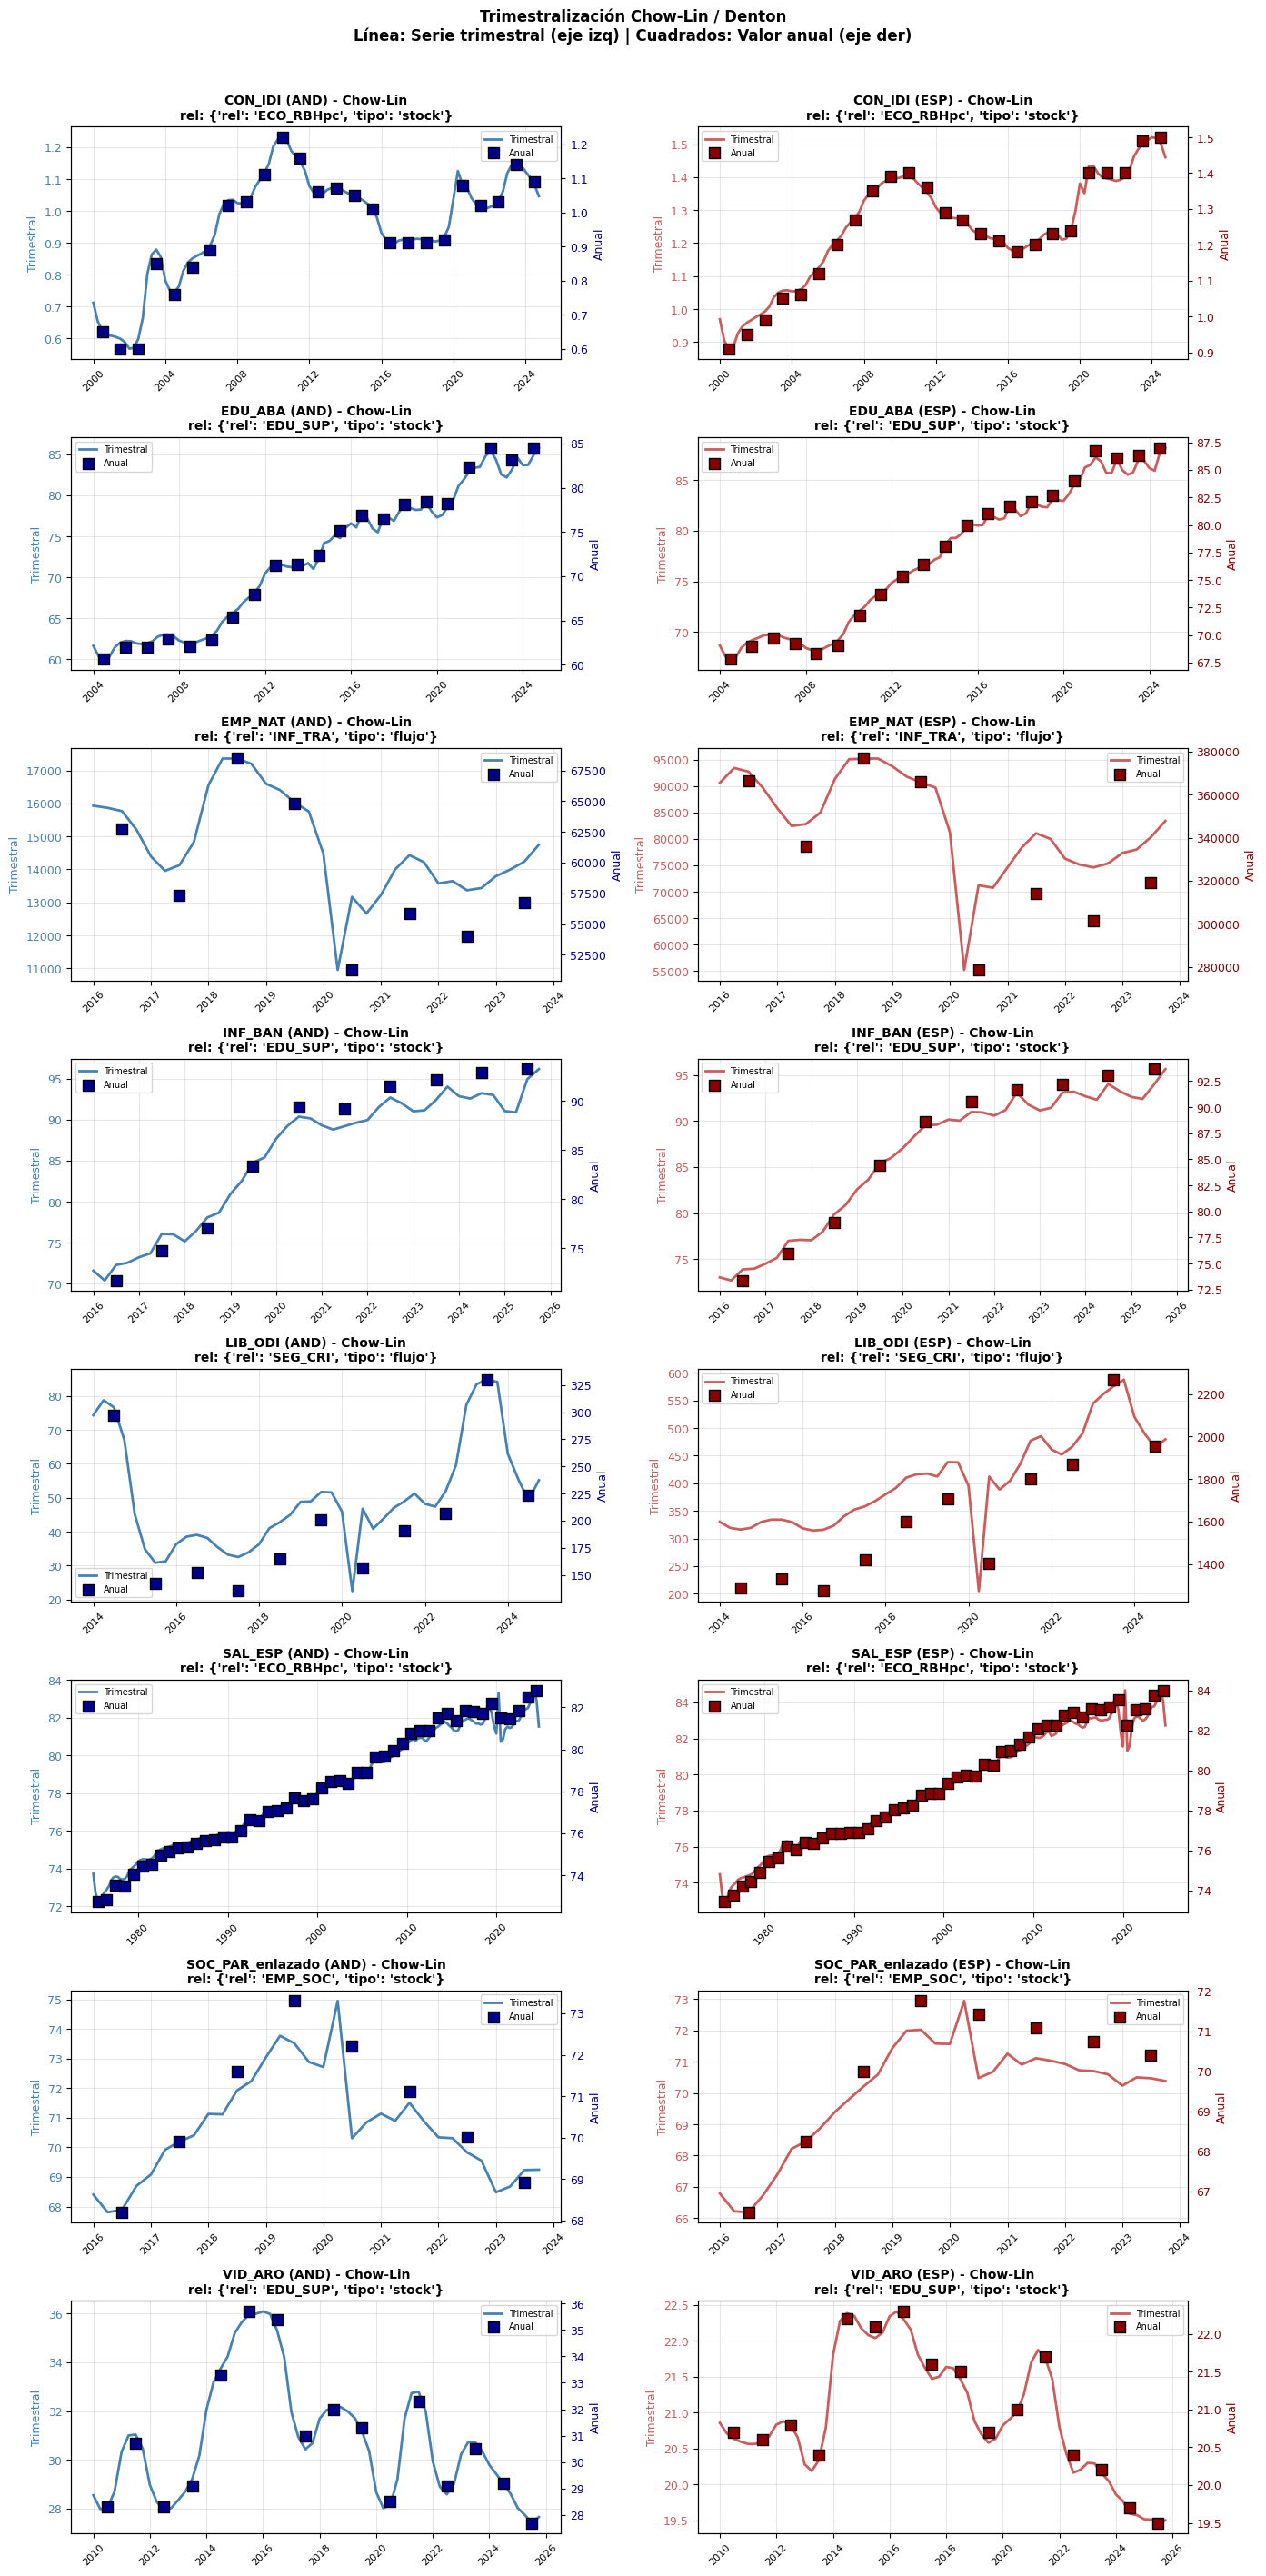


✓ Visualización completada


In [16]:
# %% CELDA 7B: VISUALIZACIÓN TRIMESTRALIZACIÓN
print("=" * 60)
print("VISUALIZACIÓN: ANUAL vs TRIMESTRALIZADO")
print("=" * 60)

# Indicadores anuales
indicadores_anuales = [col.replace('_AND', '') for col in anuales_trim.keys() if col.endswith('_AND')]
n_ind = len(indicadores_anuales)

fig, axes = plt.subplots(n_ind, 2, figsize=(14, 3.5 * n_ind))

for i, ind in enumerate(indicadores_anuales):
    
    for j, terr in enumerate(['AND', 'ESP']):
        ax1 = axes[i, j]
        ax2 = ax1.twinx()
        
        col = f"{ind}_{terr}"
        color_trim = 'steelblue' if terr == 'AND' else 'indianred'
        color_anual = 'darkblue' if terr == 'AND' else 'darkred'
        
        # --- Serie trimestral (eje izquierdo) ---
        if col in anuales_trim:
            trim = anuales_trim[col].dropna()
            x_trim = trim.index.to_timestamp()
            ax1.plot(x_trim, trim.values, color=color_trim, linewidth=2, label='Trimestral')
            ax1.set_ylabel('Trimestral', color=color_trim, fontsize=9)
            ax1.tick_params(axis='y', labelcolor=color_trim)
        
        # --- Serie anual (eje derecho) ---
        if col in anual.columns:
            anual_orig = anual[col].dropna()
            x_anual = [pd.Timestamp(year=año, month=7, day=1) for año in anual_orig.index]
            ax2.scatter(x_anual, anual_orig.values, s=80, color=color_anual, 
                       zorder=5, marker='s', edgecolor='black', linewidth=1, label='Anual')
            ax2.set_ylabel('Anual', color=color_anual, fontsize=9)
            ax2.tick_params(axis='y', labelcolor=color_anual)
        
        # Título
        metodo = "Chow-Lin" if ind in CHOWLIN_CONFIG else "Denton"
        relacionado = CHOWLIN_CONFIG.get(ind, "—")
        ax1.set_title(f"{ind} ({terr}) - {metodo}\nrel: {relacionado}", fontsize=10, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45, labelsize=8)
        
        # Leyenda
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=7)

plt.suptitle('Trimestralización Chow-Lin / Denton\n'
             'Línea: Serie trimestral (eje izq) | Cuadrados: Valor anual (eje der)',
             fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('results/figures/analysis/ipa27_trimestralizacion.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Visualización completada")


## 7. Nowcasting (Extensión ARIMA)

Extendemos las series que no llegan hasta 2025-Q3 usando ARIMA automático.

**Proceso**:
1. Identificar series que terminan antes del objetivo
2. Ajustar modelo ARIMA (p,d,q) automáticamente con `pmdarima`
3. Pronosticar los trimestres faltantes
4. Si ARIMA falla, usar LOCF (Last Observation Carried Forward)

In [17]:
# %% CELDA 8: NOWCASTING (SIMPLIFICADO - TODO ARIMA)
print("=" * 60)
print("NOWCASTING - EXTENSIÓN DE SERIES (ARIMA)")
print("=" * 60)

# =============================================================================
# CÁLCULO AUTOMÁTICO DEL TRIMESTRE OBJETIVO
# =============================================================================
from datetime import datetime
# from pmdarima import auto_arima # Asegurarse de tener importada pmdarima arriba o usar fallback

now = datetime.now()
month = now.month
year = now.year

# Lógica trimestral (igual que original)
if month in [2, 3, 4]:
    Q_OBJETIVO = pd.Period(year=2025, quarter=4, freq='Q') # FIJADO por usuario
elif month in [5, 6, 7]:
    Q_OBJETIVO = pd.Period(year=2025, quarter=4, freq='Q') # FIJADO por usuario
elif month in [8, 9, 10]:
    Q_OBJETIVO = pd.Period(year=2025, quarter=4, freq='Q') # FIJADO por usuario
else:  # Nov, Dec, Jan
    if month == 1:
        Q_OBJETIVO = pd.Period(year=2025, quarter=4, freq='Q') # FIJADO por usuario
    else:
        Q_OBJETIVO = pd.Period(year=2025, quarter=4, freq='Q') # FIJADO por usuario

print(f"Mes actual: {now.strftime('%B %Y')}")
print(f"Objetivo calculado: {Q_OBJETIVO}\n")

# =============================================================================
# PASO 1: Extender anuales trimestralizadas
# =============================================================================
print("📊 ANUALES TRIMESTRALIZADAS (Extensión ARIMA)")
print("-" * 50)

count_ext = 0
for col, serie in anuales_trim.items():
    serie = serie.dropna()
    if len(serie) == 0: continue
    
    ultimo = serie.index[-1]
    if ultimo < Q_OBJETIVO:
        try:
            # Asumimos que extender_arima está definida en celdas anteriores
            ext = extender_arima(serie, Q_OBJETIVO)
            n_ext = len(ext) - len(serie)
            if n_ext > 0:
                anuales_trim[col] = ext
                count_ext += 1
                
                # Detalle AND/ESP
                terr = col.split('_')[-1]
                if terr in ['AND', 'ESP']:
                    print(f"  ✓ {col}: +{n_ext}Q [ARIMA] ({ultimo} -> {Q_OBJETIVO})")
        except Exception as e:
            print(f"  ❌ Error extendiendo {col}: {e}")

print(f"Total anuales extendidas: {count_ext}")

# =============================================================================
# PASO 2: Extender trimestrales originales (ARIMA)
# =============================================================================
print("\n📊 TRIMESTRALES ORIGINALES (ARIMA)")
print("-" * 50)

for col in trimestral.columns:
    if col.startswith('AUX_'): continue
    
    serie = trimestral[col].dropna()
    if len(serie) == 0: continue
    
    ultimo = serie.index[-1]
    if ultimo < Q_OBJETIVO:
        try:
            trimestral[col] = extender_arima(serie, Q_OBJETIVO)
            terr = col.split('_')[-1]
            if terr in ['AND', 'ESP']:
                n_ext = (Q_OBJETIVO.year - ultimo.year)*4 + (Q_OBJETIVO.quarter - ultimo.quarter)
                print(f"  ✓ {col}: +{n_ext}Q [ARIMA] ({ultimo} -> {Q_OBJETIVO})")
        except Exception as e:
             print(f"  ❌ Error trimestral {col}: {e}")

# =============================================================================
# PASO 3: Extender mensuales agregadas
# =============================================================================
print("\n📊 MENSUALES AGREGADAS")
print("-" * 50)

for col in mensual_trim.columns:
    if col.startswith('AUX_'): continue
    
    serie = mensual_trim[col].dropna()
    if len(serie) == 0: continue
    
    ultimo = serie.index[-1]
    if ultimo < Q_OBJETIVO:
        try:
            mensual_trim[col] = extender_arima(serie, Q_OBJETIVO)
            terr = col.split('_')[-1]
            if terr in ['AND', 'ESP']:
                n_ext = len(mensual_trim[col]) - len(serie)
                print(f"  ✓ {col}: +{n_ext}Q [ARIMA]")
        except Exception as e:
            print(f"  ❌ Error mensual {col}: {e}")

print("\n✓ Nowcasting completado")


# CLIP FINAL para seguridad
trimestral = trimestral[trimestral.index <= Q_OBJETIVO]



NOWCASTING - EXTENSIÓN DE SERIES (ARIMA)
Mes actual: February 2026
Objetivo calculado: 2025Q4

📊 ANUALES TRIMESTRALIZADAS (Extensión ARIMA)
--------------------------------------------------
  ✓ CON_IDI_ESP: +4Q [ARIMA] (2024Q4 -> 2025Q4)
  ✓ CON_IDI_AND: +4Q [ARIMA] (2024Q4 -> 2025Q4)
  ✓ EDU_ABA_ESP: +4Q [ARIMA] (2024Q4 -> 2025Q4)
  ✓ EDU_ABA_AND: +4Q [ARIMA] (2024Q4 -> 2025Q4)
  ✓ EMP_NAT_ESP: +8Q [ARIMA] (2023Q4 -> 2025Q4)
  ✓ EMP_NAT_AND: +8Q [ARIMA] (2023Q4 -> 2025Q4)
  ✓ LIB_ODI_ESP: +4Q [ARIMA] (2024Q4 -> 2025Q4)
  ✓ LIB_ODI_AND: +4Q [ARIMA] (2024Q4 -> 2025Q4)
  ✓ SAL_ESP_ESP: +4Q [ARIMA] (2024Q4 -> 2025Q4)
  ✓ SAL_ESP_AND: +4Q [ARIMA] (2024Q4 -> 2025Q4)
  ✓ SOC_PAR_enlazado_ESP: +8Q [ARIMA] (2023Q4 -> 2025Q4)
  ✓ SOC_PAR_enlazado_AND: +8Q [ARIMA] (2023Q4 -> 2025Q4)
Total anuales extendidas: 108

📊 TRIMESTRALES ORIGINALES (ARIMA)
--------------------------------------------------
  ✓ ECO_COL_sal_ESP: +1Q [ARIMA] (2025Q3 -> 2025Q4)
  ✓ ECO_COL_sal_AND: +1Q [ARIMA] (2025Q3 -> 202

## 8B. Visualización: Series Extendidas

Comparamos la serie original vs la extensión (Chow-Lin o ARIMA):
- **Línea sólida**: Datos originales
- **Línea punteada**: Extensión (nowcasting)
- Rango: desde 2022 para ver contexto

Columnas: AND | ESP

VISUALIZACIÓN: SERIES EXTENDIDAS
Series extendidas: 12 (6 indicadores)


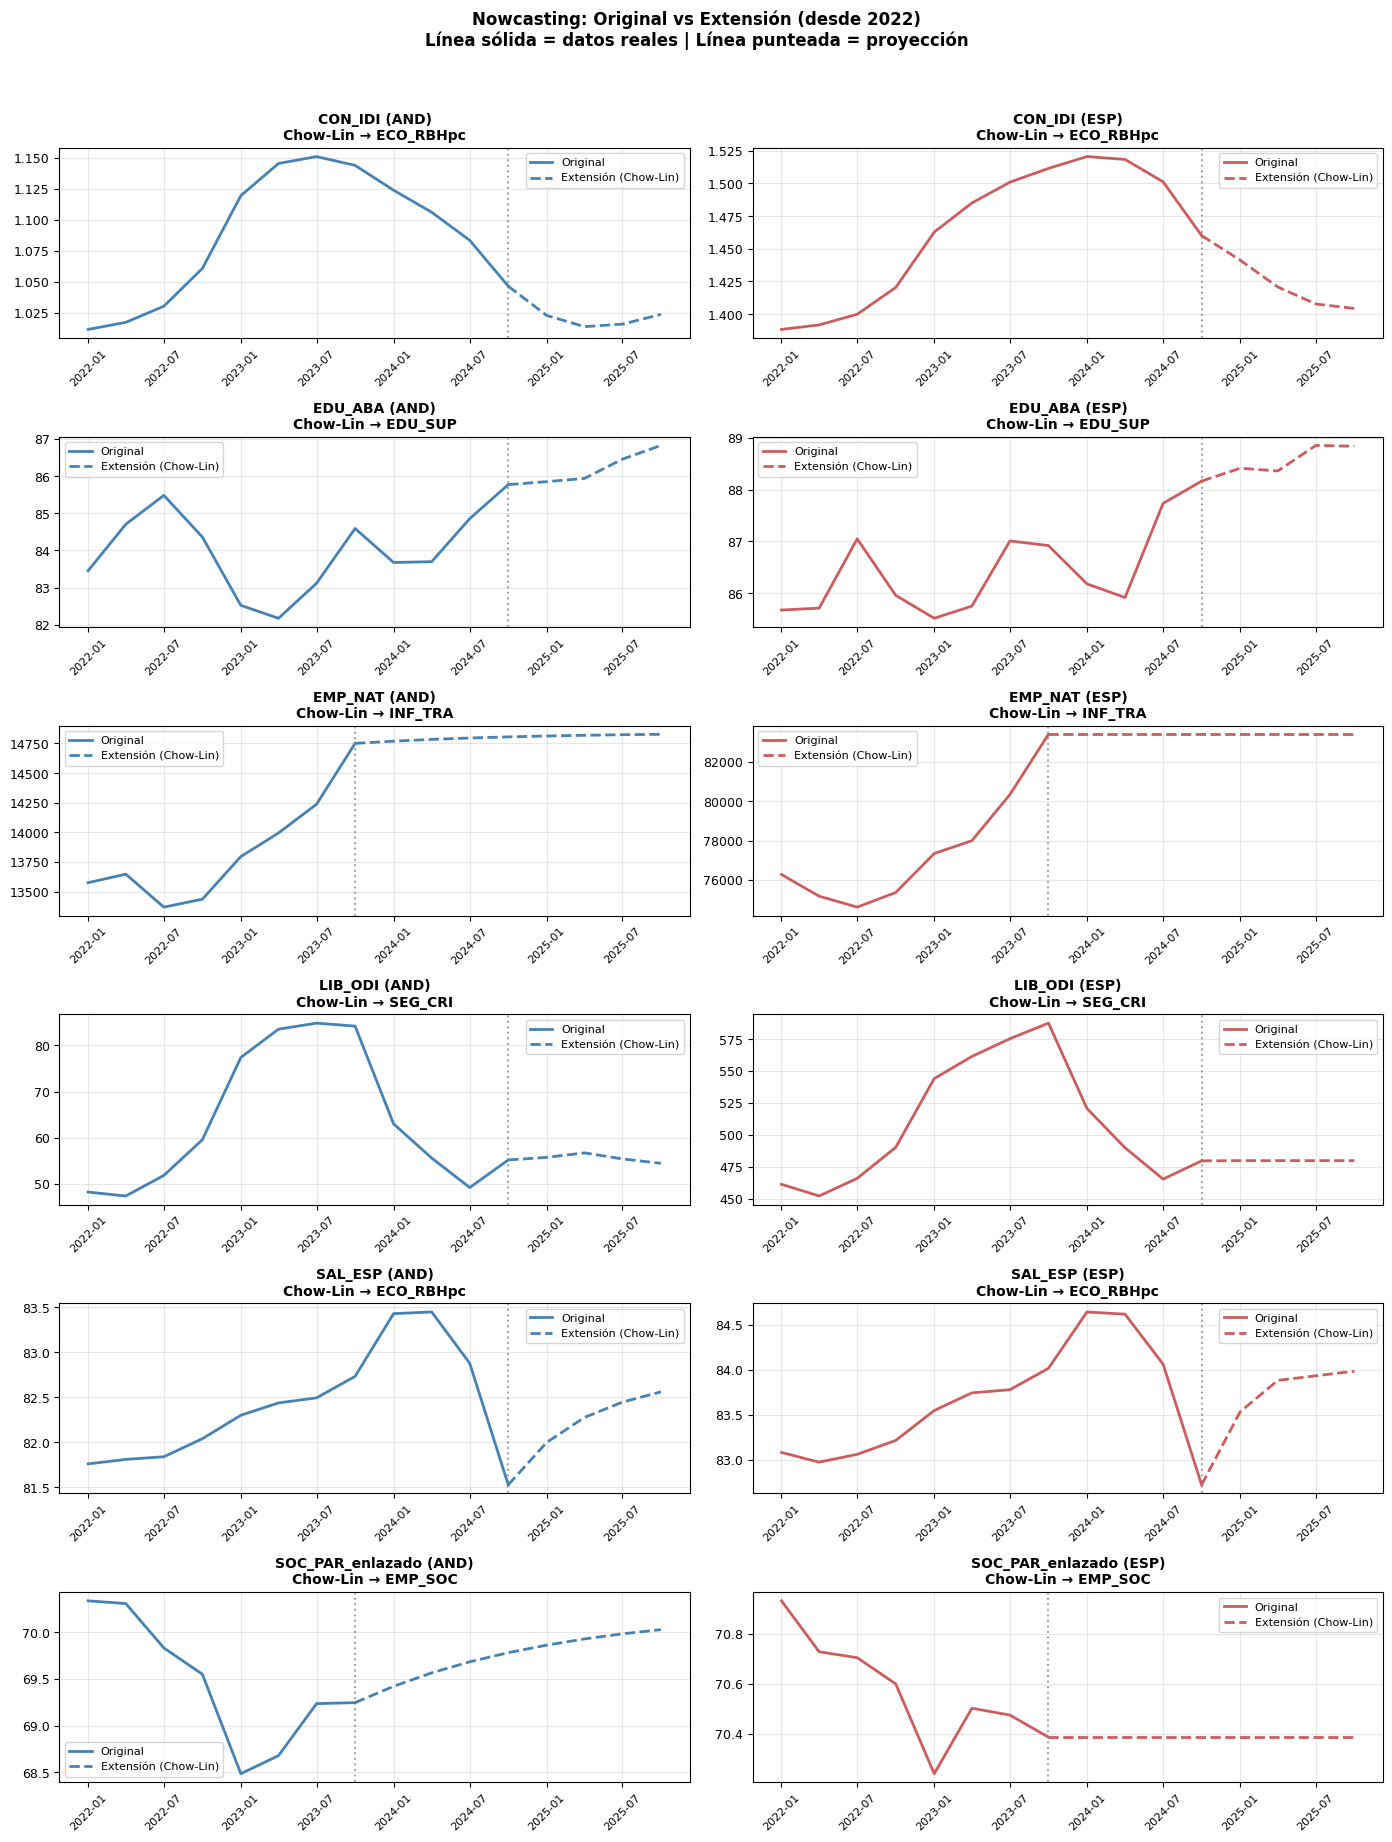


✓ Gráfico guardado: ipa27_nowcasting.png


In [18]:
# %% CELDA 8B: VISUALIZACIÓN NOWCASTING
print("=" * 60)
print("VISUALIZACIÓN: SERIES EXTENDIDAS")
print("=" * 60)

# Identificar series extendidas y su punto de corte
series_extendidas = {}

# Anuales trimestralizadas (guardamos info del último año original)
for col in anuales_trim.keys():
    if col.startswith('AUX_'):
        continue
    
    # Extraer indicador
    if col.endswith('_AND'):
        ind = col.replace('_AND', '')
    elif col.endswith('_ESP'):
        ind = col.replace('_ESP', '')
    else:
        continue
    
    # Último año en datos anuales originales
    if col in anual.columns:
        ultimo_año = anual[col].dropna().index[-1]
        ultimo_q_original = pd.Period(year=ultimo_año, quarter=4, freq='Q')
        
        # Solo si realmente se extendió
        if ultimo_q_original < Q_OBJETIVO:
            metodo = "Chow-Lin" if col in chowlin_betas else "ARIMA"
            series_extendidas[col] = {
                'serie': anuales_trim[col],
                'corte': ultimo_q_original,
                'metodo': metodo,
                'rel': chowlin_betas.get(col, {}).get('ind_rel', '—')
            }

# Obtener indicadores únicos que fueron extendidos
indicadores_ext = sorted(set(
    col.rsplit('_', 1)[0] for col in series_extendidas.keys()
))

print(f"Series extendidas: {len(series_extendidas)} ({len(indicadores_ext)} indicadores)")

# Crear figura: una fila por indicador, 2 columnas (AND, ESP)
n_ind = len(indicadores_ext)

if n_ind > 0:
    fig, axes = plt.subplots(n_ind, 2, figsize=(14, 3 * n_ind))
    if n_ind == 1:
        axes = axes.reshape(1, -1)
    
    # Límite temporal para visualización
    desde = pd.Period('2022Q1', freq='Q')
    
    for i, ind in enumerate(indicadores_ext):
        for j, terr in enumerate(['AND', 'ESP']):
            ax = axes[i, j]
            col = f"{ind}_{terr}"
            
            if col not in series_extendidas:
                ax.set_visible(False)
                continue
            
            info = series_extendidas[col]
            serie = info['serie']
            corte = info['corte']
            metodo = info['metodo']
            rel = info['rel']
            
            # Filtrar desde 2022
            serie = serie[serie.index >= desde]
            
            # Separar original vs extensión
            original = serie[serie.index <= corte]
            extension = serie[serie.index >= corte]  # Incluye punto de corte para continuidad
            
            # Colores
            color = 'steelblue' if terr == 'AND' else 'indianred'
            
            # Plot original (línea sólida)
            if len(original) > 0:
                ax.plot(original.index.to_timestamp(), original.values, 
                       color=color, linewidth=2, label='Original')
            
            # Plot extensión (línea punteada)
            if len(extension) > 0:
                ax.plot(extension.index.to_timestamp(), extension.values, 
                       color=color, linewidth=2, linestyle='--', label=f'Extensión ({metodo})')
            
            # Línea vertical en punto de corte
            ax.axvline(x=corte.to_timestamp(), color='gray', linestyle=':', alpha=0.7)
            
            # Formato
            titulo = f"{ind} ({terr})"
            if metodo == "Chow-Lin":
                titulo += f"\n{metodo} → {rel}"
            else:
                titulo += f"\n{metodo}"
            
            ax.set_title(titulo, fontsize=10, fontweight='bold')
            ax.legend(loc='best', fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45, labelsize=8)
    
    plt.suptitle(f'Nowcasting: Original vs Extensión (desde 2022)\n'
                 f'Línea sólida = datos reales | Línea punteada = proyección',
                 fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('results/figures/analysis/ipa27_nowcasting.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\n✓ Gráfico guardado: ipa27_nowcasting.png")
else:
    print("No hay series extendidas que visualizar")

In [19]:
# %% SUAVIZADO DE INDICADORES DE GOBERNANZA (Pre-Normalización)
print("=" * 60)
print("SUAVIZADO TEMPORAL (Rolling Mean 4 Trimestres) para GOBERNANZA")
print("=" * 60)

# Indicadores a suavizar (Eventos raros o muy volátiles)
# GOB_DES lo quitamos por petición tuya.
SMOOTH_VARS = ['GOB_EFF']

suavizados = 0

# Verificamos si existe 'trimestral', si no, intentamos con 'df_trim' (si vienes de unificación)
# Pero como estamos en Celda 28, probablemente usas 'trimestral'.
target_df = None
if 'trimestral' in locals():
    target_df = trimestral
elif 'df_trim' in locals(): # Por si acaso el flujo cambio
    target_df = df_trim

if target_df is None:
    print("⚠️ DataFrame 'trimestral' no encontrado. No se puede suavizar.")
else:
    for ind in SMOOTH_VARS:
        # Buscar todas las columnas de este indicador
        cols = [c for c in target_df.columns if c.startswith(f"{ind}_")]
        
        for col in cols:
            # Aplicar media móvil de 4 periodos (1 año)
            # min_periods=1 para no perder datos al principio
            serie_original = target_df[col]
            serie_suave = serie_original.rolling(window=4, min_periods=1).mean()
            
            target_df[col] = serie_suave
            suavizados += 1

    print(f"✓ Suavizado aplicado a {suavizados} series de Gobernanza ({SMOOTH_VARS})")
    print("  (Reduce volatilidad de eventos raros)")

SUAVIZADO TEMPORAL (Rolling Mean 4 Trimestres) para GOBERNANZA
✓ Suavizado aplicado a 18 series de Gobernanza (['GOB_EFF'])
  (Reduce volatilidad de eventos raros)


## 3. Normalización Per Cápita

Varios indicadores vienen en valores absolutos (número de delitos, sociedades creadas, etc.) y no son comparables entre territorios con diferente población.

**Transformación**: `valor_normalizado = (valor / población) × factor`

| Indicador | Factor | Resultado |
|-----------|--------|-----------|
| SEG_BAL, SEG_CRI, LIB_SEX, LIB_ODI | ×100.000 | Tasa por 100k hab |
| EMP_SOC, EMP_NAT, INV_HIP | ×100.000 | Por 100k hab |
| INF_TRA | ×1.000 | Viajeros por 1k hab |
| INV_IED | ×1 | € per cápita |

La población se obtiene de `AUX_POB` (serie trimestral para las 18 regiones).

In [20]:
# %% CELDA 4: NORMALIZACIÓN PER CÁPITA (CORREGIDA)
print("=" * 60)
print("NORMALIZACIÓN PER CÁPITA (18 Regiones)")
print("=" * 60)

# 0. CAPTURAR MUESTRA PARA AUDITORÍA (Antes de modificar)
sample_ind = 'SEG_BAL_AND'
sample_val_pre = None
sample_pob = None
if sample_ind in trimestral.columns:
    sample_val_pre = trimestral[sample_ind].dropna().iloc[-1]
    if 'AUX_POB_AND' in trimestral.columns:
        sample_pob = trimestral['AUX_POB_AND'].loc[trimestral[sample_ind].dropna().index[-1]]
    elif 'AUX_POB_enlazado_AND' in trimestral.columns:
        sample_pob = trimestral['AUX_POB_enlazado_AND'].loc[trimestral[sample_ind].dropna().index[-1]]

# 1. CONFIGURACIÓN CORREGIDA
PER_CAPITA_CONFIG = {
    'SEG_BAL': 'POB',   # Balance criminalidad -> tasa x 100k hab
    'SEG_CRI': 'POB',   # Tasa criminalidad -> tasa x 100k hab
    'LIB_SEX': 'POB',   # Delitos sexuales -> tasa x 100k hab
    'LIB_ODI': 'POB',   # Delitos odio -> tasa x 100k hab
    'EDU_SUP': 'POB',   # Educación superior -> tasa x 100 hab (%)
    'EMP_SOC': 'POB',   # Sociedades mercantiles -> x 100k hab
    'EMP_NAT': 'POB',   # Nacimientos empresas -> x 100k hab
    'INV_HIP': 'POB',   # Hipotecas -> x 100k hab
    'INF_TRA': 'POB',   # Pasajeros transporte -> x 1k hab
    'SOC_ASO': 'POB',   # Asociaciones -> x 1k hab
    'CON_OCI': 'POB',   # Afiliados conocimiento intensivo -> x 1k hab (CORREGIDO)
    'INV_IED': 'PIB',   # Inversión extranjera directa -> % RBH (proxy PIB)
}

# Factores de escala
FACTORES_CONVERSION = {
    'SEG_CRI': 100_000, 'SEG_BAL': 100_000, 'LIB_SEX': 100_000, 'LIB_ODI': 100_000,
    'EMP_SOC': 100_000, 'EMP_NAT': 100_000, 'INV_HIP': 100_000,
    'INF_TRA': 1_000,   'SOC_ASO': 1_000,   'CON_OCI': 1_000,
    'EDU_SUP': 100,     'INV_IED': 100  # Para INV_IED: resultado en % de RBH (proxy PIB)
}

normalizados = 0
errores = []

for ind, denom_tipo in PER_CAPITA_CONFIG.items():
    factor = FACTORES_CONVERSION.get(ind, 1)
    
    for terr in REGIONES:
        col = f"{ind}_{terr}"
        
        # Buscar DataFrame objetivo
        target_df = None
        if col in trimestral.columns:
            target_df = trimestral
        elif 'mensual_trim' in globals() and col in mensual_trim.columns:
            target_df = mensual_trim
        elif col in anuales_trim:
            target_df = None  # Caso especial dict
        else:
            continue
        
        # === SELECCIONAR DENOMINADOR ===
        if denom_tipo == 'PIB':
            # Reconstruir PIB TOTAL = PIBpc * Población / 1000 (en millones €)
            col_pibpc = f"ECO_RBHpc_{terr}"
            col_pob = f"AUX_POB_{terr}"
            if col_pob not in trimestral.columns:
                col_pob = f"AUX_POB_enlazado_{terr}"
            
            if col_pibpc not in trimestral.columns or col_pob not in trimestral.columns:
                errores.append(f"{col}: No se puede reconstruir PIB (faltan PIBpc o POB)")
                continue
            
            # PIB total en millones de euros
            denom = (trimestral[col_pibpc] * trimestral[col_pob]) / 1_000_000
            
        else:  # 'POB'
            col_denom = f"AUX_POB_{terr}"
            if col_denom not in trimestral.columns:
                col_denom = f"AUX_POB_enlazado_{terr}"
            
            if col_denom not in trimestral.columns:
                errores.append(f"{col}: No se encuentra población")
                continue
            
            denom = trimestral[col_denom]
        
        # === APLICAR NORMALIZACIÓN ===
        if target_df is not None:
            serie = target_df[col]
            denom_aligned = denom.reindex(serie.index)
            target_df[col] = (serie / denom_aligned) * factor
            normalizados += 1
        elif col in anuales_trim:
            serie = anuales_trim[col]
            denom_aligned = denom.reindex(serie.index)
            anuales_trim[col] = (serie / denom_aligned) * factor
            normalizados += 1

print(f"✓ Normalización completada: {normalizados} series procesadas")

if errores:
    print(f"\n⚠️ Errores ({len(errores)}):")
    for e in errores[:5]:
        print(f"  - {e}")

# 3. AUDITORÍA FINAL
if sample_val_pre is not None and sample_pob is not None:
    sample_val_post = trimestral[sample_ind].dropna().iloc[-1]
    print("\n--- 🔍 AUDITORÍA DE NORMALIZACIÓN (Ejemplo: SEG_BAL_AND) ---")
    print(f"  1. Valor Original (Absoluto): {sample_val_pre:,.0f}")
    print(f"  2. Población Trimestral:      {sample_pob:,.0f}")
    print(f"  3. Factor Escala:             x100,000")
    calc_manual = (sample_val_pre / sample_pob) * 100_000
    print(f"  4. Cálculo Manual:            {calc_manual:.4f}")
    print(f"  5. Resultado en DataFrame:    {sample_val_post:.4f}")
    
    if abs(calc_manual - sample_val_post) < 0.01:
        print("  ✅ LA OPERACIÓN ES CORRECTA")
    else:
        print("  ❌ DISCREPANCIA DETECTADA")

# 4. AUDITORÍA INV_IED (Nuevo)
print("\n--- 🔍 AUDITORÍA INV_IED_AND (% de RBH, proxy PIB) ---")
if 'INV_IED_AND' in trimestral.columns:
    val_ied = trimestral['INV_IED_AND'].dropna().iloc[-1]
    print(f"  Último valor: {val_ied:.4f}%")
    if val_ied < 50:  # Debería ser un porcentaje razonable
        print("  ✅ Valor razonable (% de RBH, proxy PIB)")
    else:
        print("  ⚠️ Valor sospechosamente alto")

NORMALIZACIÓN PER CÁPITA (18 Regiones)
✓ Normalización completada: 216 series procesadas

--- 🔍 AUDITORÍA DE NORMALIZACIÓN (Ejemplo: SEG_BAL_AND) ---
  1. Valor Original (Absoluto): 25,883
  2. Población Trimestral:      8,727,944
  3. Factor Escala:             x100,000
  4. Cálculo Manual:            296.5559
  5. Resultado en DataFrame:    296.5559
  ✅ LA OPERACIÓN ES CORRECTA

--- 🔍 AUDITORÍA INV_IED_AND (% de RBH, proxy PIB) ---
  Último valor: 618.2677%
  ⚠️ Valor sospechosamente alto


## 9. Unificación

Combinamos todas las series en un único DataFrame trimestral:

1. **Base**: Series trimestrales originales
2. **Añadir**: Series mensuales agregadas
3. **Añadir**: Series anuales trimestralizadas

Resultado: DataFrame con todos los indicadores listos para normalizar.

In [21]:
# %% CELDA 9: UNIFICACIÓN
print("=" * 60)
print("UNIFICACIÓN EN DATAFRAME TRIMESTRAL")
print("=" * 60)

# Empezar con trimestrales originales
df_trim = trimestral.copy()

print(f"\n1️⃣ Base (trimestrales): {len(df_trim.columns)} columnas")

# Añadir mensuales agregadas
n_añadidas = 0
for col in mensual_trim.columns:
    if col not in df_trim.columns:
        df_trim[col] = mensual_trim[col]
        n_añadidas += 1
    else:
        df_trim[col] = df_trim[col].combine_first(mensual_trim[col])

print(f"2️⃣ + Mensuales agregadas: +{n_añadidas} columnas nuevas")

# Añadir anuales trimestralizadas
n_añadidas = 0
for col, serie in anuales_trim.items():
    if col not in df_trim.columns:
        df_trim[col] = serie
        n_añadidas += 1
    else:
        df_trim[col] = df_trim[col].combine_first(serie)

print(f"3️⃣ + Anuales trimestralizadas: +{n_añadidas} columnas nuevas")

# Ordenar índice
df_trim = df_trim.sort_index()
# Limitar al trimestre objetivo
df_trim = df_trim[df_trim.index <= Q_OBJETIVO]

# Separar columnas
cols_aux = [c for c in df_trim.columns if c.startswith('AUX_')]
cols_ind = [c for c in df_trim.columns if not c.startswith('AUX_')]

# Ordenar columnas
df_trim = df_trim[sorted(cols_ind) + sorted(cols_aux)]

# =============================================================================
# RESUMEN
# =============================================================================
print(f"\n" + "=" * 60)
print("DATAFRAME UNIFICADO")
print("=" * 60)
print(f"  Shape: {df_trim.shape}")
print(f"  Rango: {df_trim.index.min()} → {df_trim.index.max()}")
print(f"  Indicadores: {len(cols_ind)}")
print(f"  Auxiliares: {len(cols_aux)}")

# Indicadores únicos
indicadores_unicos = sorted(set(c.rsplit('_', 1)[0] for c in cols_ind))
print(f"\n  Indicadores únicos ({len(indicadores_unicos)}):")
for ind in indicadores_unicos:
    # Usar AND como referencia para el resumen de cobertura
    col_ref = f"{ind}_AND"
    if col_ref not in df_trim.columns:
        # Si no hay AND, buscar la primera región disponible
        regiones_disp = [c for c in df_trim.columns if c.startswith(f"{ind}_")]
        if regiones_disp:
            col_ref = regiones_disp[0]
        else:
            continue
            
    serie = df_trim[col_ref].dropna()
    rango = f"{serie.index.min()} → {serie.index.max()}" if len(serie) > 0 else "SIN DATOS"
    n_obs = len(serie)
    print(f"    {ind:<20} {rango} ({n_obs} obs)")

# Verificación cobertura (usando AND como referencia o ESP si AND falta)
print(f"\n" + "-" * 60)
print(f"COBERTURA AL {Q_OBJETIVO} (Ref: AND/ESP)")
print("-" * 60)

completos, incompletos = [], []
for ind in indicadores_unicos:
    col_ref = f"{ind}_AND"
    if col_ref not in df_trim.columns:
        col_ref = f"{ind}_ESP"
        
    if col_ref in df_trim.columns:
        serie = df_trim[col_ref].dropna()
        if len(serie) > 0 and serie.index[-1] >= Q_OBJETIVO:
            completos.append(ind)
        else:
            incompletos.append(ind)
    else:
        incompletos.append(ind)

print(f"  ✅ Completos: {len(completos)}")
print(f"  ❌ Incompletos: {len(incompletos)}")
if incompletos:
    print(f"     → {incompletos}")

print("\n✓ Unificación completada")

UNIFICACIÓN EN DATAFRAME TRIMESTRAL

1️⃣ Base (trimestrales): 216 columnas
2️⃣ + Mensuales agregadas: +126 columnas nuevas
3️⃣ + Anuales trimestralizadas: +144 columnas nuevas

DATAFRAME UNIFICADO
  Shape: (124, 486)
  Rango: 1995Q1 → 2025Q4
  Indicadores: 450
  Auxiliares: 36

  Indicadores únicos (25):
    CON_IDI              2000Q1 → 2025Q4 (104 obs)
    CON_OCI              2009Q1 → 2025Q4 (68 obs)
    ECO_COL_sal          2010Q1 → 2025Q4 (64 obs)
    ECO_PIBpc            2010Q1 → 2025Q4 (42 obs)
    ECO_RBHpc            2010Q1 → 2025Q4 (64 obs)
    EDU_ABA              2004Q1 → 2025Q4 (88 obs)
    EDU_SUP              2014Q1 → 2025Q4 (48 obs)
    EMP_NAT              2016Q1 → 2025Q4 (40 obs)
    EMP_SOC              2009Q1 → 2025Q4 (68 obs)
    GOB_DES              2016Q1 → 2025Q4 (40 obs)
    GOB_EFF              2016Q1 → 2025Q4 (40 obs)
    INF_BAN              2016Q1 → 2025Q4 (40 obs)
    INF_TRA              2009Q1 → 2025Q4 (68 obs)
    INV_HIP              2009Q1 → 2025Q4 (6

## 9. Inversión de Sentido

Para los indicadores donde **menor es mejor** (criminalidad, paro, abandono escolar, etc.), 
invertimos su sentido para que contribuyan positivamente al índice:

```python
valor_invertido = max(serie) - serie + min(serie)
```

Indicadores a invertir:
- SEG_BAL (Balance de Criminalidad)
- SEG_CRI (Tasa de Criminalidad)
- LIB_ODI (Delitos de Odio)
- LIB_SEX (Delitos Sexuales)
- VID_ARO (Riesgo de Pobreza - AROPE)
- VID_PAR (Tasa de Paro)
- EDU_ABA (Abandono Escolar)

In [22]:
# %% MARCADO DE INDICADORES INVERTIDOS (para normalización por techos fijos)
import pandas as pd

print("=" * 60)
print("MARCADO DE INDICADORES INVERTIDOS")
print("=" * 60)

# Con la nueva metodología de techos fijos, NO invertimos los datos brutos.
# En su lugar, marcamos qué indicadores son "menor es mejor" para que la
# celda de normalización aplique la fórmula correcta:
#   - Normal (mayor es mejor):   score = (x / techo) × 100
#   - Invertido (menor es mejor): score = (1 - x / techo) × 100
#     donde 'techo' para invertidos = peor valor razonable (el más alto)

# Lista de indicadores donde MENOR es MEJOR
# (viene de la variable INVERTIR definida en la celda de configuración)
print(f"\nIndicadores marcados como 'menor es mejor' ({len(INVERTIR)}):")
for ind in INVERTIR:
    cols = [c for c in df_trim.columns if c.startswith(f"{ind}_")]
    n_series = len(cols)
    if n_series > 0:
        # Mostrar rango actual para verificación
        vals = df_trim[cols].values.flatten()
        vals = vals[~pd.isna(vals)]
        if len(vals) > 0:
            print(f"  ↓ {ind:<15} ({n_series} series) | Rango actual: [{vals.min():.2f}, {vals.max():.2f}]")
        else:
            print(f"  ↓ {ind:<15} ({n_series} series) | Sin datos")
    else:
        print(f"  ⚠️ {ind:<15} No encontrado en df_trim")

# Crear diccionario de dirección para uso posterior
DIRECCION = {}
indicadores_en_trim = sorted(set(c.rsplit('_', 1)[0] for c in df_trim.columns if not c.startswith('AUX_')))
for ind in indicadores_en_trim:
    DIRECCION[ind] = 'invertido' if ind in INVERTIR else 'normal'

print(f"\nResumen de direcciones:")
n_normal = sum(1 for v in DIRECCION.values() if v == 'normal')
n_invertido = sum(1 for v in DIRECCION.values() if v == 'invertido')
print(f"  → Normal (mayor es mejor):    {n_normal}")
print(f"  → Invertido (menor es mejor): {n_invertido}")

print("\n✓ Marcado completado. Los datos en df_trim NO se han modificado.")
print("  La inversión se aplicará en la fórmula de normalización.")


MARCADO DE INDICADORES INVERTIDOS

Indicadores marcados como 'menor es mejor' (6):
  ↓ SEG_BAL         (18 series) | Rango actual: [75.62, 885.49]
  ↓ SEG_CRI         (18 series) | Rango actual: [480.92, 1719.43]
  ↓ LIB_ODI         (18 series) | Rango actual: [-0.01, 4.86]
  ↓ LIB_SEX         (18 series) | Rango actual: [3.01, 23.54]
  ↓ VID_ARO         (18 series) | Rango actual: [6.70, 39.89]
  ↓ VID_PAR         (18 series) | Rango actual: [6.11, 36.79]

Resumen de direcciones:
  → Normal (mayor es mejor):    19
  → Invertido (menor es mejor): 6

✓ Marcado completado. Los datos en df_trim NO se han modificado.
  La inversión se aplicará en la fórmula de normalización.


## 9B. Cálculo de Techos Fijos

Para cada indicador, calculamos un **techo fijo** que representa el nivel aspiracional de referencia. La fórmula es:

$$techo_i = \overline{x}_{top3} + k \times \Delta_{anual} \times horizonte$$

Donde:
- $\overline{x}_{top3}$: Media de las 3 mejores regiones en el último periodo disponible
- $\Delta_{anual}$: Ritmo medio de mejora anual del top3 (últimos 5 años)
- $k$: Factor de margen (default 1.0)
- $horizonte$: Años de proyección (default 5)

Los techos se fijan una vez y se revisan cada 5 años. Para indicadores **invertidos** (menor es mejor), el techo representa el peor valor razonable y se calcula con las 3 peores regiones + margen de empeoramiento.


In [23]:
# %% CÁLCULO DE TECHOS (O Fronteras Base para Inversos)
import pandas as pd
import numpy as np

print("=" * 60)
print("CÁLCULO DE LÍMITES ESTRUCTURALES (Techos y Suelos)")
print("=" * 60)

# === PARÁMETROS ===
K_MARGEN = 1.0          # Factor multiplicador del margen
HORIZONTE_ANOS = 5      # Años de proyección hacia adelante
N_TOP = 3               # Número de regiones top para la media
ANOS_TENDENCIA = 5      # Años hacia atrás para calcular tendencia
MIN_REGIONES = 5        # Mínimo de regiones con datos para calcular techo fiable

# === IDENTIFICAR INDICADORES Y REGIONES ===
cols_indicadores = [c for c in df_trim.columns if not c.startswith('AUX_')]
indicadores_unicos = sorted(set(c.rsplit('_', 1)[0] for c in cols_indicadores))

ultimo_q = df_trim.index[-1]
inicio_tendencia = df_trim.index[-min(ANOS_TENDENCIA * 4, len(df_trim))]

print(f"Indicadores a evaluar: {len(indicadores_unicos)} | Último periodo: {ultimo_q}")

# === CALCULAR TECHOS ===
TECHOS = {}
detalles_techos = []

for ind in indicadores_unicos:
    cols_ind = [c for c in df_trim.columns if c.startswith(f"{ind}_")]
    if not cols_ind: continue
    
    es_invertido = DIRECCION.get(ind, 'normal') == 'invertido'
    
    # 1. Valores del último periodo o promedio de los últimos 4 trimestres para volátiles
    VOLATILES = ['INV_IED']  # Indicadores muy volátiles
    if ind in VOLATILES and len(df_trim) >= 4:
        ultimos_4_q = df_trim.index[-4:]
        valores_ultimo = {col.rsplit('_', 1)[1]: df_trim.loc[ultimos_4_q, col].mean()
                          for col in cols_ind if df_trim.loc[ultimos_4_q, col].notna().any()}
    else:
        valores_ultimo = {col.rsplit('_', 1)[1]: df_trim.loc[ultimo_q, col] 
                          for col in cols_ind if pd.notna(df_trim.loc[ultimo_q, col])}
    n_regiones = len(valores_ultimo)
    
    if n_regiones < MIN_REGIONES:
        vals = list(valores_ultimo.values())
        techo = max(vals) * 1.2
        TECHOS[ind] = techo
        detalles_techos.append({
            'Indicador': ind, 'Dirección': 'INV' if es_invertido else 'NOR',
            'Techo': techo, 'Media_TopN': np.nan, 'Delta_anual': np.nan,
            'N_regiones': n_regiones, 'Fiabilidad': 'BAJA', 'Regiones_Base': 'Fallback'
        })
        continue

    fiabilidad = 'ALTA'
        
    # --- SELECCIÓN DE LAS 3 REGIONES DE REFERENCIA ---
    # RESTAURADO: Siempre cogemos las 3 con valores más altos.
    # En Normales: son las de 'Excelencia' (para poner el techo a aspirar).
    # En Inversos: son las de 'Peor desempeño' (para poner el suelo de 0 puntos).
    # EXCLUIR ESPAÑA: Seleccionamos las 3 mejores regiones, sin contar a España
    valores_sin_esp = {k: v for k, v in valores_ultimo.items() if k != 'ESP'}
    seleccion = sorted(valores_sin_esp.items(), key=lambda x: x[1], reverse=True)[:N_TOP]
    
    regiones_base = [r for r, _ in seleccion]
    media_topN = np.mean([v for _, v in seleccion])
    
    # --- TENDENCIA ---
    cols_sel = [f"{ind}_{r}" for r in regiones_base]
    serie_grupo = df_trim.loc[inicio_tendencia:ultimo_q, cols_sel].mean(axis=1).dropna()
    
    if len(serie_grupo) >= 8:
        delta_anual = (serie_grupo.iloc[-4:].mean() - serie_grupo.iloc[:4].mean()) / (len(serie_grupo)/4)
    else:
        delta_anual = 0
    
    # --- CÁLCULO DEL TECHO ---
    if es_invertido:
        # En inversos, el techo es el límite péśimo. Le sumamos el margen de empeoramiento 
        # (usando abs para asegurar que ampliamos el límite hacia territorios peores).
        techo = media_topN + K_MARGEN * abs(delta_anual) * HORIZONTE_ANOS
    else:
        # En normales, el techo es la excelencia. Le sumamos el margen de mejora.
        techo = media_topN + K_MARGEN * max(delta_anual, 0) * HORIZONTE_ANOS

    # Validaciones anti-errores
    if techo <= 0: techo = abs(media_topN) * 1.2 if media_topN != 0 else 1.0; fiabilidad = 'AJUSTADO'
    
    # Limitar en porcentajes (solo si no es invertido)
    if ind in ['VID_PAR', 'VID_ARO', 'EDU_ABA', 'SOC_PAR_enlazado', 'EDU_SUP', 'INF_BAN', 'CON_IDI']:
        if not es_invertido and techo > 100: techo = 100.0; fiabilidad = 'CAPPED_100'
    
    TECHOS[ind] = techo
    detalles_techos.append({
        'Indicador': ind, 'Dirección': 'INV' if es_invertido else 'NOR',
        'Techo': round(techo, 4), 'Media_TopN': round(media_topN, 4),
        'Delta_anual': round(delta_anual, 4), 'N_regiones': n_regiones,
        'Fiabilidad': fiabilidad, 'Regiones_Base': ", ".join(regiones_base)
    })

# REPORTAR RESULTADOS PARA VERIFICACIÓN VISUAL
df_techos = pd.DataFrame(detalles_techos)
print(f"\n{'Indicador':<20} {'Dir':>4} {'Límite/Techo':>12} {'Media(Base)':>12} {'Δ_anual':>10}  {'Regiones Referencia (Altur/Profundidad)'}")
print("-" * 105)
for _, r in df_techos.iterrows():
    print(f"{r['Indicador']:<20} {r['Dirección']:>4} {r['Techo']:>12.2f} {r['Media_TopN']:>12.2f} {r['Delta_anual']:>10.4f}  {r['Regiones_Base']}")


CÁLCULO DE LÍMITES ESTRUCTURALES (Techos y Suelos)
Indicadores a evaluar: 25 | Último periodo: 2025Q4

Indicador             Dir Límite/Techo  Media(Base)    Δ_anual  Regiones Referencia (Altur/Profundidad)
---------------------------------------------------------------------------------------------------------
CON_IDI               NOR         2.18         2.10     0.0167  PV, NAV, MAD
CON_OCI               NOR        72.59        64.38     1.6421  MAD, CAT, PV
ECO_COL_sal           NOR      1913.86      1913.86    -5.0082  MAD, PV, CAT
ECO_PIBpc             NOR       124.82       113.83     2.1982  AND, GAL, EXT
ECO_RBHpc             NOR      5991.22      5478.05   102.6337  PV, MAD, NAV
EDU_ABA               NOR        97.78        95.13     0.5293  CANT, PV, AST
EDU_SUP               NOR         0.04         0.04     0.0004  PV, MAD, NAV
EMP_NAT               NOR       205.47       205.47    -0.0006  BAL, CAT, MAD
EMP_SOC               NOR       113.66        98.15     3.1008  MAD,

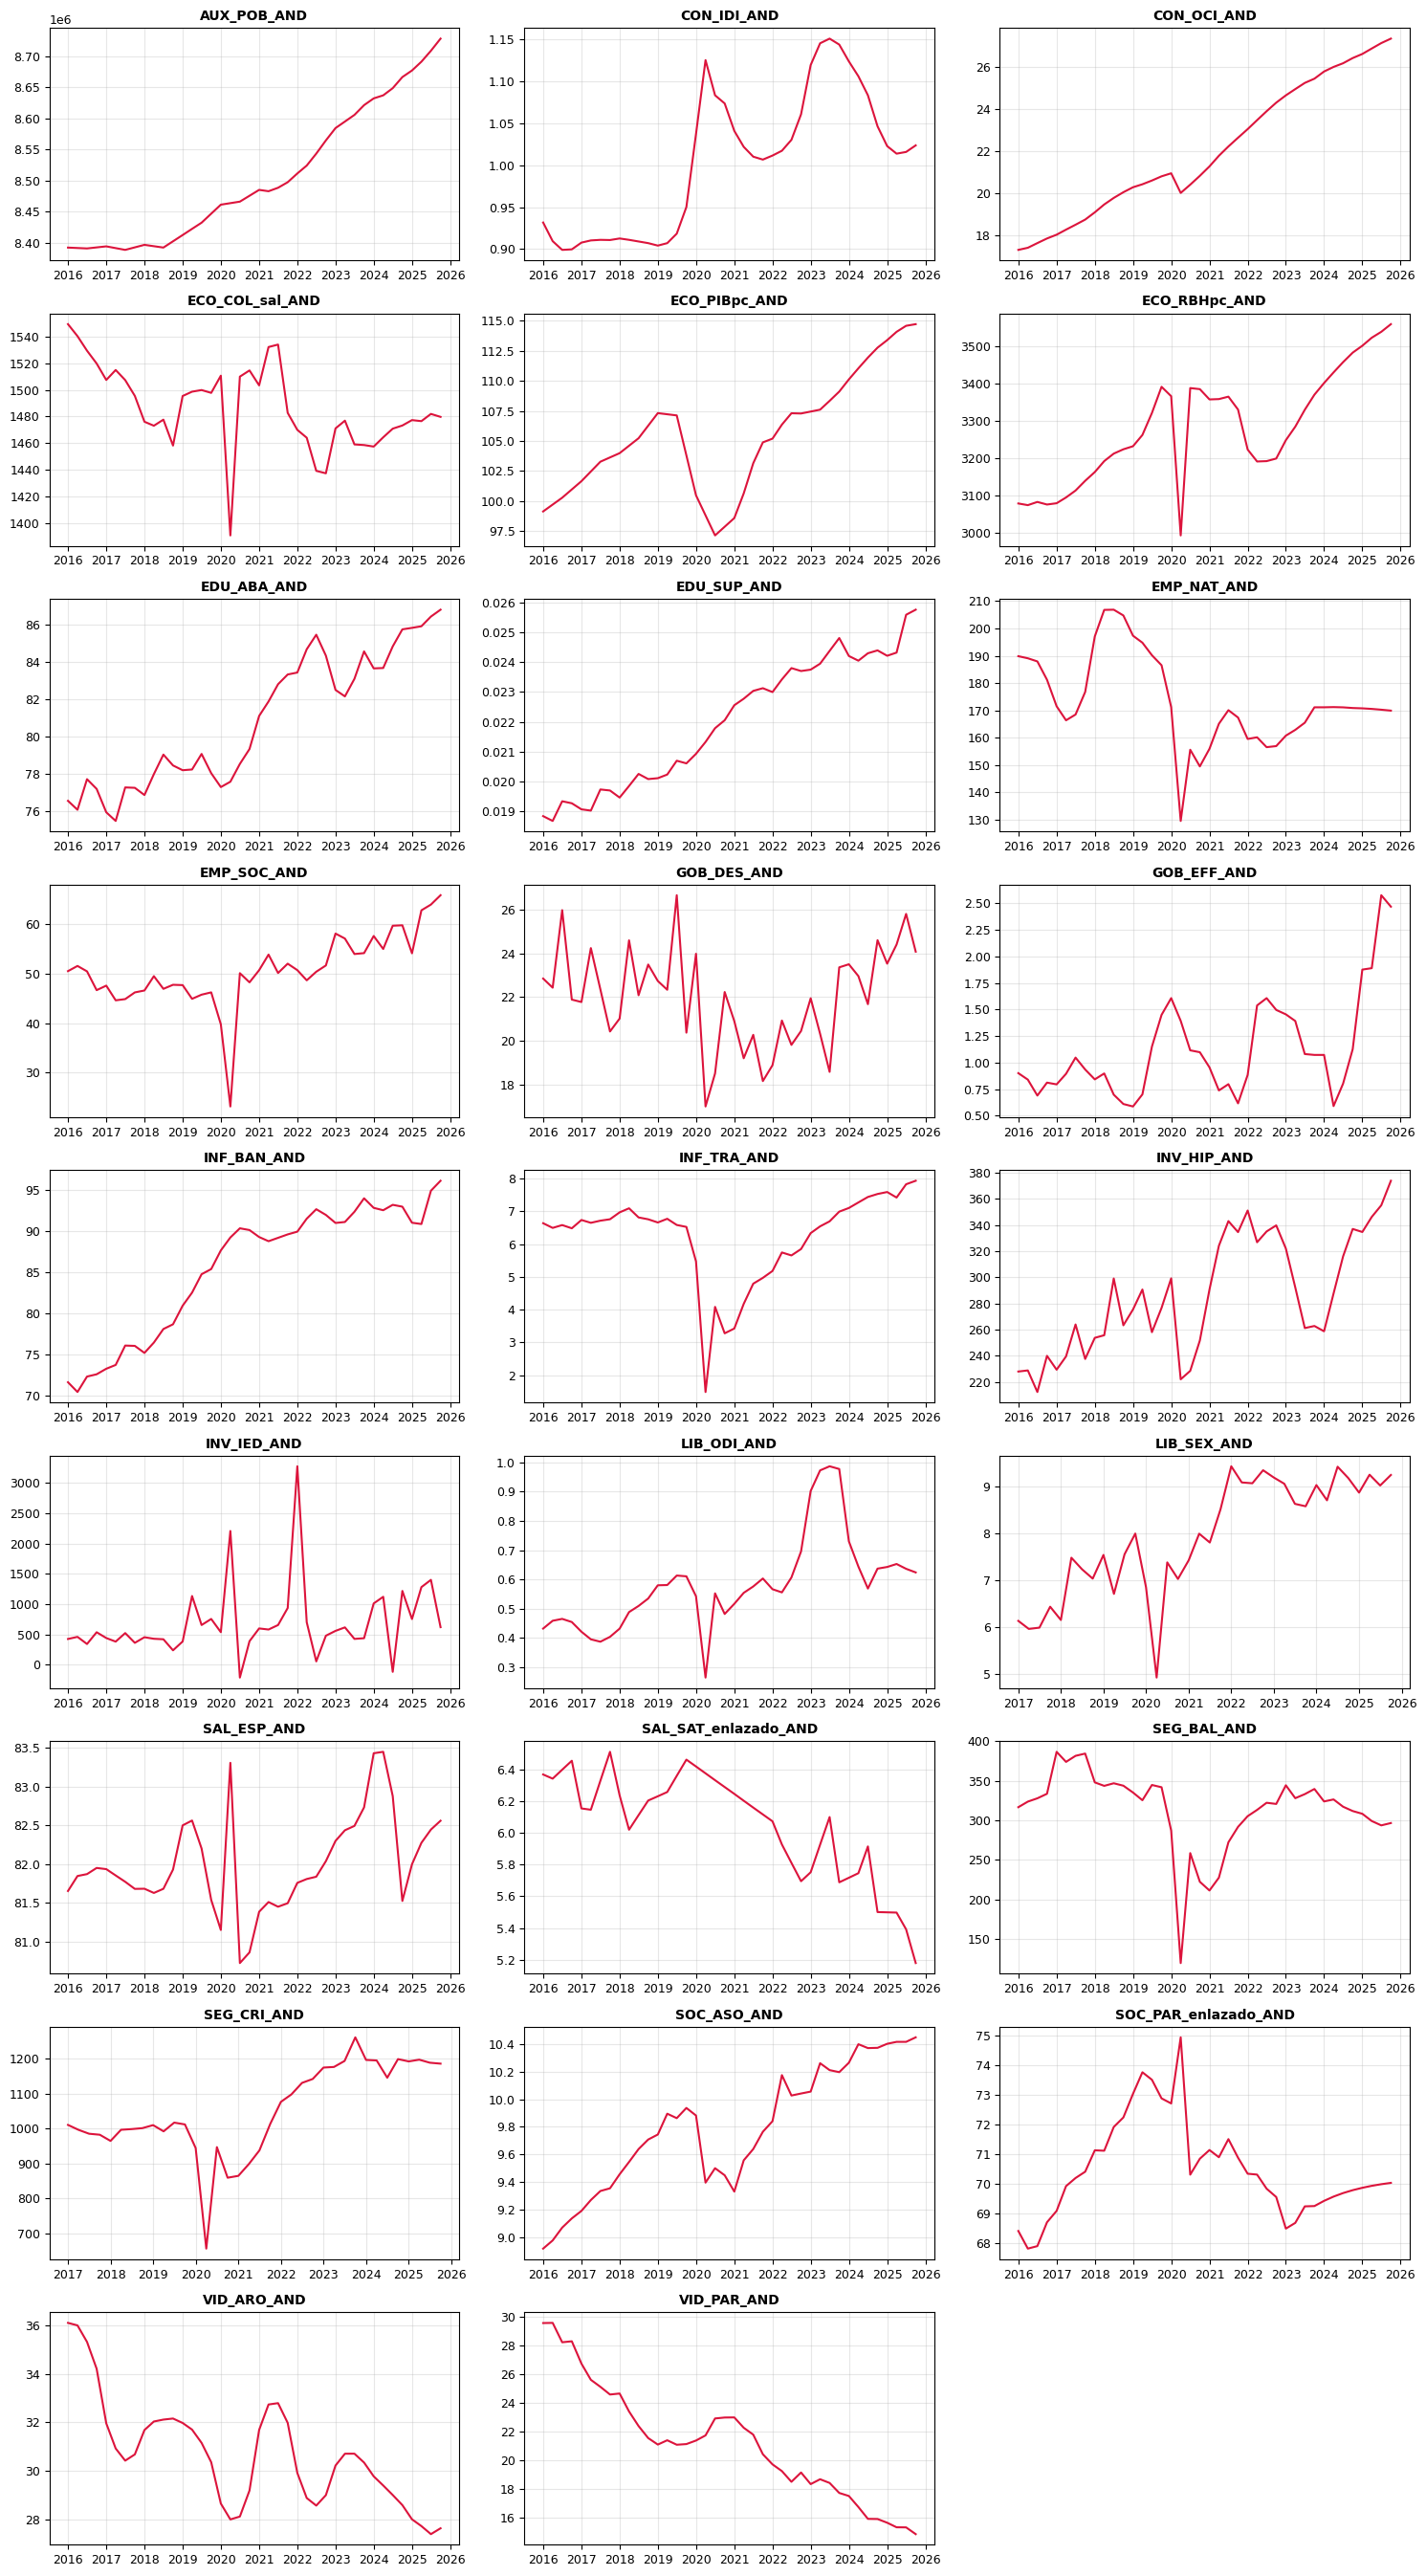

In [24]:
# %% DIAGNÓSTICO RÁPIDO: RADIOGRAFÍA DE ANDALUCÍA
import matplotlib.pyplot as plt
import math
import pandas as pd

# Seleccionar DataFrame disponible (df_norm, df_trim, o lo que haya en memoria en Celda 33)
# Asumimos que DF_FINAL o DF_TRIM ya existen.
df_target = df_trim if 'df_trim' in locals() else None

if df_target is None:
    print("⚠️ No encuentro 'df_trim'.")
else:
    # Filtrar solo Andalucía
    cols_and = [c for c in df_target.columns if c.endswith('_AND') and not c.startswith('AUX_')]
    cols_and.sort()
    
    # También incluimos la POBLACIÓN para ver si es la culpable
    if 'AUX_POB_AND' in df_target.columns:
        cols_and.insert(0, 'AUX_POB_AND')
    elif 'AUX_POB_enlazado_AND' in df_target.columns:
        cols_and.insert(0, 'AUX_POB_enlazado_AND')

    n_cols = 3
    n_rows = math.ceil(len(cols_and) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(cols_and):
        ax = axes[i]
        serie = df_target[col].dropna()
        
        # Filtrar desde 2016 para ver detalle reciente
        serie = serie[serie.index >= pd.Period('2016Q1', freq='Q')]
        
        if not serie.empty:
            # Convertir a timestamp
            idx = serie.index.to_timestamp() if hasattr(serie.index, 'to_timestamp') else serie.index
            ax.plot(idx, serie.values, color='crimson')
            ax.set_title(col, fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
    
    # Limpiar vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

## 10. Normalización (Metodología Legatum)

Aplicamos la metodología del **Legatum Prosperity Index** para normalizar todos los indicadores a una escala 0-100:

### Fórmula de normalización:
```
Puntuación = ((valor - min) / (max - min)) × 100
```

### Características:
- **Min/Max calculados por periodo**: Para cada trimestre, calculamos el mínimo y máximo entre todas las regiones
- **Ajuste por outliers**: Usamos **percentiles 2.5 y 97.5** en lugar de min/max absolutos
- **Normalización relativa**: Permite comparar Andalucía con el resto de CCAAs en cada periodo
- **Escala común**: Todos los indicadores quedan en rango 0-100

### Ejemplo:
Si en 2020Q1:
- Tasa de paro mínima (Navarra): 8%
- Tasa de paro máxima (Andalucía): 24%
- Tasa de paro España: 14%

Entonces (tras inversión de sentido):
- Navarra: 100 puntos (mejor)
- Andalucía: 0 puntos (peor)
- España: 62.5 puntos (intermedio)

In [25]:
# %% NORMALIZACIÓN POR TECHOS FIJOS (0-100, cap 120)
import pandas as pd
import numpy as np

print("=" * 60)
print("NORMALIZACIÓN (Techos Fijos - Metodología IPA27)")
print("=" * 60)

# DataFrame para almacenar valores normalizados
df_norm = pd.DataFrame(index=df_trim.index)

# Obtener lista de indicadores únicos (sin auxiliares)
cols_indicadores = [c for c in df_trim.columns if not c.startswith('AUX_')]
indicadores_unicos = sorted(set(c.rsplit('_', 1)[0] for c in cols_indicadores))

print(f"\nIndicadores a normalizar: {len(indicadores_unicos)}")
print(f"Regiones: {len(REGIONES)}")
print(f"Techos disponibles: {sum(1 for v in TECHOS.values() if pd.notna(v))}")

normalizados = 0
sin_techo = []
stats = []

for ind in indicadores_unicos:
    techo = TECHOS.get(ind, np.nan)
    
    if pd.isna(techo) or techo == 0:
        sin_techo.append(ind)
        continue
    
    es_invertido = DIRECCION.get(ind, 'normal') == 'invertido'
    
    # Obtener todas las columnas de este indicador
    cols_ind = [c for c in df_trim.columns if c.startswith(f"{ind}_")]
    
    if not cols_ind:
        continue
    
    # Normalización VECTORIZADA (todas las regiones y periodos a la vez)
    datos = df_trim[cols_ind]
    
    if es_invertido:
        # Invertido: score = (1 - x/techo) × 100
        # Cuando x=0 → score=100 (perfecto), cuando x=techo → score=0 (peor)
        scores = (1 - datos / techo) * 100
    else:
        # Normal: score = (x/techo) × 100
        # Cuando x=0 → score=0, cuando x=techo → score=100
        scores = (datos / techo) * 100
    
    # Clamping: mínimo 0, máximo 120 (permite superar techo ligeramente)
    scores = scores.clip(lower=0, upper=120)
    
    # Guardar en df_norm
    for col in cols_ind:
        df_norm[col] = scores[col]
        normalizados += scores[col].notna().sum()
    
    # Estadísticas para reporte
    vals_and = scores[[c for c in cols_ind if c.endswith('_AND')]]
    vals_all = scores.values.flatten()
    vals_all = vals_all[~np.isnan(vals_all)]
    
    if len(vals_all) > 0:
        stats.append({
            'Indicador': ind,
            'Dir': 'INV' if es_invertido else 'NOR',
            'Techo': techo,
            'Media': np.mean(vals_all),
            'Min': np.min(vals_all),
            'Max': np.max(vals_all),
            'AND_ultimo': vals_and.iloc[-1].values[0] if len(vals_and) > 0 and len(vals_and.columns) > 0 else np.nan,
            'Pct_>100': (vals_all > 100).sum() / len(vals_all) * 100
        })

# === REPORTE ===
print(f"\n✓ Valores normalizados: {normalizados:,}")

if sin_techo:
    print(f"\n⚠️ Indicadores SIN TECHO (no normalizados): {sin_techo}")

print(f"\n{'Indicador':<20} {'Dir':>4} {'Techo':>10} {'Media':>8} {'Min':>8} {'Max':>8} {'AND':>8} {'>100%':>8}")
print("-" * 80)

for s in stats:
    print(f"{s['Indicador']:<20} {s['Dir']:>4} {s['Techo']:>10.1f} {s['Media']:>8.1f} "
          f"{s['Min']:>8.1f} {s['Max']:>8.1f} {s['AND_ultimo']:>8.1f} {s['Pct_>100']:>7.1f}%")

# Diagnóstico: indicadores con muchos valores > 100 (techo demasiado bajo)
techos_bajos = [s for s in stats if s['Pct_>100'] > 20]
if techos_bajos:
    print(f"\n⚠️ Indicadores con >20% de valores por encima del techo (posible recalibración):")
    for s in techos_bajos:
        print(f"  {s['Indicador']}: {s['Pct_>100']:.1f}% por encima del techo ({s['Techo']:.1f})")

print("\n✓ Normalización por techos fijos completada")


NORMALIZACIÓN (Techos Fijos - Metodología IPA27)

Indicadores a normalizar: 25
Regiones: 18
Techos disponibles: 25

✓ Valores normalizados: 25,636

Indicador             Dir      Techo    Media      Min      Max      AND    >100%
--------------------------------------------------------------------------------
CON_IDI               NOR        2.2     47.8      9.6    110.2     46.9     1.7%
CON_OCI               NOR       72.6     36.2     14.8    120.0     37.7     3.0%
ECO_COL_sal           NOR     1913.9     84.8     57.8    113.0     77.3    10.4%
ECO_PIBpc             NOR      124.8     81.6     63.6     91.9     91.9     0.0%
ECO_RBHpc             NOR     5991.2     66.2     46.2     97.6     59.4     0.0%
EDU_ABA               NOR       97.8     81.1     56.8     98.2     88.8     0.0%
EDU_SUP               NOR        0.0     66.9     42.3    104.2     67.8     1.0%
EMP_NAT               NOR      205.5     77.8     36.0    120.0     82.7    12.5%
EMP_SOC               NOR      11

✓ Guardado en results/figures/analysis/percentiles_and_esp.png


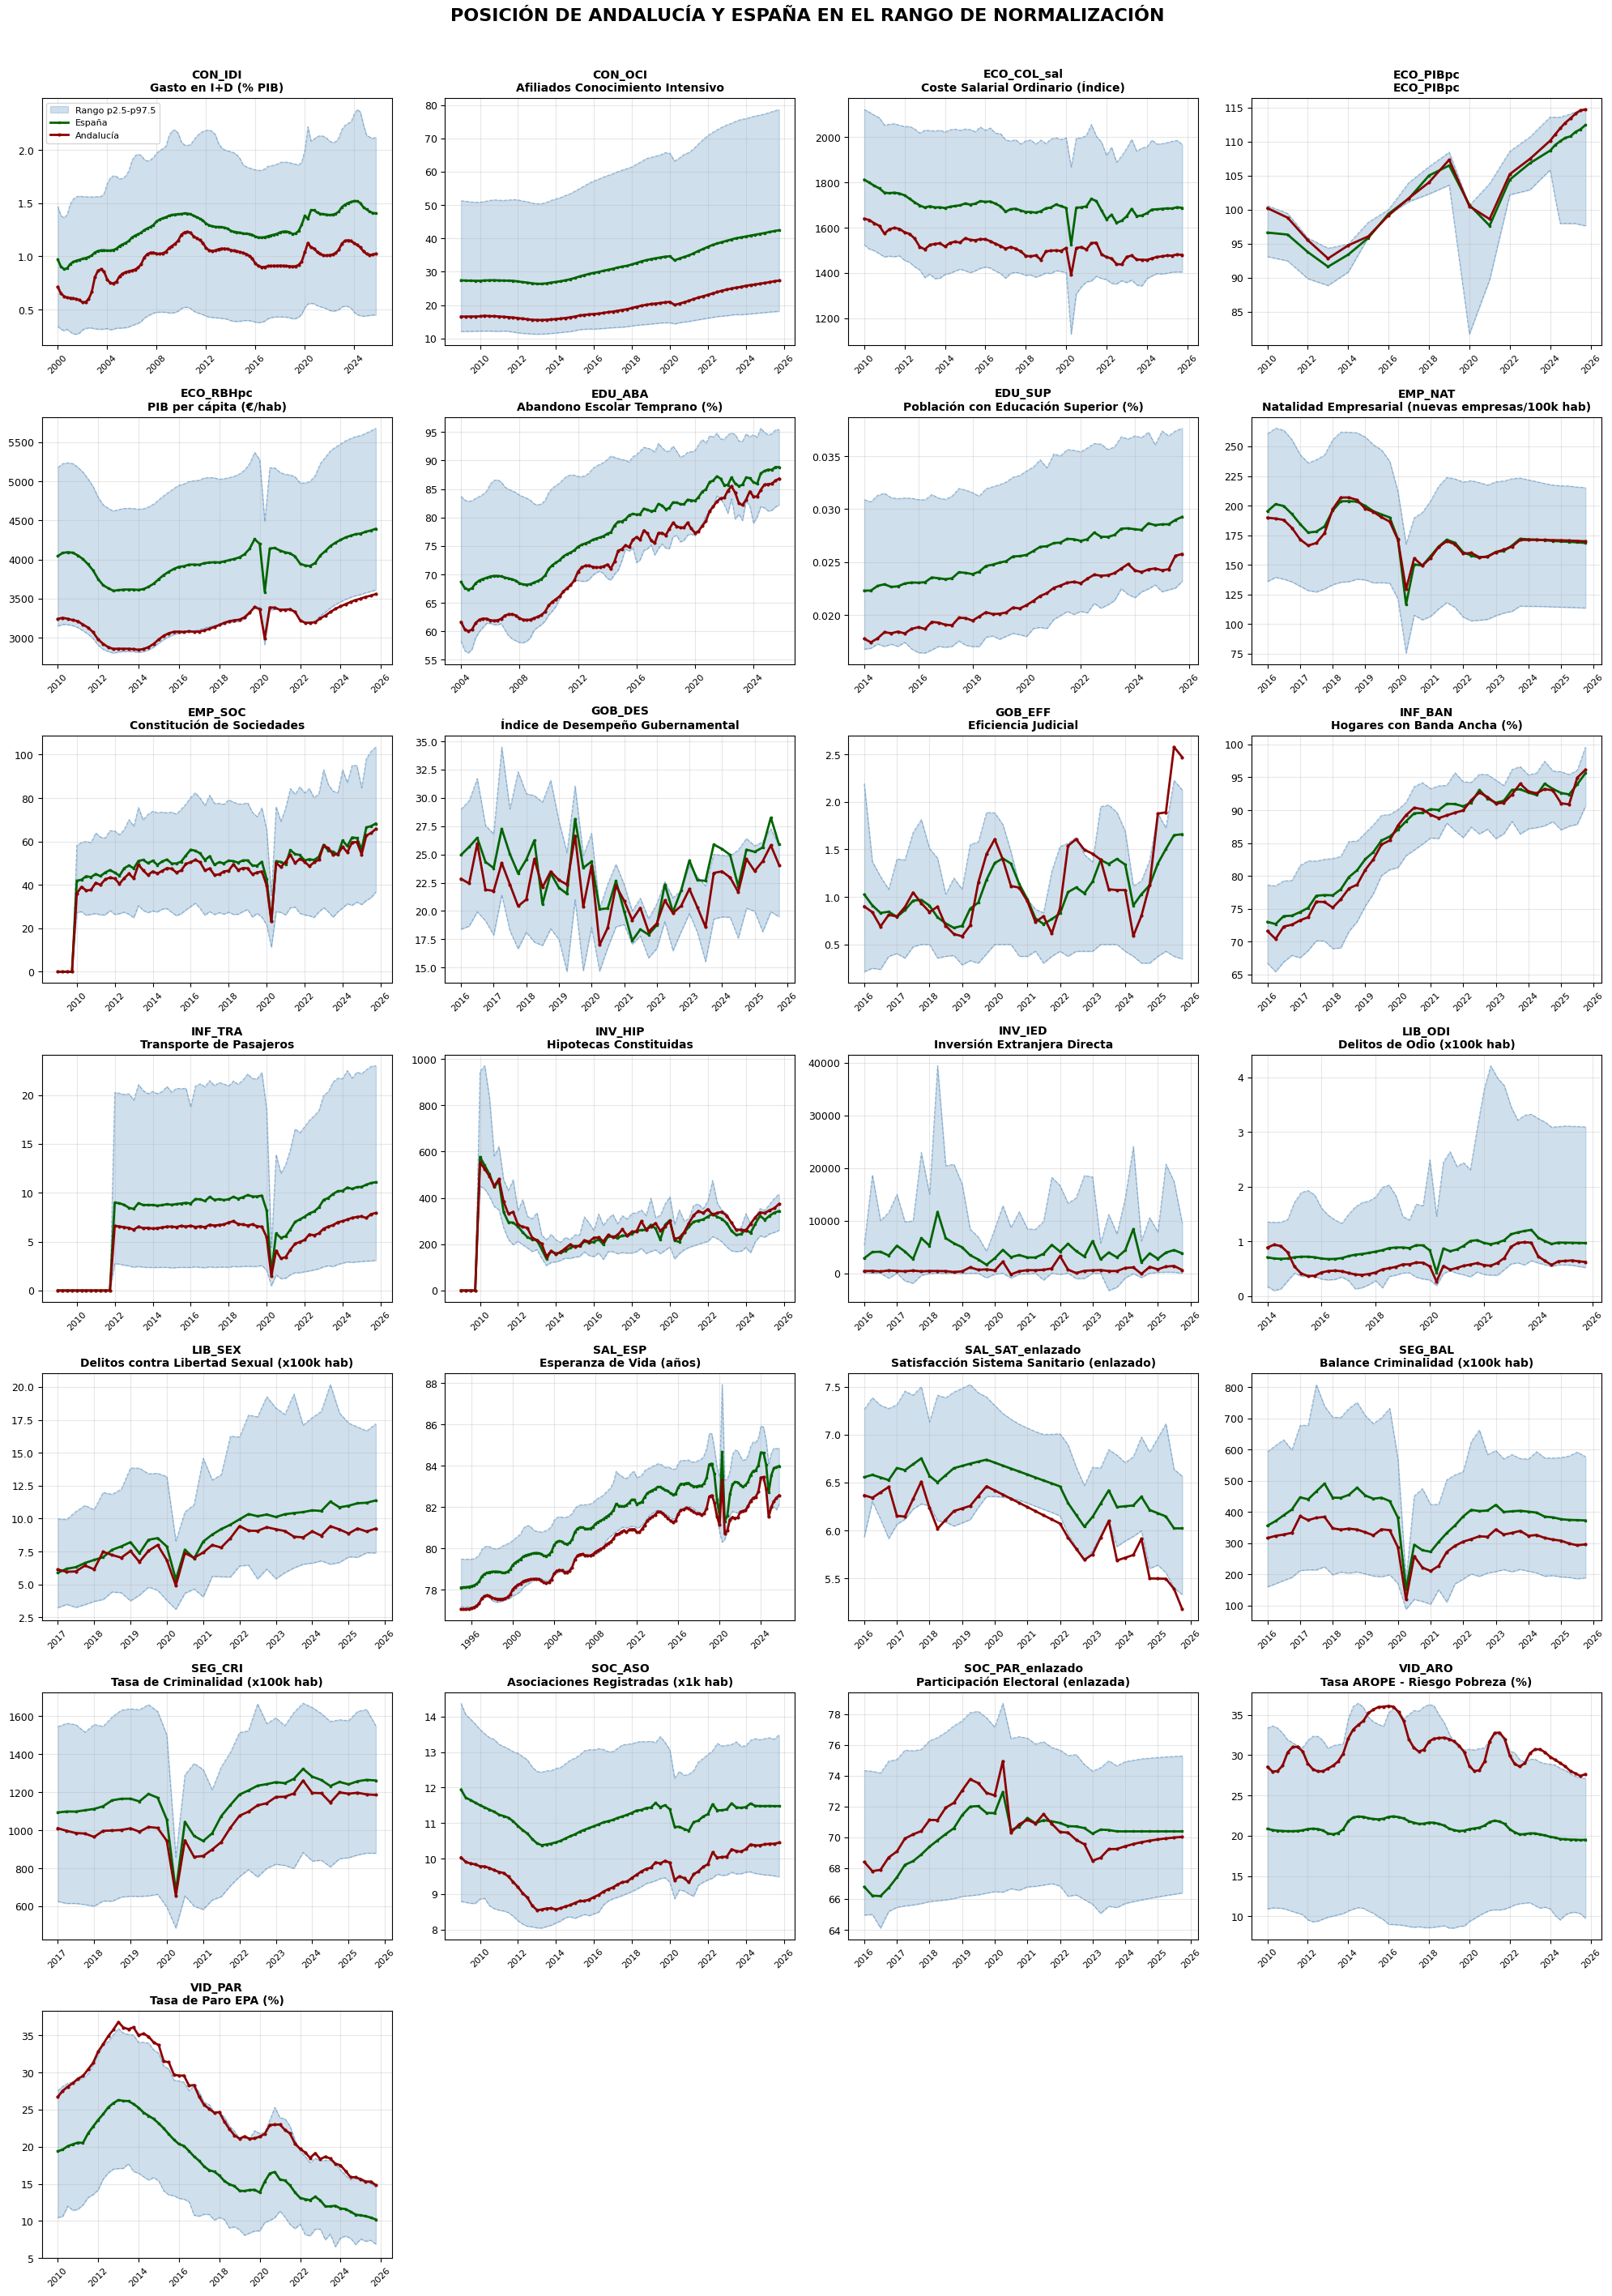

In [26]:
# === PANEL: EVOLUCIÓN DE PERCENTILES CON ANDALUCÍA Y ESPAÑA ===
import matplotlib.pyplot as plt
import numpy as np
import math

# DICCIONARIO DE NOMBRES DESCRIPTIVOS
NOMBRES_INDICADORES = {
    'ECO_COL_sal': 'Coste Salarial Ordinario (Índice)',
    'CON_IDI': 'Gasto en I+D (% PIB)',
    'CON_OCI': 'Afiliados Conocimiento Intensivo',
    'ECO_RBHpc': 'PIB per cápita (€/hab)',
    'EDU_ABA': 'Abandono Escolar Temprano (%)',
    'EDU_SUP': 'Población con Educación Superior (%)',
    'EMP_NAT': 'Natalidad Empresarial (nuevas empresas/100k hab)',
    'EMP_SOC': 'Constitución de Sociedades',
    'GOB_COR': 'Procesos por Corrupción',
    'GOB_DES': 'Índice de Desempeño Gubernamental',
    'GOB_EFF': 'Eficiencia Judicial',
    'INF_BAN': 'Hogares con Banda Ancha (%)',
    'INF_TRA': 'Transporte de Pasajeros',
    'INV_HIP': 'Hipotecas Constituidas',
    'INV_IED': 'Inversión Extranjera Directa',
    'LIB_ODI': 'Delitos de Odio (x100k hab)',
    'LIB_SEX': 'Delitos contra Libertad Sexual (x100k hab)',
    'SAL_ESP': 'Esperanza de Vida (años)',
    'SAL_SAT': 'Satisfacción Sistema Sanitario',
    'SAL_SAT_enlazado': 'Satisfacción Sistema Sanitario (enlazado)',
    'SEG_BAL': 'Balance Criminalidad (x100k hab)',
    'SEG_CRI': 'Tasa de Criminalidad (x100k hab)',
    'SOC_ASO': 'Asociaciones Registradas (x1k hab)',
    'SOC_PAR': 'Participación Electoral (%)',
    'SOC_PAR_enlazado': 'Participación Electoral (enlazada)',
    'VID_ARO': 'Tasa AROPE - Riesgo Pobreza (%)',
    'VID_PAR': 'Tasa de Paro EPA (%)',
}

# Obtener indicadores únicos
cols_indicadores = [c for c in df_trim.columns if not c.startswith('AUX_')]
indicadores_unicos = sorted(set(c.rsplit('_', 1)[0] for c in cols_indicadores))

n_cols = 4
n_rows = math.ceil(len(indicadores_unicos) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, ind in enumerate(indicadores_unicos):
    ax = axes[i]
    
    # Columnas de este indicador
    cols_ind = [c for c in df_trim.columns if c.startswith(f"{ind}_") and not c.startswith('AUX_')]
    col_and = f"{ind}_AND"
    col_esp = f"{ind}_ESP"
    
    if not cols_ind:
        ax.text(0.5, 0.5, "Sin datos", ha='center', va='center')
        ax.set_title(ind)
        continue
    
    # Calcular percentiles por periodo
    periodos, p2_5, p97_5, val_and, val_esp = [], [], [], [], []
    
    for periodo in df_trim.index:
        valores = [df_trim.loc[periodo, col] for col in cols_ind if pd.notna(df_trim.loc[periodo, col])]
        if len(valores) < 3:
            continue
        
        periodos.append(periodo)
        p2_5.append(np.percentile(valores, 2.5))
        p97_5.append(np.percentile(valores, 97.5))
        
        # Valor de Andalucía
        if col_and in df_trim.columns and pd.notna(df_trim.loc[periodo, col_and]):
            val_and.append(df_trim.loc[periodo, col_and])
        else:
            val_and.append(np.nan)
        
        # Valor de España
        if col_esp in df_trim.columns and pd.notna(df_trim.loc[periodo, col_esp]):
            val_esp.append(df_trim.loc[periodo, col_esp])
        else:
            val_esp.append(np.nan)
    
    if not periodos:
        ax.text(0.5, 0.5, "Sin datos suficientes", ha='center', va='center')
        ax.set_title(ind)
        continue
    
    # Convertir a series para plot
    idx = pd.PeriodIndex(periodos).to_timestamp()
    
    # Banda de percentiles
    ax.fill_between(idx, p2_5, p97_5, alpha=0.25, color='steelblue', label='Rango p2.5-p97.5')
    
    # Líneas de referencia
    ax.plot(idx, p2_5, color='steelblue', linewidth=0.8, linestyle='--', alpha=0.5)
    ax.plot(idx, p97_5, color='steelblue', linewidth=0.8, linestyle='--', alpha=0.5)
    
    # Línea de España (verde)
    ax.plot(idx, val_esp, color='darkgreen', linewidth=2, marker='s', markersize=2, label='España')
    
    # Línea de Andalucía (rojo)
    ax.plot(idx, val_and, color='darkred', linewidth=2, marker='o', markersize=2, label='Andalucía')
    
    # Título descriptivo
    nombre = NOMBRES_INDICADORES.get(ind, ind)
    ax.set_title(f"{ind}\n{nombre}", fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    
    # Leyenda solo en la primera
    if i == 0:
        ax.legend(loc='upper left', fontsize=8)

# Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("POSICIÓN DE ANDALUCÍA Y ESPAÑA EN EL RANGO DE NORMALIZACIÓN", 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()

# Guardar
import os
os.makedirs('results/figures/analysis', exist_ok=True)
plt.savefig('results/figures/analysis/percentiles_and_esp.png', dpi=150, bbox_inches='tight')
print("✓ Guardado en results/figures/analysis/percentiles_and_esp.png")

plt.show()



In [27]:
# === RANKING ACTUAL (Último trimestre) ===
ultimo_q = df_norm.index[-1]
print(f"=== RANKING EN {ultimo_q} ===\n")

for ind in indicadores_unicos[:5]:  # Primeros 5
    cols_ind = [c for c in df_norm.columns if c.startswith(f"{ind}_")]
    if not cols_ind:
        continue
    
    ranking = df_norm.loc[ultimo_q, cols_ind].dropna().sort_values(ascending=False)
    top3 = ranking.head(3)
    bottom3 = ranking.tail(3)
    
    print(f"\n{ind}:")
    print(f"  🥇 TOP: {', '.join([c.split('_')[-1] + f'({v:.0f})' for c, v in top3.items()])}")
    print(f"  🔻 BOTTOM: {', '.join([c.split('_')[-1] + f'({v:.0f})' for c, v in bottom3.items()])}")

=== RANKING EN 2025Q4 ===


CON_IDI:
  🥇 TOP: PV(98), NAV(96), MAD(94)
  🔻 BOTTOM: CLM(26), CAN(25), BAL(18)

CON_OCI:
  🥇 TOP: MAD(120), CAT(75), ESP(58)
  🔻 BOTTOM: RIO(31), EXT(28), CLM(23)

ECO_COL_sal:
  🥇 TOP: MAD(106), PV(99), CAT(95)
  🔻 BOTTOM: MUR(77), CAN(74), EXT(73)

ECO_PIBpc:
  🥇 TOP: AND(92), GAL(92), ESP(90)
  🔻 BOTTOM: CAT(80), MUR(79), BAL(77)

ECO_RBHpc:
  🥇 TOP: PV(98), MAD(91), NAV(86)
  🔻 BOTTOM: CLM(62), CAN(61), AND(59)


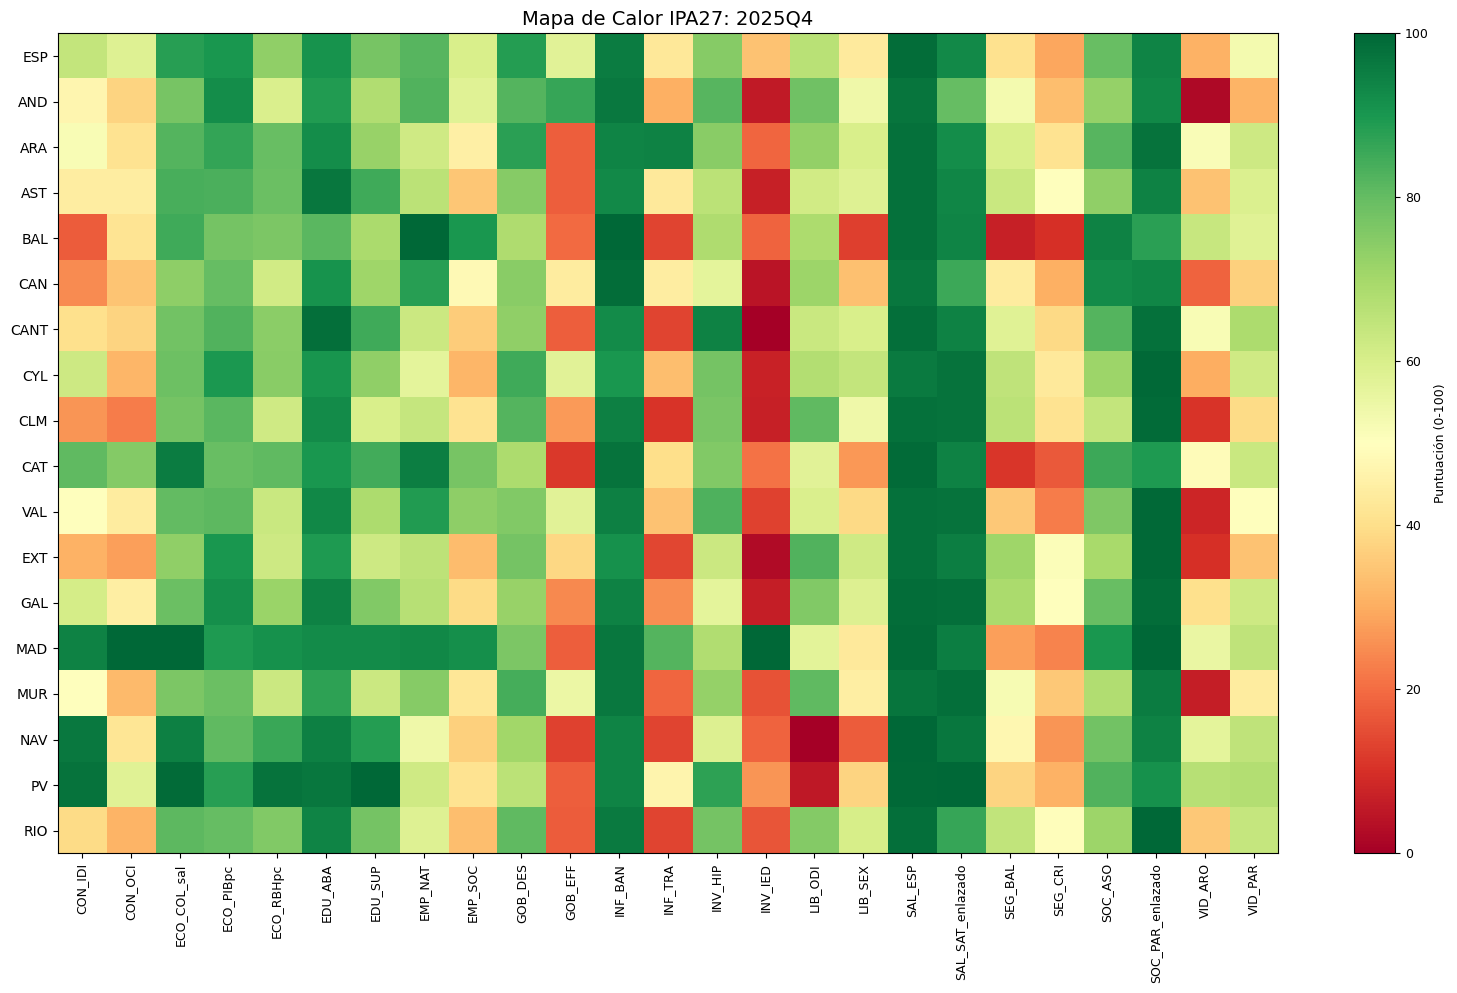

In [28]:
# === HEATMAP ÚLTIMO TRIMESTRE ===
import matplotlib.pyplot as plt
import numpy as np

ultimo_q = df_norm.index[-1]

# Crear matriz
matrix = []
regiones = []
indicadores = []

for reg in REGIONES:
    fila = []
    for ind in indicadores_unicos:
        col = f"{ind}_{reg}"
        val = df_norm.loc[ultimo_q, col] if col in df_norm.columns else np.nan
        fila.append(val)
    matrix.append(fila)
    regiones.append(reg)

indicadores = indicadores_unicos

fig, ax = plt.subplots(figsize=(16, 10))
im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

ax.set_xticks(range(len(indicadores)))
ax.set_xticklabels(indicadores, rotation=90, fontsize=9)
ax.set_yticks(range(len(regiones)))
ax.set_yticklabels(regiones, fontsize=10)

plt.colorbar(im, label='Puntuación (0-100)')
ax.set_title(f"Mapa de Calor IPA27: {ultimo_q}", fontsize=14)
plt.tight_layout()
plt.show()

In [29]:
# === EXPORTAR AUDITORÍA COMPLETA ===
with pd.ExcelWriter('results/data/auditoria_normalizacion.xlsx') as writer:
    # Hoja 1: Datos originales (AND)
    cols_and = [c for c in df_trim.columns if c.endswith('_AND') and not c.startswith('AUX_')]
    df_trim[cols_and].to_excel(writer, sheet_name='1_Originales_AND')
    
    # Hoja 2: Datos normalizados (AND)
    cols_and_norm = [c for c in df_norm.columns if c.endswith('_AND')]
    df_norm[cols_and_norm].to_excel(writer, sheet_name='2_Normalizados_AND')
    
    # Hoja 3: Ranking último Q (todas las regiones)
    ultimo_q = df_norm.index[-1]
    df_ranking = df_norm.loc[ultimo_q].to_frame('Puntuacion')
    df_ranking['Indicador'] = df_ranking.index.map(lambda x: x.rsplit('_', 1)[0])
    df_ranking['Region'] = df_ranking.index.map(lambda x: x.rsplit('_', 1)[1])
    df_ranking.to_excel(writer, sheet_name='3_Ranking_UltimoQ')

print("✓ Auditoría exportada a results/data/auditoria_normalizacion.xlsx")

✓ Auditoría exportada a results/data/auditoria_normalizacion.xlsx


In [ ]:
# %% INSPECCIÓN POST-NORMALIZACIÓN (df_norm)
import matplotlib.pyplot as plt
import math
import pandas as pd

print("="*60)
print("RADIOGRAFÍA DE ANDALUCÍA (NORMALIZADO 0-100)")
print("="*60)

if 'df_norm' not in locals():
    print("⚠️ 'df_norm' no existe. Ejecuta la normalización primero.")
else:
    # Filtrar columnas de AND en el dataframe normalizado
    cols_and = [c for c in df_norm.columns if c.endswith('_AND')]
    cols_and.sort()

    n_cols = 3
    n_rows = math.ceil(len(cols_and) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2.5 * n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(cols_and):
        ax = axes[i]
        serie = df_norm[col].dropna()
        
        # Filtrar desde 2016
        serie = serie[serie.index >= pd.Period('2016Q1', freq='Q')]
        
        if not serie.empty:
            idx = serie.index.to_timestamp() if hasattr(serie.index, 'to_timestamp') else serie.index
            ax.plot(idx, serie.values, color='purple', linewidth=1.5)
            
            # Líneas de referencia (0, 50, 100)
            ax.axhline(50, color='gray', linestyle=':', alpha=0.5)
            ax.axhline(100, color='green', linestyle='--', alpha=0.2)
            ax.axhline(0, color='red', linestyle='--', alpha=0.2)
            
            ax.set_ylim(-5, 105) # Para ver si se saturan en 0 o 100
            ax.set_title(f"{col} (0-100)", fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

RADIOGRAFÍA DE ANDALUCÍA (NORMALIZADO 0-100)


## 11. Agregación (Pilares → Dominios → IPA27)

Aplicamos la metodología Legatum de **promedios simples** (no ponderados) para agregar:

### Estructura jerárquica:

**NIVEL 1: Indicadores** (28 indicadores normalizados 0-100)
↓ *promedio simple*

**NIVEL 2: Pilares** (12 pilares)
- **Sociedades Inclusivas**
  - 1. Seguridad (SEG_BAL, SEG_CRI)
  - 2. Libertad (LIB_ODI, LIB_SEX)
  - 3. Gobernanza (GOB_DES, GOB_TRA)
  - 4. Capital Social (SOC_ASO, SOC_PAR_enlazado)
- **Economías Abiertas**
  - 5. Inversión (INV_HIP, INV_IED)
  - 6. Empresas (EMP_NAT, EMP_SOC)
  - 7. Infraestructura (INF_BAN, INF_TRA)
  - 8. Calidad Económica (ECO_PIT)
- **Personas Empoderadas**
  - 9. Vida (VID_ARO, VID_PAR)
  - 10. Salud (SAL_ESP, SAL_SAT_enlazado)
  - 11. Educación (EDU_ABA, EDU_SUP)
  - 12. Conocimiento (CON_IDI, CON_OCI)

↓ *promedio simple*

**NIVEL 3: Dominios** (3 dominios)
- Sociedades Inclusivas (promedio de pilares 1-4)
- Economías Abiertas (promedio de pilares 5-8)
- Personas Empoderadas (promedio de pilares 9-12)

↓ *promedio simple*

**NIVEL 4: IPA27** (Índice global)
- Promedio de los 3 dominios

In [ ]:
# %% AGREGACIÓN JERÁRQUICA (Media Geométrica)
import pandas as pd
import numpy as np

print("=" * 60)
print("AGREGACIÓN (Media Geométrica - IPA27)")
print("=" * 60)

# === FUNCIÓN DE MEDIA GEOMÉTRICA ROBUSTA ===
def media_geometrica(df_componentes, pesos=None, floor=1.0):
    """
    Calcula la media geométrica ponderada por filas.
    
    Parámetros:
    - df_componentes: DataFrame donde cada columna es un componente
    - pesos: dict {nombre_col: peso} o None para equiponderado
    - floor: valor mínimo para evitar log(0). Default 1.0
    
    Retorna: Series con la media geométrica por periodo
    """
    if pesos is None:
        pesos = {col: 1.0 for col in df_componentes.columns}
    
    resultado = pd.Series(index=df_componentes.index, dtype=float)
    
    for idx in df_componentes.index:
        fila = df_componentes.loc[idx]
        
        # Filtrar NaNs
        validos = fila.dropna()
        
        if len(validos) == 0:
            resultado[idx] = np.nan
            continue
        
        # Aplicar floor para evitar log(0)
        validos = validos.clip(lower=floor)
        
        # Pesos de los componentes válidos
        w = np.array([pesos.get(col, 1.0) for col in validos.index])
        v = validos.values
        
        # Media geométrica ponderada: exp(Σ(w_i * ln(v_i)) / Σ(w_i))
        suma_pesos = w.sum()
        if suma_pesos == 0:
            resultado[idx] = np.nan
            continue
        
        log_media = np.sum(w * np.log(v)) / suma_pesos
        resultado[idx] = np.exp(log_media)
    
    return resultado

# === DataFrames para resultados ===
df_pilares = pd.DataFrame(index=df_norm.index)
df_dominios = pd.DataFrame(index=df_norm.index)
df_ipa27 = pd.DataFrame(index=df_norm.index)

# =============================================================================
# NIVEL 1 → NIVEL 2: Indicadores → Pilares
# =============================================================================
print("\n📊 NIVEL 1 → NIVEL 2: Indicadores → Pilares (Media Geométrica)")
print("-" * 60)

for dominio, pilares in ESTRUCTURA.items():
    print(f"\n{dominio}:")
    
    for pilar, indicadores in pilares.items():
        n_indicadores = len(indicadores)
        
        for region in REGIONES:
            col_pilar = f"{pilar}_{region}"
            
            # Columnas de los indicadores de este pilar para esta región
            cols_ind = [f"{ind}_{region}" for ind in indicadores]
            cols_disponibles = [c for c in cols_ind if c in df_norm.columns]
            
            if not cols_disponibles:
                continue
            
            # Media geométrica (equiponderada por ahora)
            df_pilares[col_pilar] = media_geometrica(df_norm[cols_disponibles])
        
        # Estadísticas para AND
        col_and = f"{pilar}_AND"
        if col_and in df_pilares.columns:
            media_and = df_pilares[col_and].mean()
            n_obs = df_pilares[col_and].notna().sum()
            print(f"  {pilar:<30} AND: {media_and:>6.1f} ({n_obs} obs) | {n_indicadores} ind | GEOM")

print(f"\n✓ Pilares calculados: {len([c for c in df_pilares.columns if c.endswith('_AND')])}")

# =============================================================================
# NIVEL 2 → NIVEL 3: Pilares → Dominios
# =============================================================================
print("\n📊 NIVEL 2 → NIVEL 3: Pilares → Dominios (Media Geométrica)")
print("-" * 60)

for dominio, pilares in ESTRUCTURA.items():
    for region in REGIONES:
        col_dominio = f"{dominio}_{region}"
        
        cols_pilares = [f"{p}_{region}" for p in pilares.keys()]
        cols_disponibles = [c for c in cols_pilares if c in df_pilares.columns]
        
        if not cols_disponibles:
            continue
        
        df_dominios[col_dominio] = media_geometrica(df_pilares[cols_disponibles])
    
    col_and = f"{dominio}_AND"
    col_esp = f"{dominio}_ESP"
    
    if col_and in df_dominios.columns:
        media_and = df_dominios[col_and].mean()
        media_esp = df_dominios[col_esp].mean() if col_esp in df_dominios.columns else 0
        n_pilares = len(pilares)
        print(f"  {dominio:<30} AND: {media_and:>6.1f} | ESP: {media_esp:>6.1f} | {n_pilares} pilares | GEOM")

print(f"\n✓ Dominios calculados: 3")

# =============================================================================
# NIVEL 3 → NIVEL 4: Dominios → IPA27
# =============================================================================
print("\n📊 NIVEL 3 → NIVEL 4: Dominios → IPA27 (Media Geométrica)")
print("-" * 60)

for region in REGIONES:
    col_ipa = f"IPA27_{region}"
    
    cols_dom = [f"{dom}_{region}" for dom in ESTRUCTURA.keys()]
    cols_disponibles = [c for c in cols_dom if c in df_dominios.columns]
    
    if not cols_disponibles:
        continue
    
    df_ipa27[col_ipa] = media_geometrica(df_dominios[cols_disponibles])

# === Reporte final ===
print(f"\nÍndice IPA27 (últimos 4 trimestres):")
print(f"{'Periodo':<12} {'AND':>8} {'ESP':>8} {'Diff':>8} {'Ratio':>8}")
print("-" * 48)

ultimos_4 = df_ipa27.tail(4)
for periodo in ultimos_4.index:
    if 'IPA27_AND' in df_ipa27.columns and 'IPA27_ESP' in df_ipa27.columns:
        val_and = df_ipa27.loc[periodo, 'IPA27_AND']
        val_esp = df_ipa27.loc[periodo, 'IPA27_ESP']
        if pd.notna(val_and) and pd.notna(val_esp):
            diff = val_and - val_esp
            ratio = val_and / val_esp * 100 if val_esp != 0 else np.nan
            print(f"{periodo!s:<12} {val_and:>8.2f} {val_esp:>8.2f} {diff:>+8.2f} {ratio:>7.1f}%")

# === Comparativa: efecto de la media geométrica ===
# Mostrar un ejemplo de penalización por desequilibrio
print("\n📐 Efecto de la media geométrica (ejemplo AND, último periodo):")
ultimo = df_norm.index[-1]
for dominio, pilares in ESTRUCTURA.items():
    cols_p = [f"{p}_AND" for p in pilares.keys() if f"{p}_AND" in df_pilares.columns]
    if cols_p:
        vals = [df_pilares.loc[ultimo, c] for c in cols_p if pd.notna(df_pilares.loc[ultimo, c])]
        if vals:
            aritm = np.mean(vals)
            geom = np.exp(np.mean(np.log(np.clip(vals, 1, None))))
            penalty = aritm - geom
            print(f"  {dominio:<30} Aritm: {aritm:.1f} | Geom: {geom:.1f} | Penalización: {penalty:+.1f}")

print("\n✓ IPA27 calculado con media geométrica para todas las regiones")
print("=" * 60)


AGREGACIÓN (Media Geométrica - IPA27)

📊 NIVEL 1 → NIVEL 2: Indicadores → Pilares (Media Geométrica)
------------------------------------------------------------

Sociedades Inclusivas:
  1. Seguridad                   AND:   45.7 (40 obs) | 2 ind | GEOM
  2. Libertad                    AND:   71.8 (48 obs) | 2 ind | GEOM
  3. Gobernanza                  AND:   53.4 (40 obs) | 2 ind | GEOM
  4. Capital Social              AND:   73.1 (68 obs) | 2 ind | GEOM

Economías Abiertas:
  5. Inversión                   AND:   36.7 (68 obs) | 2 ind | GEOM
  6. Empresas                    AND:   49.6 (68 obs) | 2 ind | GEOM
  7. Infraestructura             AND:   32.5 (68 obs) | 2 ind | GEOM
  8. Calidad Económica           AND:   64.8 (64 obs) | 2 ind | GEOM

Personas Empoderadas:
  9. Vida                        AND:    2.0 (64 obs) | 2 ind | GEOM
  10. Salud                      AND:   93.6 (124 obs) | 2 ind | GEOM
  11. Educación                  AND:   67.0 (88 obs) | 2 ind | GEOM
  12. Cono

📊 Generando Radar Charts para el periodo: 2025Q4


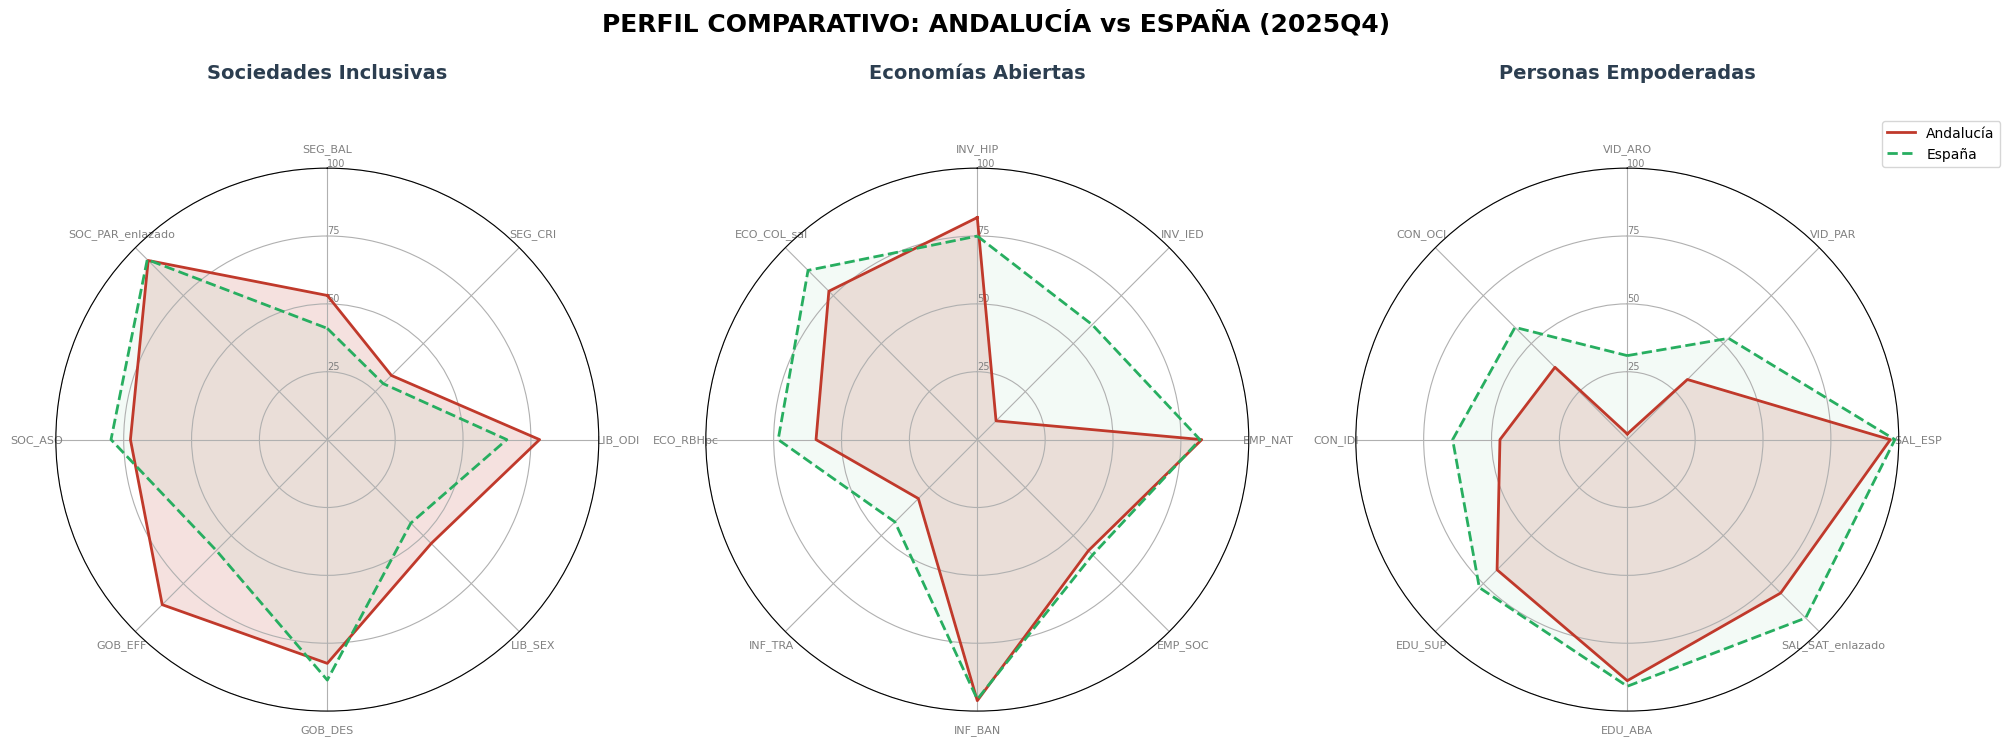

In [ ]:
# %% CELDA 12B: VISUALIZACIÓN RADAR POR DOMINIO (AND vs ESP)
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# 1. Función para crear el gráfico de radar
def make_radar_chart(title, labels, values_and, values_esp, ax):
    N = len(labels)
    # Ángulos para cada eje
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Cerrar el círculo
    
    # Valores (cerrando el círculo)
    v_and = list(values_and) + [values_and[0]]
    v_esp = list(values_esp) + [values_esp[0]]
    
    # Configuración del eje polar
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Dibujar etiquetas de indicadores
    plt.xticks(angles[:-1], labels, color='grey', size=8)
    
    # Dibujar círculos de escala (0-100)
    ax.set_rlabel_position(0)
    plt.yticks([25, 50, 75, 100], ["25", "50", "75", "100"], color="grey", size=7)
    plt.ylim(0, 100)
    
    # Dibujar datos Andalucía (Rojo)
    ax.plot(angles, v_and, linewidth=2, linestyle='solid', color='#c0392b', label='Andalucía')
    ax.fill(angles, v_and, color='#c0392b', alpha=0.15)
    
    # Dibujar datos España (Verde)
    ax.plot(angles, v_esp, linewidth=2, linestyle='dashed', color='#27ae60', label='España')
    ax.fill(angles, v_esp, color='#27ae60', alpha=0.05)
    
    ax.set_title(title, size=14, color='#2c3e50', y=1.15, fontweight='bold')

# 2. Preparar los datos
# Usamos el último trimestre con datos completos
ultimo_q = df_norm.dropna(how='all').index[-1]
print(f"📊 Generando Radar Charts para el periodo: {ultimo_q}")

# Configurar el panel de 3 gráficos (uno por dominio)
fig = plt.figure(figsize=(20, 7))

for i, (dominio, pilares) in enumerate(ESTRUCTURA.items()):
    ax = plt.subplot(1, 3, i+1, polar=True)
    
    # Aplanar la lista de indicadores para este dominio
    indicadores = []
    for pilar_inds in pilares.values():
        indicadores.extend(pilar_inds)
    
    # Filtrar solo indicadores que existen en df_norm
    indicadores = [ind for ind in indicadores if f"{ind}_AND" in df_norm.columns]
    
    if not indicadores:
        continue
        
    # Obtener etiquetas descriptivas y valores
    # labels = [NOMBRES_INDICADORES.get(ind, ind).split('(')[0].strip() for ind in indicadores]
    # Si NOMBRES_INDICADORES no está en el scope, lo definimos o usamos el código
    labels = [ind for ind in indicadores] 
    
    vals_and = [df_norm.loc[ultimo_q, f"{ind}_AND"] for ind in indicadores]
    vals_esp = [df_norm.loc[ultimo_q, f"{ind}_ESP"] for ind in indicadores]
    
    # Asegurar que no haya NaNs en el radar (convertir a 0 o interpolar)
    vals_and = [v if pd.notna(v) else 0 for v in vals_and]
    vals_esp = [v if pd.notna(v) else 0 for v in vals_esp]
    
    make_radar_chart(dominio, labels, vals_and, vals_esp, ax)

# Añadir leyenda global
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10)
plt.suptitle(f"PERFIL COMPARATIVO: ANDALUCÍA vs ESPAÑA ({ultimo_q})", fontsize=18, y=1.05, fontweight='bold')
plt.tight_layout()

# Guardar figura
plt.savefig('results/figures/analysis/radar_dominios_and_esp.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Filtro Temporal y Análisis de Impacto

### Filtro desde 2016Q1
El IPA27 tiene sentido solo desde 2016Q1, cuando la mayoría de indicadores tienen cobertura.

### Análisis de Contribución por Nivel

**NIVEL 1: Contribución de Indicadores a Pilares**
```
Contribución_Indicador = (Valor_Indicador / Promedio_Pilar) × 100
```

**NIVEL 2: Contribución de Pilares a Dominios**
```
Contribución_Pilar = (Valor_Pilar / Promedio_Dominio) × 100
```

**NIVEL 3: Contribución de Dominios a IPA27**
```
Contribución_Dominio = (Valor_Dominio / IPA27) × 100
```

### Diagnóstico de Problemas
- Indicadores con muchos NaNs
- Valores extremos (outliers)
- Inconsistencias temporales

In [ ]:
# %% FILTRO TEMPORAL Y ANÁLISIS DE CONTRIBUCIÓN (Media Geométrica)
import pandas as pd
import numpy as np

print("=" * 60)
print("FILTRO TEMPORAL Y ANÁLISIS DE CONTRIBUCIÓN")
print("=" * 60)

# =============================================================================
# 1. FILTRO DESDE 2016Q1
# =============================================================================
print("\n📅 Aplicando filtro temporal desde 2016Q1...")

fecha_inicio = pd.Period('2016Q1', freq='Q')

df_norm_filtrado = df_norm[(df_norm.index >= fecha_inicio) & (df_norm.index <= Q_OBJETIVO)].copy()
df_pilares_filtrado = df_pilares[(df_pilares.index >= fecha_inicio) & (df_pilares.index <= Q_OBJETIVO)].copy()
df_dominios_filtrado = df_dominios[(df_dominios.index >= fecha_inicio) & (df_dominios.index <= Q_OBJETIVO)].copy()
df_ipa27_filtrado = df_ipa27[(df_ipa27.index >= fecha_inicio) & (df_ipa27.index <= Q_OBJETIVO)].copy()

print(f"  Periodo original: {df_ipa27.index.min()} → {df_ipa27.index.max()}")
print(f"  Periodo filtrado: {df_ipa27_filtrado.index.min()} → {df_ipa27_filtrado.index.max()}")
print(f"  Trimestres eliminados: {len(df_ipa27) - len(df_ipa27_filtrado)}")
print(f"  Trimestres válidos: {len(df_ipa27_filtrado)}")

df_norm = df_norm_filtrado
df_pilares = df_pilares_filtrado
df_dominios = df_dominios_filtrado
df_ipa27 = df_ipa27_filtrado

# =============================================================================
# 2. ANÁLISIS DE CONTRIBUCIÓN - INDICADORES A PILARES (AND)
# =============================================================================
print("\n📊 NIVEL 1: Análisis de Indicadores dentro de Pilares (Andalucía)")
print("-" * 60)

analisis_ind = []

for dominio, pilares in ESTRUCTURA.items():
    for pilar, indicadores in pilares.items():
        col_pilar = f"{pilar}_AND"
        
        if col_pilar not in df_pilares.columns:
            continue
        
        # Para cada periodo, analizar los componentes
        for periodo in df_pilares.index:
            valor_pilar = df_pilares.loc[periodo, col_pilar]
            
            if pd.isna(valor_pilar):
                continue
            
            valores_ind = {}
            for ind in indicadores:
                col_ind = f"{ind}_AND"
                if col_ind in df_norm.columns:
                    val = df_norm.loc[periodo, col_ind]
                    if pd.notna(val):
                        valores_ind[ind] = val
            
            if len(valores_ind) < 2:
                continue
            
            vals = list(valores_ind.values())
            media_arit = np.mean(vals)
            media_geom = np.exp(np.mean(np.log(np.clip(vals, 1, None))))
            penalizacion = media_arit - media_geom
            
            cuello_botella = min(valores_ind, key=valores_ind.get)
            fortaleza = max(valores_ind, key=valores_ind.get)
            dispersion = max(vals) - min(vals)
            
            for ind, val in valores_ind.items():
                analisis_ind.append({
                    'Periodo': periodo,
                    'Dominio': dominio,
                    'Pilar': pilar,
                    'Indicador': ind,
                    'Score': val,
                    'Pilar_Geom': valor_pilar,
                    'Pilar_Aritm': media_arit,
                    'Penalizacion_Deseq': penalizacion,
                    'Es_Cuello_Botella': ind == cuello_botella,
                    'Es_Fortaleza': ind == fortaleza,
                    'Dispersion': dispersion
                })

df_contrib_ind = pd.DataFrame(analisis_ind)

if len(df_contrib_ind) > 0:
    # Promedio por indicador
    resumen_ind = df_contrib_ind.groupby('Indicador').agg({
        'Score': 'mean',
        'Es_Cuello_Botella': 'mean',  # % de veces que es cuello de botella
        'Es_Fortaleza': 'mean'
    }).round(2)
    
    resumen_ind.columns = ['Score_Medio', 'Pct_Cuello_Botella', 'Pct_Fortaleza']
    resumen_ind = resumen_ind.sort_values('Score_Medio')
    
    print("\n🔴 TOP 5 Cuellos de botella (score medio más bajo):")
    for ind, row in resumen_ind.head(5).iterrows():
        print(f"  {ind:<20} Score: {row['Score_Medio']:>6.1f} | Cuello {row['Pct_Cuello_Botella']*100:>4.0f}% del tiempo")
    
    print("\n🟢 TOP 5 Fortalezas (score medio más alto):")
    for ind, row in resumen_ind.tail(5).iloc[::-1].iterrows():
        print(f"  {ind:<20} Score: {row['Score_Medio']:>6.1f} | Fortaleza {row['Pct_Fortaleza']*100:>4.0f}% del tiempo")
    
    # Penalización por desequilibrio por pilar
    print("\n📐 Penalización por desequilibrio (Aritmética - Geométrica) por pilar:")
    penal_pilar = df_contrib_ind.groupby('Pilar')['Penalizacion_Deseq'].mean().sort_values(ascending=False)
    for pilar, pen in penal_pilar.items():
        print(f"  {pilar:<30} {pen:>+6.2f} puntos")

# =============================================================================
# 3. ANÁLISIS DE CONTRIBUCIÓN - PILARES A DOMINIOS (AND)
# =============================================================================
print("\n📊 NIVEL 2: Análisis de Pilares dentro de Dominios (Andalucía)")
print("-" * 60)

analisis_pilar = []

for dominio, pilares in ESTRUCTURA.items():
    col_dom = f"{dominio}_AND"
    
    if col_dom not in df_dominios.columns:
        continue
    
    for periodo in df_dominios.index:
        valor_dom = df_dominios.loc[periodo, col_dom]
        
        if pd.isna(valor_dom):
            continue
        
        valores_pil = {}
        for pilar in pilares.keys():
            col_p = f"{pilar}_AND"
            if col_p in df_pilares.columns:
                val = df_pilares.loc[periodo, col_p]
                if pd.notna(val):
                    valores_pil[pilar] = val
        
        if len(valores_pil) < 2:
            continue
        
        vals = list(valores_pil.values())
        media_arit = np.mean(vals)
        media_geom = np.exp(np.mean(np.log(np.clip(vals, 1, None))))
        
        cuello = min(valores_pil, key=valores_pil.get)
        fortaleza = max(valores_pil, key=valores_pil.get)
        
        for pilar, val in valores_pil.items():
            analisis_pilar.append({
                'Periodo': periodo,
                'Dominio': dominio,
                'Pilar': pilar,
                'Score': val,
                'Dominio_Geom': valor_dom,
                'Dominio_Aritm': media_arit,
                'Penalizacion_Deseq': media_arit - media_geom,
                'Es_Cuello_Botella': pilar == cuello,
                'Es_Fortaleza': pilar == fortaleza
            })

df_contrib_pilar = pd.DataFrame(analisis_pilar)

if len(df_contrib_pilar) > 0:
    print("\nScore medio por pilar y frecuencia como cuello de botella:")
    for dominio in ESTRUCTURA.keys():
        print(f"\n{dominio}:")
        datos_dom = df_contrib_pilar[df_contrib_pilar['Dominio'] == dominio]
        if len(datos_dom) > 0:
            resumen = datos_dom.groupby('Pilar').agg({
                'Score': 'mean',
                'Es_Cuello_Botella': 'mean'
            }).sort_values('Score')
            for pilar, row in resumen.iterrows():
                marker = "🔴" if row['Es_Cuello_Botella'] > 0.5 else "  "
                print(f"  {marker} {pilar:<30} Score: {row['Score']:>6.1f} | Cuello: {row['Es_Cuello_Botella']*100:>4.0f}%")

# =============================================================================
# 4. ANÁLISIS DE CONTRIBUCIÓN - DOMINIOS A IPA27 (AND)
# =============================================================================
print("\n📊 NIVEL 3: Análisis de Dominios en IPA27 (Andalucía)")
print("-" * 60)

analisis_dom = []

for periodo in df_ipa27.index:
    val_ipa = df_ipa27.loc[periodo, 'IPA27_AND'] if 'IPA27_AND' in df_ipa27.columns else np.nan
    
    if pd.isna(val_ipa):
        continue
    
    valores_dom = {}
    for dominio in ESTRUCTURA.keys():
        col_d = f"{dominio}_AND"
        if col_d in df_dominios.columns:
            val = df_dominios.loc[periodo, col_d]
            if pd.notna(val):
                valores_dom[dominio] = val
    
    if len(valores_dom) < 2:
        continue
    
    vals = list(valores_dom.values())
    media_arit = np.mean(vals)
    media_geom = np.exp(np.mean(np.log(np.clip(vals, 1, None))))
    
    cuello = min(valores_dom, key=valores_dom.get)
    
    for dom, val in valores_dom.items():
        analisis_dom.append({
            'Periodo': periodo,
            'Dominio': dom,
            'Score': val,
            'IPA27_Geom': val_ipa,
            'IPA27_Aritm': media_arit,
            'Penalizacion_Deseq': media_arit - media_geom,
            'Es_Cuello_Botella': dom == cuello
        })

df_contrib_dom = pd.DataFrame(analisis_dom)

if len(df_contrib_dom) > 0:
    resumen_dom = df_contrib_dom.groupby('Dominio').agg({
        'Score': 'mean',
        'Penalizacion_Deseq': 'mean',
        'Es_Cuello_Botella': 'mean'
    }).sort_values('Score')
    
    print("\nScore medio por dominio:")
    for dom, row in resumen_dom.iterrows():
        marker = "🔴" if row['Es_Cuello_Botella'] > 0.5 else "🟢"
        print(f"  {marker} {dom:<35} Score: {row['Score']:>6.1f} | Penal. deseq: {row['Penalizacion_Deseq']:>+5.2f} | Cuello: {row['Es_Cuello_Botella']*100:.0f}%")

# =============================================================================
# 5. DIAGNÓSTICO DE PROBLEMAS
# =============================================================================
print("\n🔍 DIAGNÓSTICO DE PROBLEMAS EN INDICADORES (Andalucía)")
print("-" * 60)

indicadores_and = [c for c in df_norm.columns if c.endswith('_AND') and not c.startswith('AUX_')]
problemas = []

for col in indicadores_and:
    serie = df_norm[col]
    ind_nombre = col.replace('_AND', '')
    
    n_total = len(serie)
    n_nans = serie.isna().sum()
    pct_nans = (n_nans / n_total) * 100
    valores = serie.dropna()
    
    if len(valores) == 0:
        problemas.append({'Indicador': ind_nombre, 'Problema': 'SIN DATOS', 'Detalle': f'{n_nans}/{n_total} NaNs (100%)'})
        continue
    
    if pct_nans > 50:
        problemas.append({'Indicador': ind_nombre, 'Problema': 'MUCHOS NaNs', 'Detalle': f'{n_nans}/{n_total} NaNs ({pct_nans:.1f}%)'})
    
    if valores.min() < 0 or valores.max() > 120:
        problemas.append({'Indicador': ind_nombre, 'Problema': 'VALORES FUERA RANGO', 'Detalle': f'Min={valores.min():.1f}, Max={valores.max():.1f} (rango esperado: 0-120)'})
    
    if len(valores) >= 3:
        std = valores.std()
        if std < 2:
            problemas.append({'Indicador': ind_nombre, 'Problema': 'VARIANZA MUY BAJA', 'Detalle': f'STD={std:.2f} (indicador plano)'})

if problemas:
    df_problemas = pd.DataFrame(problemas)
    print(f"\n⚠️ Se detectaron {len(problemas)} problemas en {len(df_problemas['Indicador'].unique())} indicadores:\n")
    for _, row in df_problemas.iterrows():
        print(f"  {row['Indicador']:<20} → {row['Problema']:<20} | {row['Detalle']}")
else:
    print("\n✅ No se detectaron problemas graves")

print("\n" + "=" * 60)
print("✓ Análisis de contribución completado (metodología media geométrica)")
print("=" * 60)

# Exportar
if len(df_contrib_ind) > 0:
    df_contrib_ind.to_csv('results/data/contribuciones_indicadores_pilares.csv', index=False)
    print("  → contribuciones_indicadores_pilares.csv")

if len(df_contrib_pilar) > 0:
    df_contrib_pilar.to_csv('results/data/contribuciones_pilares_dominios.csv', index=False)
    print("  → contribuciones_pilares_dominios.csv")

if len(df_contrib_dom) > 0:
    df_contrib_dom.to_csv('results/data/contribuciones_dominios_ipa27.csv', index=False)
    print("  → contribuciones_dominios_ipa27.csv")


FILTRO TEMPORAL Y ANÁLISIS DE CONTRIBUCIÓN

📅 Aplicando filtro temporal desde 2016Q1...
  Periodo original: 1995Q1 → 2025Q4
  Periodo filtrado: 2016Q1 → 2025Q4
  Trimestres eliminados: 84
  Trimestres válidos: 40

📊 NIVEL 1: Análisis de Indicadores dentro de Pilares (Andalucía)
------------------------------------------------------------

🔴 TOP 5 Cuellos de botella (score medio más bajo):
  VID_ARO              Score:    0.2 | Cuello   95% del tiempo
  VID_PAR              Score:    8.3 | Cuello    5% del tiempo
  INV_IED              Score:   11.0 | Cuello  100% del tiempo
  INF_TRA              Score:   24.0 | Cuello  100% del tiempo
  CON_OCI              Score:   30.4 | Cuello  100% del tiempo

🟢 TOP 5 Fortalezas (score medio más alto):
  SAL_ESP              Score:   96.2 | Fortaleza   62% del tiempo
  SOC_PAR_enlazado     Score:   93.9 | Fortaleza  100% del tiempo
  SAL_SAT_enlazado     Score:   93.4 | Fortaleza   38% del tiempo
  INF_BAN              Score:   85.5 | Fortaleza  1

## 12. Visualizaciones para Andalucía

Conjunto de gráficos para valorar el desempeño de Andalucía:

1. **Evolución temporal IPA27**: Andalucía vs España vs Media CCAAs
2. **Comparativa por dominios**: Radar chart de los 3 dominios
3. **Análisis por pilares**: Heatmap de los 12 pilares
4. **Ranking de CCAAs**: Posición de Andalucía en el contexto nacional
5. **Análisis de brechas**: Diferencia AND-ESP por dominio
6. **Top/Bottom indicadores**: Fortalezas y debilidades de Andalucía

GENERANDO VISUALIZACIONES PARA ANDALUCÍA

📊 1/6 Generando: Evolución temporal IPA27...


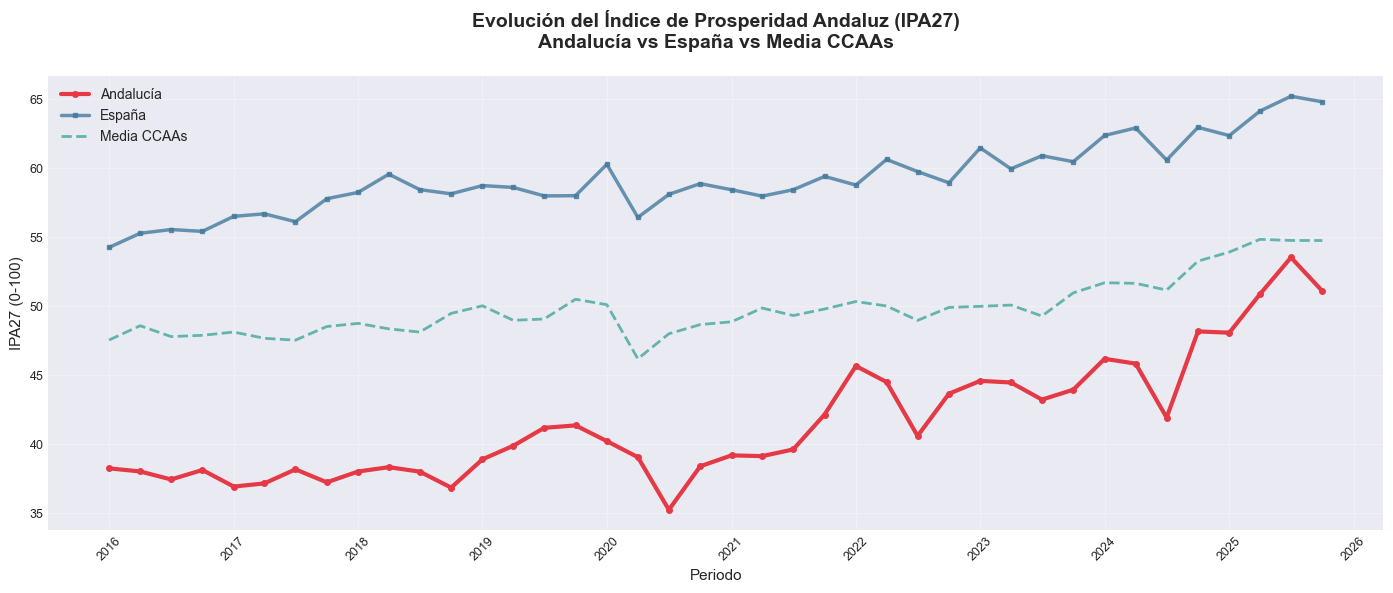

📊 2/6 Generando: Radar chart por dominios...


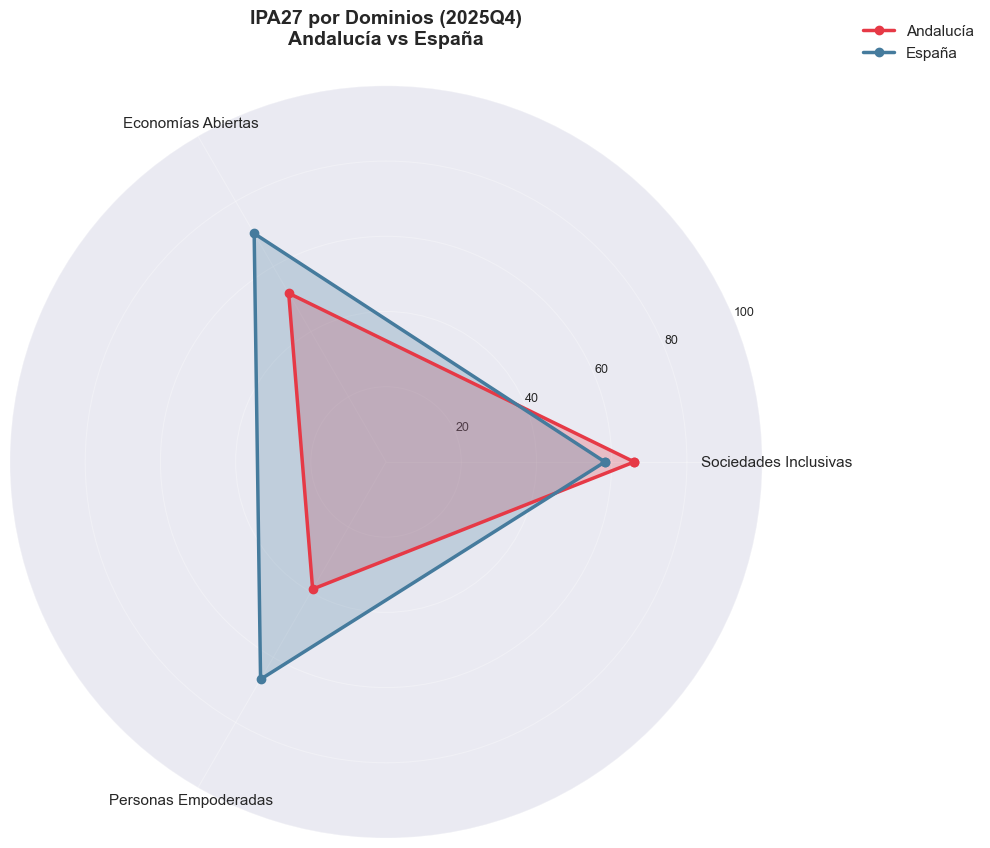

📊 3/6 Generando: Heatmap de pilares...


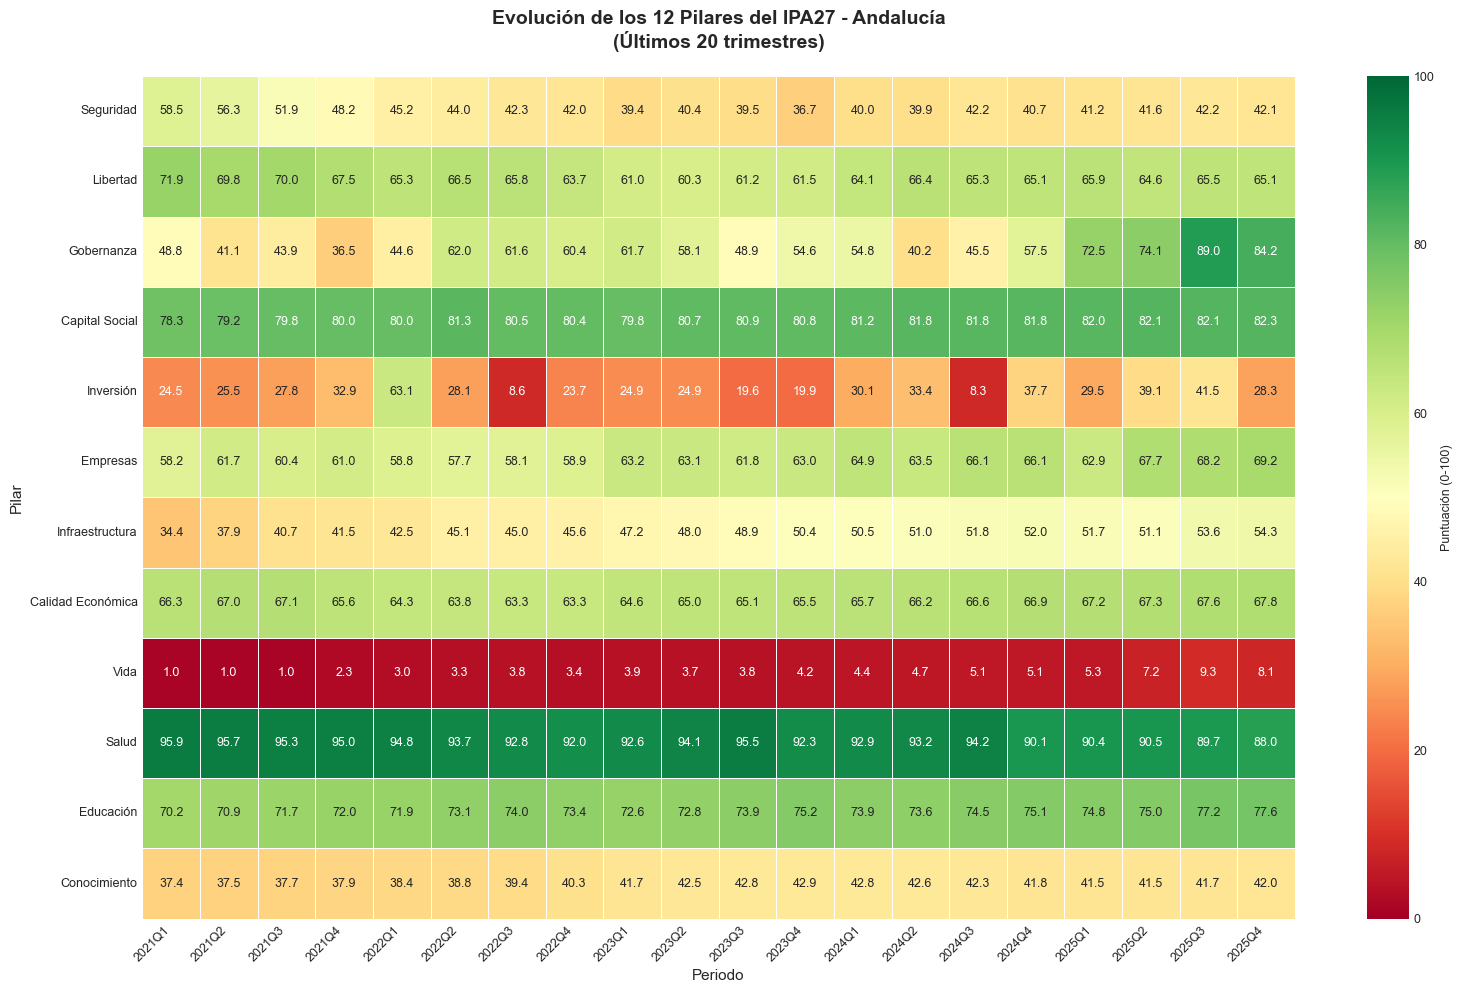

📊 4/6 Generando: Ranking de CCAAs...


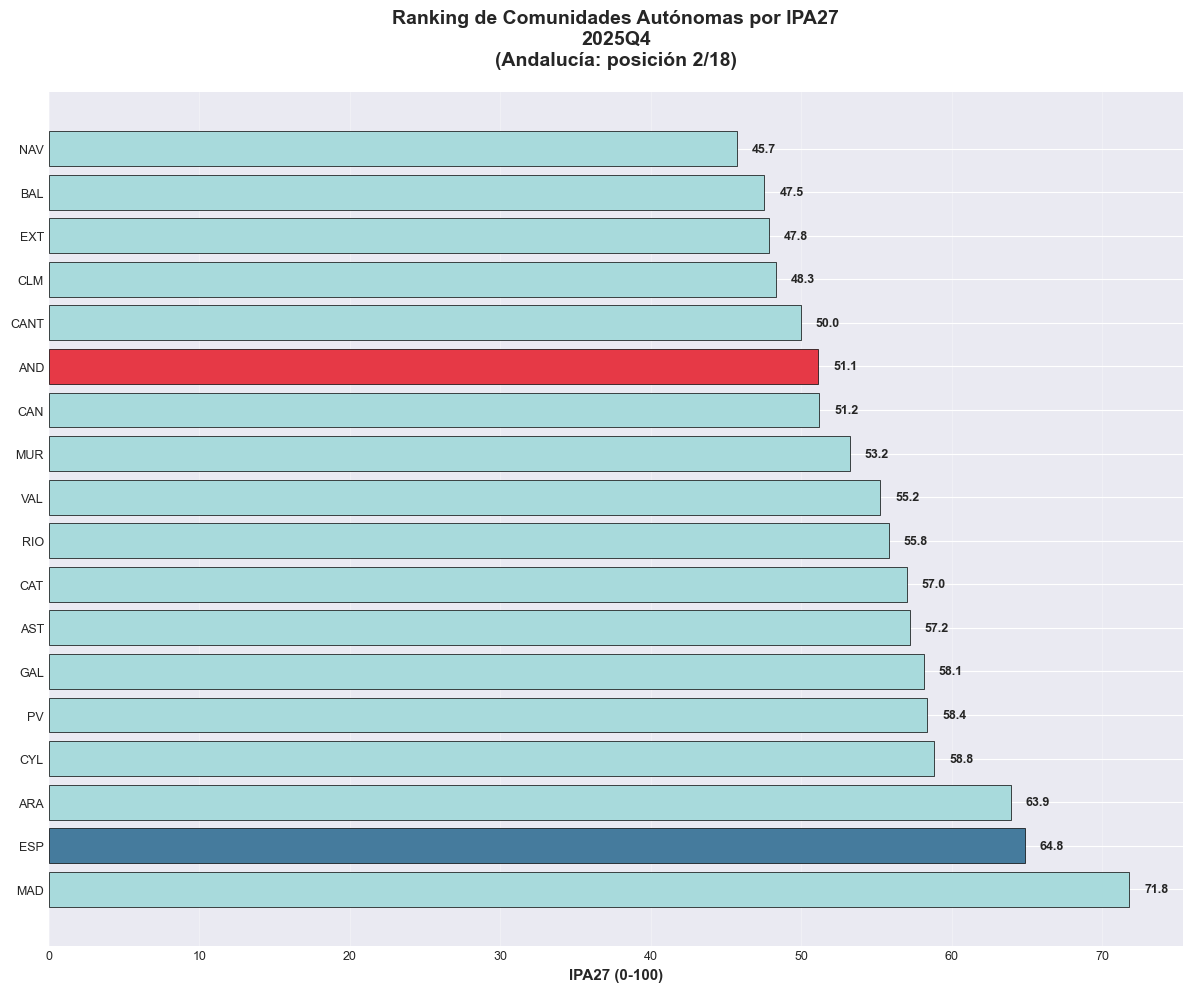

📊 5/6 Generando: Análisis de brechas por dominio...


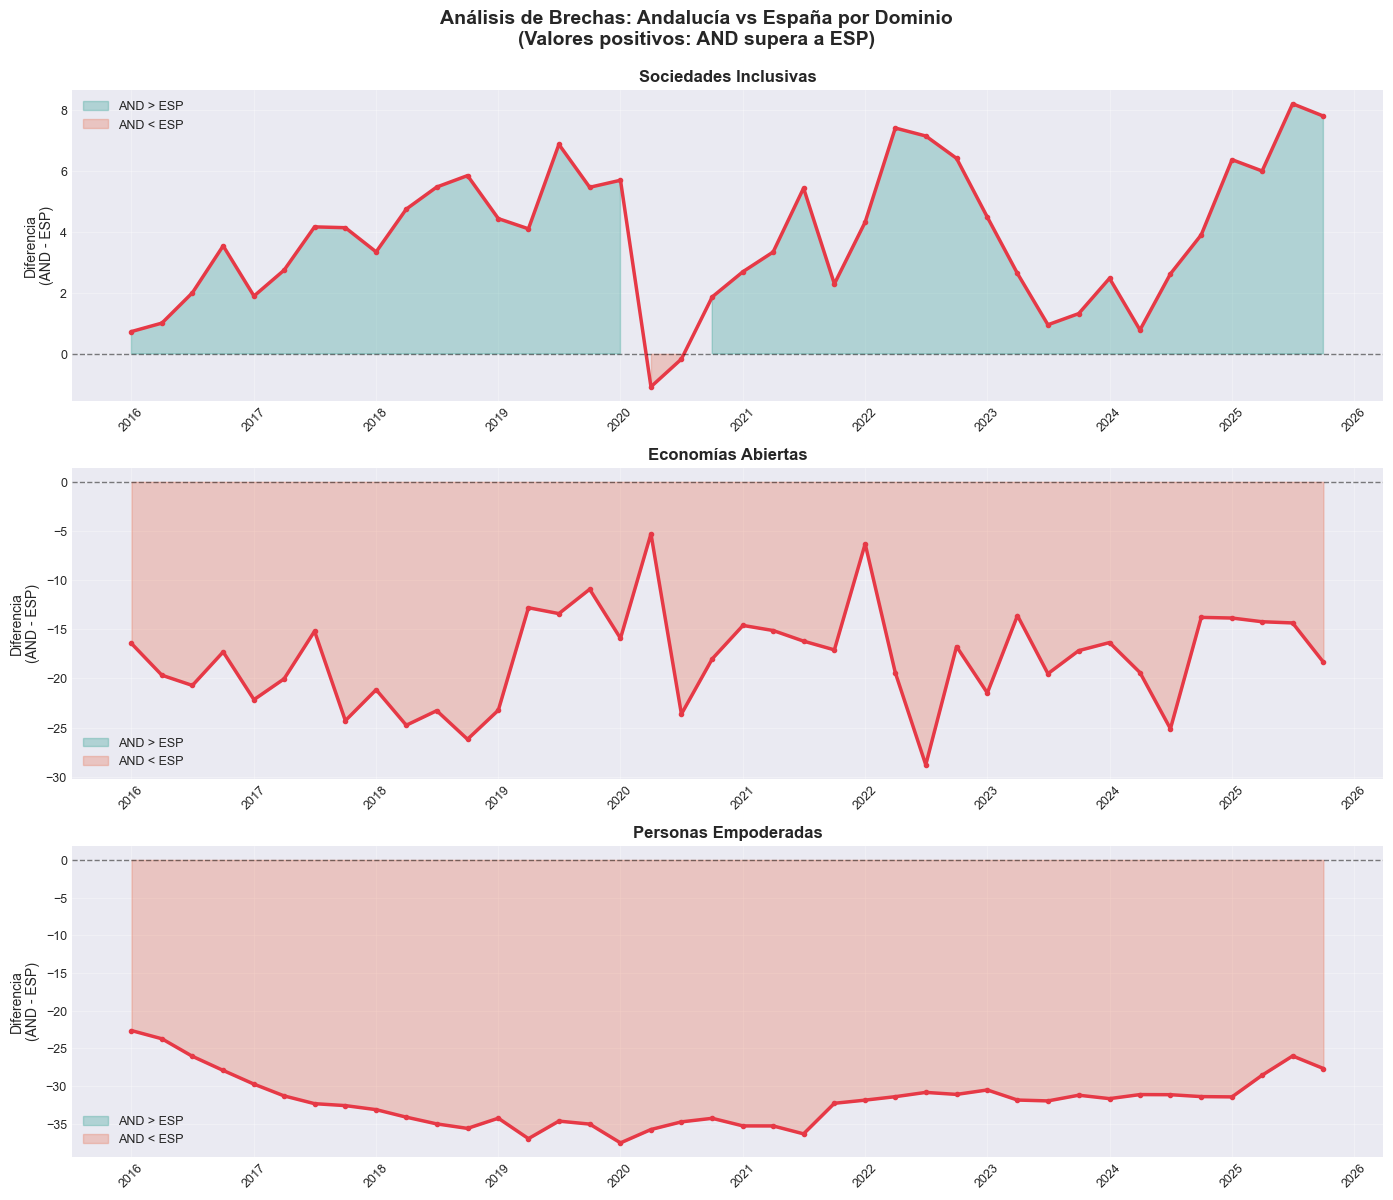

📊 6/6 Generando: Top/Bottom indicadores (Promedio 2 años)...


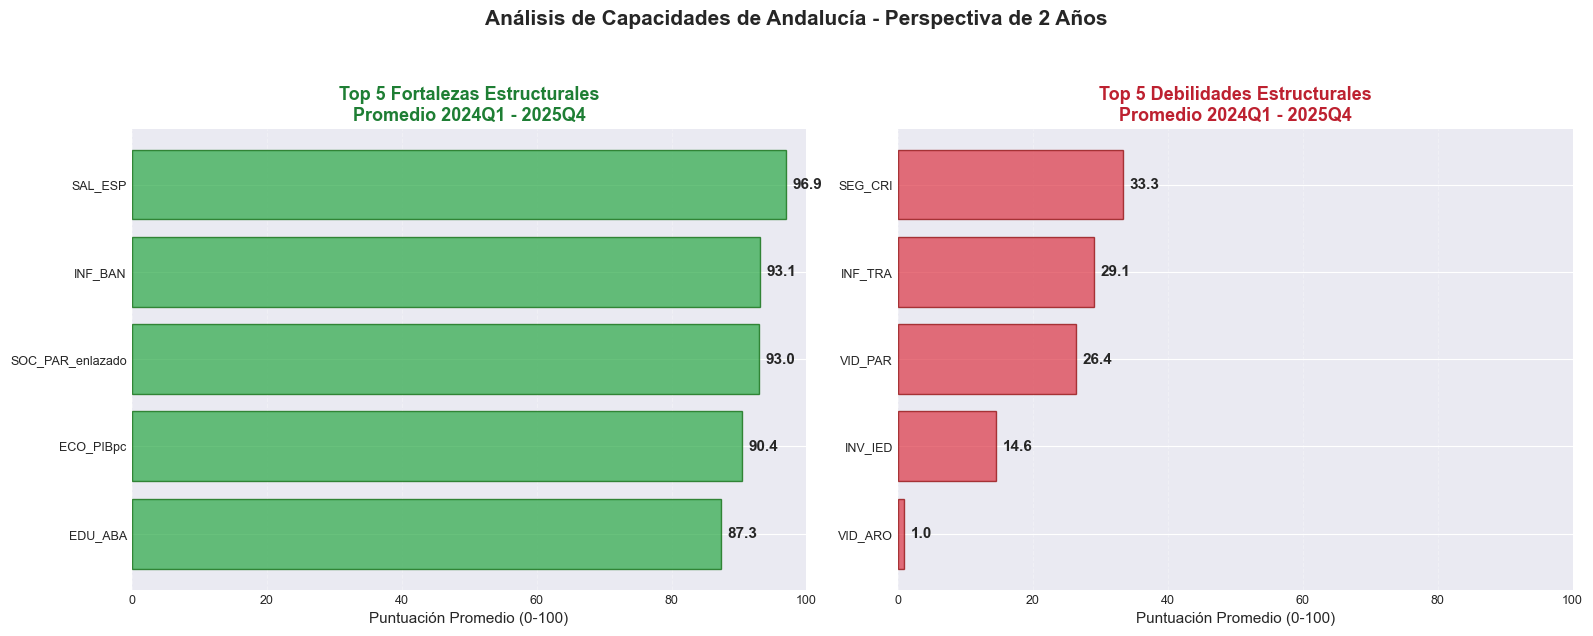

✓ Gráfico guardado: results/figures/analysis/ipa27_top_bottom_indicadores_2y.png

✓ VISUALIZACIONES COMPLETADAS

Archivos generados en: results/figures/analysis/
  1. ipa27_evolucion_temporal.png
  2. ipa27_radar_dominios.png
  3. ipa27_heatmap_pilares.png
  4. ipa27_ranking_ccaas.png
  5. ipa27_brechas_dominios.png
  6. ipa27_top_bottom_indicadores.png


In [ ]:
# %% CELDA 13: VISUALIZACIONES ANDALUCÍA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Crear directorio para guardar figuras
import os
os.makedirs('results/figures/analysis', exist_ok=True)

print("=" * 60)
print("GENERANDO VISUALIZACIONES PARA ANDALUCÍA")
print("=" * 60)

# =============================================================================
# 1. EVOLUCIÓN TEMPORAL IPA27
# =============================================================================
print("\n📊 1/6 Generando: Evolución temporal IPA27...")

fig, ax = plt.subplots(figsize=(14, 6))

# Calcular media de todas las CCAAs (excluyendo España)
ccaas_cols = [c for c in df_ipa27.columns if c != 'IPA27_ESP']
df_ipa27['IPA27_MEDIA_CCAAS'] = df_ipa27[ccaas_cols].mean(axis=1)

# Plot
if 'IPA27_AND' in df_ipa27.columns:
    ax.plot(df_ipa27.index.to_timestamp(), df_ipa27['IPA27_AND'], 
           linewidth=3, label='Andalucía', color='#E63946', marker='o', markersize=4)

if 'IPA27_ESP' in df_ipa27.columns:
    ax.plot(df_ipa27.index.to_timestamp(), df_ipa27['IPA27_ESP'], 
           linewidth=2.5, label='España', color='#457B9D', marker='s', markersize=3, alpha=0.8)

ax.plot(df_ipa27.index.to_timestamp(), df_ipa27['IPA27_MEDIA_CCAAS'], 
       linewidth=2, label='Media CCAAs', color='#2A9D8F', linestyle='--', alpha=0.7)

ax.set_title('Evolución del Índice de Prosperidad Andaluz (IPA27)\nAndalucía vs España vs Media CCAAs', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Periodo', fontsize=11)
ax.set_ylabel('IPA27 (0-100)', fontsize=11)
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('results/figures/analysis/ipa27_evolucion_temporal.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# =============================================================================
# 2. RADAR CHART - COMPARATIVA POR DOMINIOS (ÚLTIMO PERIODO)
# =============================================================================
print("📊 2/6 Generando: Radar chart por dominios...")

# Obtener último periodo con datos
ultimo_periodo = df_dominios.dropna(how='all').index[-1]

# Datos de los 3 dominios
dominios_nombres = list(ESTRUCTURA.keys())
valores_and = [df_dominios.loc[ultimo_periodo, f"{dom}_AND"] for dom in dominios_nombres]
valores_esp = [df_dominios.loc[ultimo_periodo, f"{dom}_ESP"] for dom in dominios_nombres]

# Configurar radar
angles = np.linspace(0, 2 * np.pi, len(dominios_nombres), endpoint=False).tolist()
valores_and += valores_and[:1]  # Cerrar el polígono
valores_esp += valores_esp[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

ax.plot(angles, valores_and, 'o-', linewidth=2.5, label='Andalucía', color='#E63946')
ax.fill(angles, valores_and, alpha=0.25, color='#E63946')

ax.plot(angles, valores_esp, 'o-', linewidth=2.5, label='España', color='#457B9D')
ax.fill(angles, valores_esp, alpha=0.25, color='#457B9D')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(dominios_nombres, fontsize=11)
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'], fontsize=9)
ax.grid(True, alpha=0.3)

plt.title(f'IPA27 por Dominios ({ultimo_periodo})\nAndalucía vs España', 
         fontsize=14, fontweight='bold', pad=30)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)

plt.tight_layout()
plt.savefig('results/figures/analysis/ipa27_radar_dominios.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# =============================================================================
# 3. HEATMAP - PILARES A LO LARGO DEL TIEMPO
# =============================================================================
print("📊 3/6 Generando: Heatmap de pilares...")

# Extraer pilares de Andalucía
pilares_and = [c for c in df_pilares.columns if c.endswith('_AND')]
pilares_nombres = [c.replace('_AND', '').split('. ', 1)[-1] if '. ' in c else c.replace('_AND', '') 
                  for c in pilares_and]

# Últimos 20 trimestres
df_heatmap = df_pilares[pilares_and].tail(20).T
df_heatmap.index = pilares_nombres

fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df_heatmap, annot=True, fmt='.1f', cmap='RdYlGn', 
           vmin=0, vmax=100, cbar_kws={'label': 'Puntuación (0-100)'},
           linewidths=0.5, ax=ax)

ax.set_title('Evolución de los 12 Pilares del IPA27 - Andalucía\n(Últimos 20 trimestres)', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Periodo', fontsize=11)
ax.set_ylabel('Pilar', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('results/figures/analysis/ipa27_heatmap_pilares.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# =============================================================================
# 4. RANKING DE CCAAs (ÚLTIMO PERIODO)
# =============================================================================
print("📊 4/6 Generando: Ranking de CCAAs...")

# Obtener valores del último periodo
ranking_data = []
for region in REGIONES:
    col = f"IPA27_{region}"
    if col in df_ipa27.columns:
        val = df_ipa27.loc[ultimo_periodo, col]
        if pd.notna(val):
            ranking_data.append({'Region': region, 'IPA27': val})

df_ranking = pd.DataFrame(ranking_data).sort_values('IPA27', ascending=False)

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 10))

# Colores: Andalucía en rojo, España en azul, resto en gris
colors = ['#E63946' if r == 'AND' else '#457B9D' if r == 'ESP' else '#A8DADC' 
         for r in df_ranking['Region']]

bars = ax.barh(df_ranking['Region'], df_ranking['IPA27'], color=colors, edgecolor='black', linewidth=0.5)

# Destacar Andalucía
posicion_and = df_ranking[df_ranking['Region'] == 'AND'].index[0] + 1 if 'AND' in df_ranking['Region'].values else None

ax.set_xlabel('IPA27 (0-100)', fontsize=11, fontweight='bold')
ax.set_title(f'Ranking de Comunidades Autónomas por IPA27\n{ultimo_periodo}' +
            (f'\n(Andalucía: posición {posicion_and}/{len(df_ranking)})' if posicion_and else ''),
            fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Añadir valores
for i, (idx, row) in enumerate(df_ranking.iterrows()):
    ax.text(row['IPA27'] + 1, i, f"{row['IPA27']:.1f}", 
           va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/analysis/ipa27_ranking_ccaas.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# =============================================================================
# 5. ANÁLISIS DE BRECHAS AND-ESP POR DOMINIO
# =============================================================================
print("📊 5/6 Generando: Análisis de brechas por dominio...")

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for i, dominio in enumerate(dominios_nombres):
    col_and = f"{dominio}_AND"
    col_esp = f"{dominio}_ESP"
    
    if col_and in df_dominios.columns and col_esp in df_dominios.columns:
        brecha = df_dominios[col_and] - df_dominios[col_esp]
        
        axes[i].plot(brecha.index.to_timestamp(), brecha, 
                    linewidth=2.5, color='#E63946', marker='o', markersize=3)
        axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[i].fill_between(brecha.index.to_timestamp(), 0, brecha, 
                            where=(brecha >= 0), color='#2A9D8F', alpha=0.3, label='AND > ESP')
        axes[i].fill_between(brecha.index.to_timestamp(), 0, brecha, 
                            where=(brecha < 0), color='#E76F51', alpha=0.3, label='AND < ESP')
        
        axes[i].set_title(f'{dominio}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Diferencia\n(AND - ESP)', fontsize=10)
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(loc='best', fontsize=9)
        axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Análisis de Brechas: Andalucía vs España por Dominio\n(Valores positivos: AND supera a ESP)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('results/figures/analysis/ipa27_brechas_dominios.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# =============================================================================
# 6. TOP 5 / BOTTOM 5 INDICADORES (PROMEDIO ÚLTIMOS 2 AÑOS)
# =============================================================================
print("📊 6/6 Generando: Top/Bottom indicadores (Promedio 2 años)...")

# 1. Definir la ventana de 2 años (8 trimestres) desde el final
ventana_2y = df_norm.index[-8:]

# 2. Obtener indicadores de Andalucía (excluyendo auxiliares)
indicadores_and = [c for c in df_norm.columns if c.endswith('_AND') and not c.startswith('AUX_')]

# 3. Calcular la media de los últimos 2 años para cada indicador
valores_promedio = []
for col in indicadores_and:
    # Calculamos la media ignorando nulos en esos 8 trimestres
    media = df_norm.loc[ventana_2y, col].mean()
    if pd.notna(media):
        valores_promedio.append((col.replace('_AND', ''), media))

# 4. Ordenar por puntuación media
valores_promedio_sorted = sorted(valores_promedio, key=lambda x: x[1], reverse=True)

top5 = valores_promedio_sorted[:5]
bottom5 = valores_promedio_sorted[-5:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- GRÁFICO 1: FORTALEZAS ---
nombres_top = [x[0] for x in top5]
valores_top = [x[1] for x in top5]
ax1.barh(nombres_top, valores_top, color='#28a745', edgecolor='darkgreen', alpha=0.7)
ax1.set_xlabel('Puntuación Promedio (0-100)', fontsize=11)
ax1.set_title(f'Top 5 Fortalezas Estructurales\nPromedio {ventana_2y[0]} - {ventana_2y[-1]}', 
             fontsize=13, fontweight='bold', color='#1e7e34')
ax1.set_xlim(0, 100)
ax1.grid(axis='x', linestyle='--', alpha=0.3)
ax1.invert_yaxis() # Invertir para que el mejor esté arriba

for i, v in enumerate(valores_top):
    ax1.text(v + 1, i, f"{v:.1f}", va='center', fontsize=11, fontweight='bold')

# --- GRÁFICO 2: DEBILIDADES ---
nombres_bottom = [x[0] for x in bottom5]
valores_bottom = [x[1] for x in bottom5]
ax2.barh(nombres_bottom, valores_bottom, color='#dc3545', edgecolor='darkred', alpha=0.7)
ax2.set_xlabel('Puntuación Promedio (0-100)', fontsize=11)
ax2.set_title(f'Top 5 Debilidades Estructurales\nPromedio {ventana_2y[0]} - {ventana_2y[-1]}', 
             fontsize=13, fontweight='bold', color='#bd2130')
ax2.set_xlim(0, 100)
ax2.grid(axis='x', linestyle='--', alpha=0.3)
ax2.invert_yaxis() # Invertir para que el peor esté abajo

for i, v in enumerate(valores_bottom):
    ax2.text(v + 1, i, f"{v:.1f}", va='center', fontsize=11, fontweight='bold')

plt.suptitle(f'Análisis de Capacidades de Andalucía - Perspectiva de 2 Años', 
            fontsize=15, fontweight='bold', y=1.05)
plt.tight_layout()

# Guardar con nuevo nombre para indicar que es promedio
plt.savefig('results/figures/analysis/ipa27_top_bottom_indicadores_2y.png', 
            dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✓ Gráfico guardado: results/figures/analysis/ipa27_top_bottom_indicadores_2y.png")

print("\n" + "=" * 60)
print("✓ VISUALIZACIONES COMPLETADAS")
print("=" * 60)
print("\nArchivos generados en: results/figures/analysis/")
print("  1. ipa27_evolucion_temporal.png")
print("  2. ipa27_radar_dominios.png")
print("  3. ipa27_heatmap_pilares.png")
print("  4. ipa27_ranking_ccaas.png")
print("  5. ipa27_brechas_dominios.png")
print("  6. ipa27_top_bottom_indicadores.png")

# Exportación a dashboard


In [ ]:
import json
import pandas as pd
import os

def export_dashboard_data(df_global, df_dominios, df_pilares, df_norm, estructura, output_path):
    """
    Simula la lógica que debería ir en el notebook para generar el JSON.
    """
    # 1. Definir nombres amigables para los indicadores
    INDICADORES_NOMBRES = {
        'SEG_BAL': 'Balance de Criminalidad',
        'SEG_CRI': 'Tasa de Delitos',
        'LIB_ODI': 'Delitos de Odio',
        'LIB_SEX': 'Violencia Género',
        'GOB_DES': 'Desempleo (Pilar Gob.)',
        'GOB_EFF': 'Eficacia Institucional',
        'SOC_ASO': 'Asociacionismo',
        'SOC_PAR_enlazado': 'Participación Electoral',
        'INV_HIP': 'Hipotecas',
        'INV_IED': 'Inversión Extranjera',
        'EMP_NAT': 'Nacimientos Empresas',
        'EMP_SOC': 'Sociedades Mercantiles',
        'INF_BAN': 'Bancarización',
        'INF_TRA': 'Tráfico Ferroviario',
        'ECO_RBHpc': 'Renta Bruta Habitante',
        'ECO_COL_sal': 'Coste Salarial Real',
        'VID_ARO': 'Tasa AROPE',
        'VID_PAR': 'Paro Larga Duración',
        'SAL_ESP': 'Esperanza de Vida',
        'SAL_SAT_enlazado': 'Satisfacción Sanitaria',
        'EDU_ABA': 'Abandono Escolar',
        'EDU_SUP': 'Educación Superior',
        'CON_IDI': 'Inversión I+D',
        'CON_OCI': 'Ocupación Conocimiento'
    }

    # 2. Preparar históricos (2015-2025)
    # df_global tiene índice Period
    df_hist = df_global.loc['2015Q1':].copy()
    evolution = {
        "labels": [str(p) for p in df_hist.index],
        "and_global": df_hist['IPA27_AND'].round(2).tolist(),
        "esp_global": df_hist['IPA27_ESP'].round(2).tolist()
    }

    # 3. Datos último trimestre
    last_q = df_hist.index[-1]
    
    current_data = {
        "periodo": str(last_q),
        "and": {
            "global": round(df_hist.loc[last_q, 'IPA27_AND'], 1),
            "dominios": {d: round(df_dominios.loc[last_q, f'{d}_AND'], 1) for d in estructura.keys()},
            "pilares": {p: round(df_pilares.loc[last_q, f'{p}_AND'], 1) for d in estructura.values() for p in d.keys()},
            "indicadores": {ind: round(df_norm.loc[last_q, f'{ind}_AND'], 1) for d in estructura.values() for p in d.values() for ind in p}
        },
        "esp": {
            "global": round(df_hist.loc[last_q, 'IPA27_ESP'], 1),
            "dominios": {d: round(df_dominios.loc[last_q, f'{d}_ESP'], 1) for d in estructura.keys()},
            "pilares": {p: round(df_pilares.loc[last_q, f'{p}_ESP'], 1) for d in estructura.values() for p in d.keys()},
        }
    }

    # 4. Cuellos de botella
    ind_and_vals = {ind: df_norm.loc[last_q, f'{ind}_AND'] for d in estructura.values() for p in d.values() for ind in p}
    sorted_inds = sorted(ind_and_vals.items(), key=lambda x: x[1])
    bottlenecks = [
        {"code": item[0], "name": INDICADORES_NOMBRES.get(item[0], item[0]), "value": round(item[1], 1)} 
        for item in sorted_inds[:3]
    ]

    # 5. Consolidar
    dashboard_json = {
        "metadata": {
            "last_update": str(last_q),
            "indicator_names": INDICADORES_NOMBRES,
            "structure": estructura
        },
        "evolution": evolution,
        "current": current_data,
        "bottlenecks": bottlenecks
    }

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(dashboard_json, f, ensure_ascii=False, indent=2)
    
    return f"✅ Exportado a {output_path}"

# Este script no se puede ejecutar directamente aquí por falta de los DataFrames en memoria de Python fuera del notebook, 
# pero servirá de base para la actualización de la web.


In [ ]:
# %% CELDA 10: GENERACIÓN DE FICHAS DE AUDITORÍA (TRAZABILIDAD COMPLETA)
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np

# Mapeo de Nombres Largos para la Ficha
NOMBRES_LARGOS = {
    'SEG_BAL': 'Balance de Seguridad',
    'SEG_CRI': 'Índice de Criminalidad',
    'LIB_ODI': 'Delitos de Odio',
    'LIB_SEX': 'Delitos contra la Libertad Sexual',
    'GOB_DES': 'Desconfianza en las Instituciones',
    'GOB_EFF': 'Efectividad Gubernamental',
    'SOC_ASO': 'Asociacionismo',
    'SOC_PAR_enlazado': 'Participación Política',
    'INV_HIP': 'Inversión Hipotecaria',
    'INV_IED': 'Inversión Extranjera Directa',
    'EMP_NAT': 'Natalidad Empresarial',
    'EMP_SOC': 'Sociedades Constituidas',
    'INF_BAN': 'Bancarización',
    'INF_TRA': 'Tráfico de Mercancías',
    'ECO_RBHpc': 'Renta Bruta de los Hogares per cápita',
    'ECO_COL_sal': 'Coste Salarial Real',
    'ECO_PIBpc': 'PIB Real per cápita',
    'VID_ARO': 'Tasa de Riesgo de Pobreza (AROPE)',
    'VID_PAR': 'Tasa de Paro',
    'SAL_ESP': 'Esperanza de Vida al Nacer',
    'SAL_SAT_enlazado': 'Satisfacción con los Servicios de Salud',
    'EDU_ABA': 'Tasa de Abandono Escolar Temprano',
    'EDU_SUP': 'Población con Educación Superior',
    'CON_IDI': 'Nivel de Idiomas',
    'CON_OCI': 'Ocio y Cultura (Afiliados)'
}

def generar_auditoria_completa_pdf(output_folder='results/auditoria'):
    if not os.path.exists(output_folder): 
        os.makedirs(output_folder)
    
    idx_ts = df_trim.index.to_timestamp()
    idx_norm_ts = df_norm.index.to_timestamp()
    
    print(f"Generando fichas de trazabilidad en {output_folder}...")

    # Parámetros del último cálculo de techos
    H = HORIZONTE_ANOS if 'HORIZONTE_ANOS' in globals() else 5

    count = 0
    for ind in indicadores_unicos:
        techo_data = next((item for item in detalles_techos if item['Indicador'] == ind), None)
        audit_data = AUDIT_REGISTRY.get(ind, None)
        
        if not techo_data or not audit_data: 
            continue

        nombre_long = NOMBRES_LARGOS.get(ind, ind)
        filename = f"{output_folder}/Audit_{ind}.pdf"
        
        with PdfPages(filename) as pdf:
            fig = plt.figure(figsize=(11.69, 16.54)) # A3 Portrait para claridad
            brand_color = '#007932'
            
            plt.suptitle(f"TRAZABILIDAD IPA27: {nombre_long} ({ind})", fontsize=22, fontweight='bold', color=brand_color, y=0.98)
            
            # --- PANEL DE METADATOS TÉCNICOS ---
            ax_info = plt.subplot2grid((5, 2), (0, 0), colspan=2)
            ax_info.axis('off')
            info_text = (
                f"1. FOTOGRAFÍA DEL DATO ORIGINAL:\n"
                f"   • Fuente Principal: {audit_data['fuente_frecuencia']}  |  Observaciones Originales: {audit_data['n_obs_raw']}  |  Rango: {audit_data['rango_raw']}\n"
                f"   • Transformaciones Aplicadas: Chow-Lin={'SÍ' if audit_data['chowlin'] else 'NO'} | Per Cápita={'SÍ' if audit_data['per_capita'] else 'NO'} | Deflactado IPC={'SÍ' if audit_data['deflactado'] else 'NO'}\n\n"
                f"2. CONFIGURACIÓN DEL TECHO (OBJETIVO 100):\n"
                f"   • Dirección: {'MENOR ES MEJOR (Invertido)' if techo_data['Dirección'] == 'INV' else 'MAYOR ES MEJOR (Normal)'}\n"
                f"   • Regiones de Referencia (Top 3): {techo_data.get('Regiones_Base', 'N/A')}\n"
                f"   • Valor Promedio Histórico del Top 3: {techo_data['Media_TopN']:.4f}\n"
                f"   • Ajuste por Tendencia (Delta Anual): {techo_data['Delta_anual']:.4f}  x  Horizonte {H} años\n"
                f"   • TECHO FINAL FIJADO: {techo_data['Techo']:.4f}  (Fiabilidad: {techo_data['Fiabilidad']})"
            )
            ax_info.text(0.05, 0.5, info_text, transform=ax_info.transAxes, fontsize=11, family='monospace',
                         verticalalignment='center', bbox=dict(facecolor='#f9f9f9', edgecolor=brand_color, boxstyle='round,pad=1.5'))

            # --- GRÁFICO 1: DATO BRUTO ORIGINAL (Snapshot) ---
            ax1 = plt.subplot2grid((5, 2), (1, 0), colspan=2)
            snap = audit_data['snapshot_raw']
            if snap and (snap['AND'] is not None or snap['ESP'] is not None):
                if snap['AND'] is not None:
                    # Asegurar conversión a datetime para el plot
                    idx_snap_and = snap['AND'].index.to_timestamp() if hasattr(snap['AND'].index, 'to_timestamp') else snap['AND'].index
                    ax1.plot(idx_snap_and, snap['AND'].values, marker='o', color=brand_color, label='Andalucía (Bruto Excel)', linewidth=2)
                if snap['ESP'] is not None:
                    idx_snap_esp = snap['ESP'].index.to_timestamp() if hasattr(snap['ESP'].index, 'to_timestamp') else snap['ESP'].index
                    ax1.plot(idx_snap_esp, snap['ESP'].values, marker='s', color='#333333', label='España (Bruto Excel)', linewidth=1.5, linestyle='--')
            
            ax1.set_title(f"A. MATERIA PRIMA (Escala original. Frecuencia: {audit_data['fuente_frecuencia']})", fontsize=12, fontweight='bold')
            ax1.legend(loc='best')
            ax1.grid(True, alpha=0.3)

            # --- GRÁFICO 2: DATO REFINADO Y TRIMESTRALIZADO ---
            ax2 = plt.subplot2grid((5, 2), (2, 0), colspan=2)
            cols_ind = [c for c in df_trim.columns if c.startswith(f"{ind}_")]
            for col in sorted(cols_ind):
                reg = col.split('_')[-1]
                if reg == 'ESP':
                    ax2.plot(idx_ts, df_trim[col], color='#333333', linewidth=2, label='España (Procesado)')
                elif reg == 'AND':
                    ax2.plot(idx_ts, df_trim[col], color=brand_color, linewidth=2.5, label='Andalucía (Procesado)')
                else:
                    ax2.plot(idx_ts, df_trim[col], color='#cccccc', linewidth=0.5, alpha=0.5)
            
            ax2.axhline(y=techo_data['Techo'], color='red', linestyle='--', linewidth=2, label=f"Techo Objetivo ({techo_data['Techo']:.2f})")
            ax2.set_title("B. DATOS REFINADOS (Sometidos a Chow-Lin / Per Cápita / Splines)", fontsize=12, fontweight='bold')
            ax2.legend(loc='best')
            ax2.grid(True, alpha=0.3)

            # --- GRÁFICO 3: DATOS NORMALIZADOS (0 - 100) ---
            ax3 = plt.subplot2grid((5, 2), (3, 0), colspan=2)
            for col in sorted(cols_ind):
                if col in df_norm.columns:
                    reg = col.split('_')[-1]
                    color = brand_color if reg == 'AND' else ('#333333' if reg == 'ESP' else '#dddddd')
                    linewidth = 2 if reg in ['AND', 'ESP'] else 0.5
                    ax3.plot(idx_norm_ts, df_norm[col], color=color, linewidth=linewidth)
            
            ax3.axhline(y=100, color='#0984e3', linestyle=':', linewidth=1.5, label='Nivel Óptimo (100)')
            ax3.set_ylim(-5, 125)
            ax3.set_title("C. PUNTUACIÓN DE ÍNDICE IPA27 (0 a 100)", fontsize=12, fontweight='bold')
            ax3.set_ylabel("Score")
            ax3.legend(loc='best')
            ax3.grid(True, alpha=0.3)

            # --- GRÁFICO 4: RADIOGRAFÍA DEL ÚLTIMO TRIMESTRE ---
            ax4 = plt.subplot2grid((5, 2), (4, 0), colspan=2)
            # Ordenamos para visualizar mejor
            snap_last = df_trim[cols_ind].iloc[-1].sort_values(ascending=(techo_data['Dirección'] == 'INV'))
            names_last = [n.split('_')[-1] for n in snap_last.index]
            colors_last = [brand_color if n == 'AND' else ('#333333' if n == 'ESP' else '#74b9ff') for n in names_last]
            
            ax4.bar(names_last, snap_last.values, color=colors_last, alpha=0.8)
            ax4.axhline(y=techo_data['Techo'], color='red', linestyle='--', linewidth=1.5, label='Techo')
            ax4.set_title(f"D. CONTEXTO REGIONAL DEL ÚLTIMO PERIODO ({ultimo_q})", fontsize=12, fontweight='bold')
            ax4.grid(axis='y', alpha=0.2)

            plt.tight_layout(rect=[0, 0.02, 1, 0.96])
            pdf.savefig()
            plt.close()
            count += 1

    print(f"✓ ÉXITO: {count} Fichas Analíticas de Trazabilidad creadas en '{output_folder}/'.")

# Desencadenar la generación
generar_auditoria_completa_pdf()


Generando fichas de trazabilidad en results/auditoria...
✓ ÉXITO: 24 Fichas Analíticas de Trazabilidad creadas en 'results/auditoria/'.
